## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import skew, shapiro

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from keras.preprocessing.text import Tokenizer # clean and tokenize data
from keras.preprocessing.sequence import pad_sequences #
from keras.initializers import he_normal
import tensorflow as tf
import keras.backend as K # facilitate the computation of performance metrics

In [3]:
# display purposes
%config InlineBackend.figure_format = 'retina'
# Parameter mappings to override the values in the preset seaborn style dictionaries
color = 'black'
sns.set_theme(rc={'grid.color': 'white', 
                  'xtick.color': color,
                  'ytick.color': color,
                  'axes.labelcolor': color,
                  'text.color': color,
                  'axes.facecolor':(0,0,0,0),
                  'figure.facecolor':(0,0,0,0)})

## Load Datasets

In [4]:
train_df = pd.read_csv('../datasets/train_df.csv')
sg_entities_patterns_df = pd.read_csv('../datasets/sg_entities_patterns.csv')
post_df = pd.read_csv('../datasets/video_info_audio_caption_cleaned_final.csv')

#### Check each dataset

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31327 entries, 0 to 31326
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   post_comment         31327 non-null  object 
 1   id                   31327 non-null  object 
 2   sentence             31327 non-null  object 
 3   entity               31327 non-null  object 
 4   pos_sentiment_words  31327 non-null  object 
 5   neg_sentiment_words  31327 non-null  object 
 6   textblob             31327 non-null  float64
 7   sentiment            31327 non-null  float64
dtypes: float64(2), object(6)
memory usage: 1.9+ MB


In [6]:
sg_entities_patterns_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   label              510 non-null    object 
 1   pattern            510 non-null    object 
 2   sublocation        510 non-null    object 
 3   count              34 non-null     object 
 4   country            110 non-null    object 
 5   interest_1         510 non-null    object 
 6   interest_2         74 non-null     object 
 7   indoor_outdoor     510 non-null    object 
 8   adjective          0 non-null      float64
 9   video_sentiment    0 non-null      float64
 10  comment_sentiment  0 non-null      float64
dtypes: float64(3), object(8)
memory usage: 44.0+ KB


In [7]:
post_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      401 non-null    object
 1   url                     401 non-null    object
 2   account_name            401 non-null    object
 3   following_count         401 non-null    int64 
 4   follower_count          401 non-null    int64 
 5   total_like_count        401 non-null    int64 
 6   date                    401 non-null    object
 7   href                    401 non-null    object
 8   handle                  401 non-null    object
 9   description             387 non-null    object
 10  hashtag                 401 non-null    object
 11  like_count              401 non-null    int64 
 12  bookmark_count          401 non-null    int64 
 13  share_count             401 non-null    int64 
 14  comment_count           401 non-null    int64 
 15  final_

In [8]:
train_df.head()

,post_comment,id,sentence,entity,pos_sentiment_words,neg_sentiment_words,textblob,sentiment
0,post,0_post,how to spend the perfect 48 hours in singapore,"['48 hour', 'singapore']",['perfect'],[],1.000000,10.000000
1,post,0_post,first head to your waterfall at singapore airp...,"['first', 'singapore airport']","['absolutely', 'incredible']",[],0.900000,9.642857
2,post,0_post,then head to the center and drop by the future...,"['future world exhibition', 'art science museum']",[],[],0.000000,6.428571
3,post,0_post,next you have to head to gardens by the bay it...,['garden by the bay'],"['completely', 'free', 'amazing']",[],0.333333,7.619048
4,post,0_post,dont forget to buy tickets for the skyway for ...,"['skyway', 'floral fantasy']","['most', 'magical']",['insane'],0.000000,6.428571


In [9]:
sg_entities_patterns_df.head()

,label,pattern,sublocation,count,country,interest_1,interest_2,indoor_outdoor,adjective,video_sentiment,comment_sentiment
0,FAC,100 am,100 am,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN
1,FAC,313,313 somerset,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN
2,FAC,313 somerset,313 somerset,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN
3,FAC,321 clementi,321 clementi,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN
4,FAC,888 plaza,888 plaza,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN


In [10]:
post_df.head()

,id,url,account_name,following_count,follower_count,total_like_count,date,href,handle,description,hashtag,like_count,bookmark_count,share_count,comment_count,final_text,final_text_description,num_hashtags
0,0_post,https://www.tiktok.com/@montanadarby/video/723...,Montana | Travels,149,95500,4800000,2023-5-12,/@montanadarby,montanadarby,The perfect 48 hour itinerary for Singapore!,"['singapore', 'singaporetravel', 'travel']",36700,25000,5008,208,How to spend the perfect 48 hours in Singapore...,How to spend the perfect 48 hours in Singapore...,3
1,1_post,https://www.tiktok.com/@trippingmillennial/vid...,Travel with Rachael ✈️,474,57100,1800000,2023-1-31,/@trippingmillennial,trippingmillennial,Hawker centers are my love language,"['southeastasia', 'singapore', 'travelsingapore']",4913,3686,806,31,"Skip to Singapore, kind of feels like a trip i...","Skip to Singapore, kind of feels like a trip i...",3
2,2_post,https://www.tiktok.com/@montanadarby/video/721...,Montana | Travels,149,95500,4800000,2023-4-1,/@montanadarby,montanadarby,The ultimate guide on the BEST things to do Si...,"['singapore', 'singaporethingstodo', 'marinaba...",73700,40300,10500,609,Sky Garden at Capita Spring free. Jewel founta...,Sky Garden at Capita Spring free. Jewel founta...,6
3,3_post,https://www.tiktok.com/@aktravelss/video/72089...,AKTRAVELS ✈️ 🌍,129,130199,8400000,2023-3-10,/@aktravelss,aktravelss,Singapore is just different 🇸🇬,"['singapore', 'singaporetiktok', 'singaporelif...",2100000,292800,25100,11700,"shopping in singapore, LOUIS VUITTON","shopping in singapore, LOUIS VUITTON Singapor...",6
4,4_post,https://www.tiktok.com/@belemartorres2/video/7...,Belemar Torres,440,1284,37200,2023-4-4,/@belemartorres2,belemartorres2,Here’s my top 20 most visited place in Singapore!,"['singapore2023', 'travelsingapore', 'solotrav...",10100,7756,1935,71,"top 20 places to visit, merlion park, marina b...","top 20 places to visit, merlion park, marina b...",4


## EDA

In [9]:
train_df.tail()

,post_comment,id,sentence,entity,pos_sentiment_words,neg_sentiment_words,textblob,sentiment
31322,post,435_cmt,locals,[],[],[],0.000000,6.428571
31323,post,435_cmt,you complained singaporeans are rude bec of yo...,['1'],[],"['complained', 'rude']",-0.300000,5.357143
31324,post,435_cmt,i felt sorry for your friend if he is a singap...,['singaporean'],[],['sorry'],-0.500000,4.642857
31325,post,435_cmt,next time do a bit of googling before going to...,[],['new'],[],0.068182,6.672078
31326,post,435_cmt,these opinions sound ignorant,[],['sound'],[],0.400000,7.857143


### Distribution of sentiment score

In [11]:
# create function for statistical data
def normality(df, col):
    stat, p = shapiro(df[col])
    alpha = 0.07
    nl = '\n'
    if p > alpha:
        return f"p: {p}{nl}Since p > {alpha}, it cannot be concluded that {col} does not follow a normal distribution (fail to reject H0)"
    else:
        return f"p: {p}{nl}Since p <= {alpha}, it can be concluded that {col} does not follow a normal distribution (reject H0)"
      

def skewness(df,col):
    if skew(df[col]) == 0:
        pos_neg='not'
    elif skew(df[col]) > 0:
        pos_neg='positively'
    else:
        pos_neg='negatively'
    return f"Distribution of {col} is {pos_neg} skewed, with skew at: {skew(df[col])}"

def statistical_data(df,col):
    nl = '\n'
    return print(f"Statistical Data for {col}\nMean: {df[col].mean()}{nl}Standard Deviation: {df[col].std()}{nl}{normality(df, col)}{nl}{skewness(df,col)}")

In [12]:
statistical_data(train_df, 'sentiment')

Statistical Data for sentiment
Mean: 6.725865842769368
Standard Deviation: 0.8632891578076444
p: 0.0
Since p <= 0.07, it can be concluded that sentiment does not follow a normal distribution (reject H0)
Distribution of sentiment is positively skewed, with skew at: 1.4893384184646674


/Users/edenng/anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


[Text(0.5, 1.0, 'Distribution of Sentiment Score')]

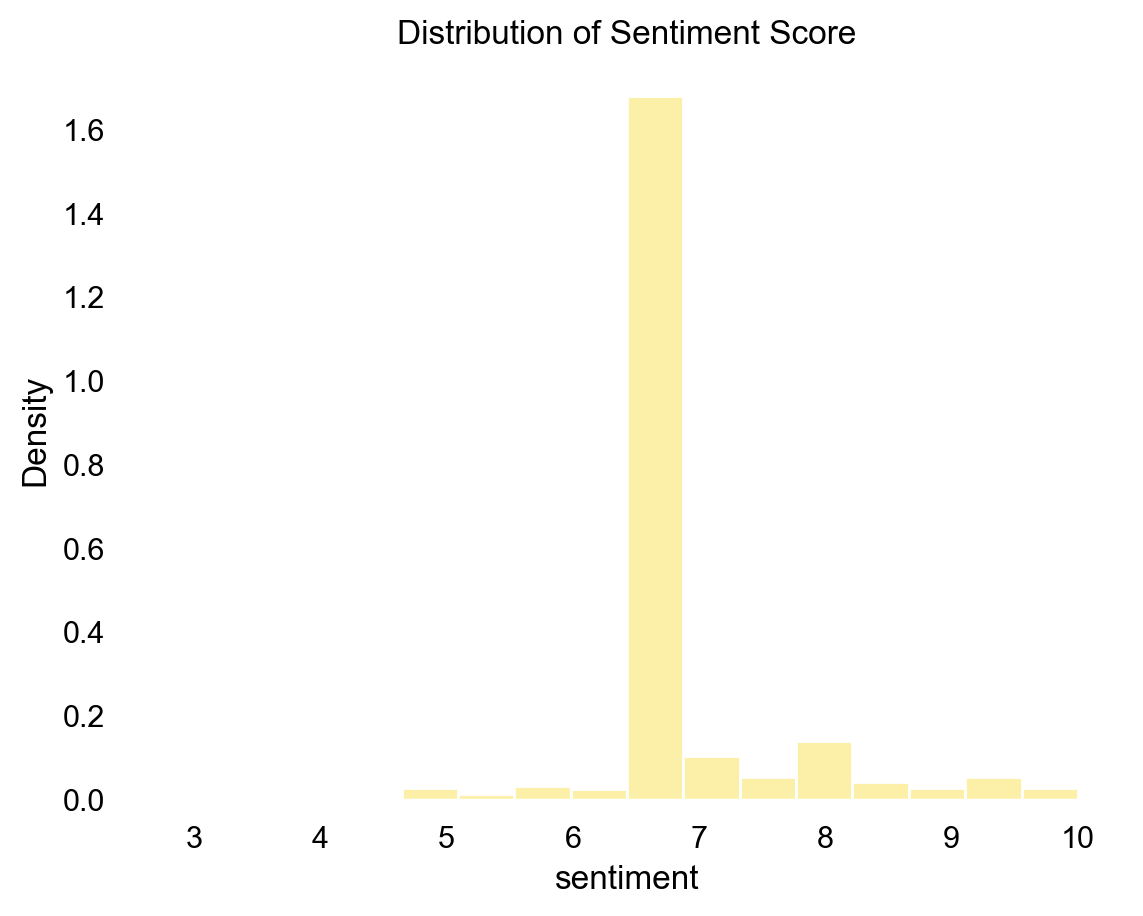

In [13]:
sns.histplot(data=train_df,
             x='sentiment',
             stat='density',
             color='#fcefa7',
            alpha=1.0).set(title='Distribution of Sentiment Score')

We see here that the sentiment score is skewed to the left, with a skew of approximately 1.49 and thus we will have to normalize it in the Feature Engineering portion of the notebook.

### Analyze most commonly used words

#### Convert string of list back to a list

In [14]:
# convert string of list back to a list
train_df['entity'] = train_df['entity'].map(lambda x: ast.literal_eval(x))
train_df['pos_sentiment_words'] = train_df['pos_sentiment_words'].map(lambda x: ast.literal_eval(x))
train_df['neg_sentiment_words'] = train_df['neg_sentiment_words'].map(lambda x: ast.literal_eval(x))

#### Create dataframe for sentences with sentiment scores that are in the 95th percentile (top 5%).

In [15]:
pct = 0.1
rows = len(train_df)

# top_sentences = train_df[train_df['sentiment'] > 8]
top_sentences = train_df.sort_values(by=['sentiment'],ascending=False).head(round(rows * pct))

#### Create dataframe for sentences with sentiment scores that are in the 5th percentile (bottom 5%).

In [16]:
pct = 0.1
rows = len(train_df)

# bottom_sentences = train_df[train_df['sentiment'] < 4]
bottom_sentences = train_df.sort_values(by=['sentiment'],ascending=True).head(round(rows * pct))

In [17]:
remove_entities = ['one','two','first','1','2','3','4','5','6','7','10','30',
                   'ref','kak','juga','ga','bro','kami','sa']

In [18]:
stopwords = stopwords.words('english')
stopwords.extend(['welcome','luck'])

In [19]:
def top_n_grams(corpus, n, ngram, stop):
    # Create a CountVectorizer object with specified n-gram range and stop words
    vec = CountVectorizer(ngram_range=ngram, stop_words=stop)
    # Convert the corpus into a bag of words representation
    bag_of_words = vec.fit_transform(corpus)
    # Calculate the sum of words across all documents
    sum_words = bag_of_words.sum(axis=0) 
    # Create a list of (word, count) pairs from the vocabulary and word counts
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sort the list of (word, count) pairs by count in descending order and select top n
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)[:n]
    # Store top n common n-grams in a dataframe
    df = pd.DataFrame(words_freq, columns=['text', 'count'])
    # Sort the dataframe by the count column in descending order
    df = df.sort_values(by='count', ascending=False)

    return df 

#### Visualize commonly appearing unigrams without stopwords

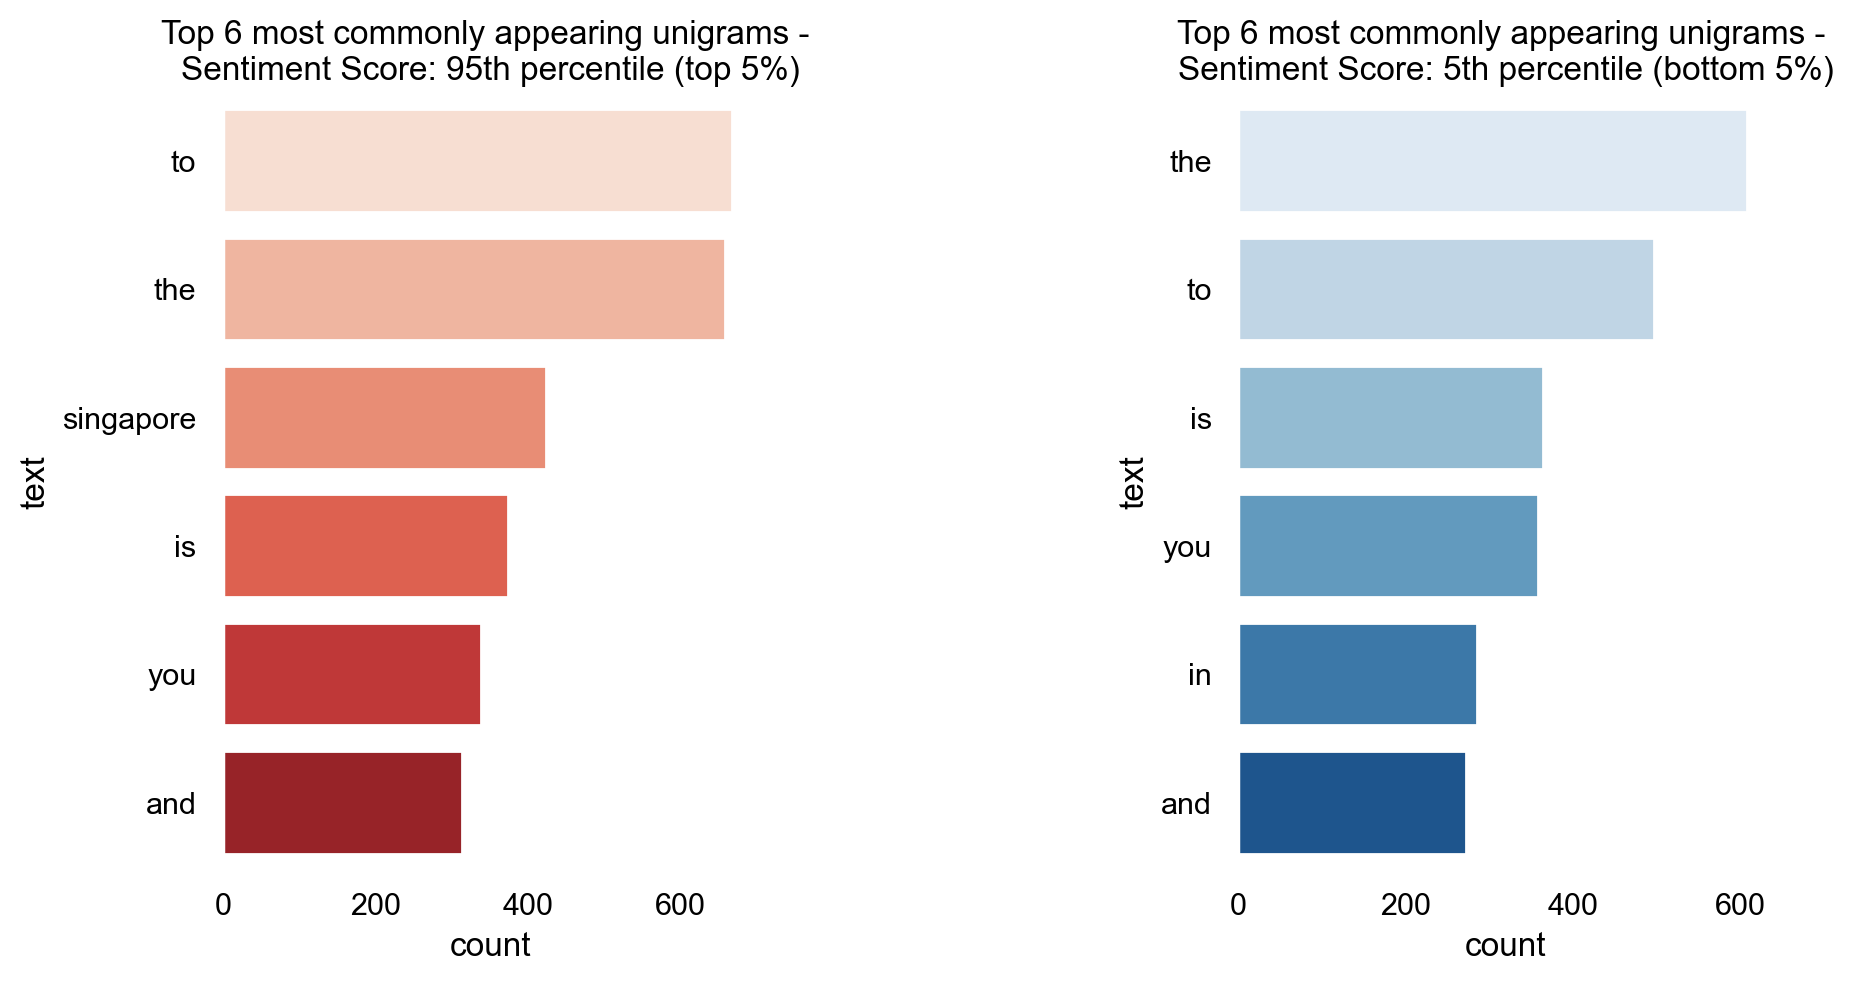

In [20]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=6, ngram=(1,1), stop=None),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 6 most commonly appearing unigrams - \nSentiment Score: 95th percentile (top 5%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=6, ngram=(1,1), stop=None),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 6 most commonly appearing unigrams - \nSentiment Score: 5th percentile (bottom 5%)')
None

Some unigrams do not really mean anything, such as 'to', 'the', 'is', etc. As such, we shall include stopwords in the next step.

#### Visualize commonly appearing unigrams with stopwords

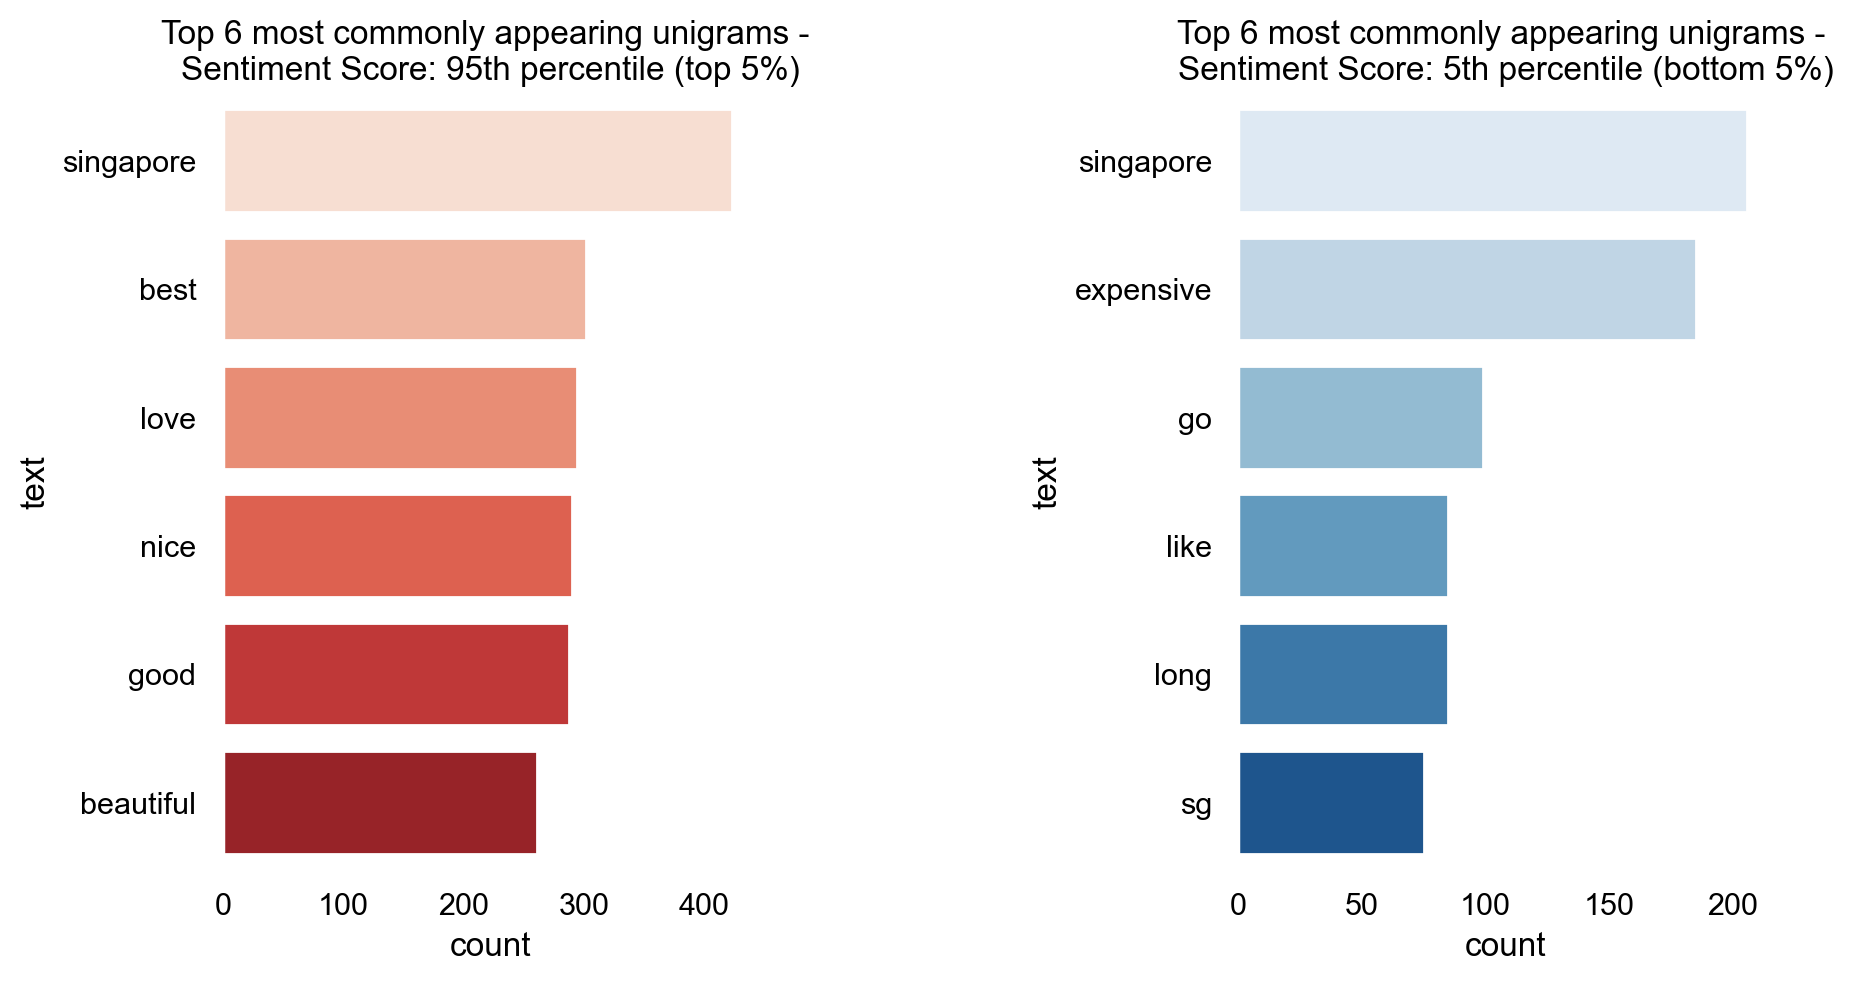

In [21]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=6, ngram=(1,1), stop=stopwords),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 6 most commonly appearing unigrams - \nSentiment Score: 95th percentile (top 5%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=6, ngram=(1,1), stop=stopwords),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 6 most commonly appearing unigrams - \nSentiment Score: 5th percentile (bottom 5%)')
None

With the use of stopwords, the top commonly appearing unigrams now have more meaning. 

However, it is still not extremely clear what the context is. As such, we shall look at bigrams to see if we can gain more insights. 

#### Visualize commonly appearing bigrams without stopwords

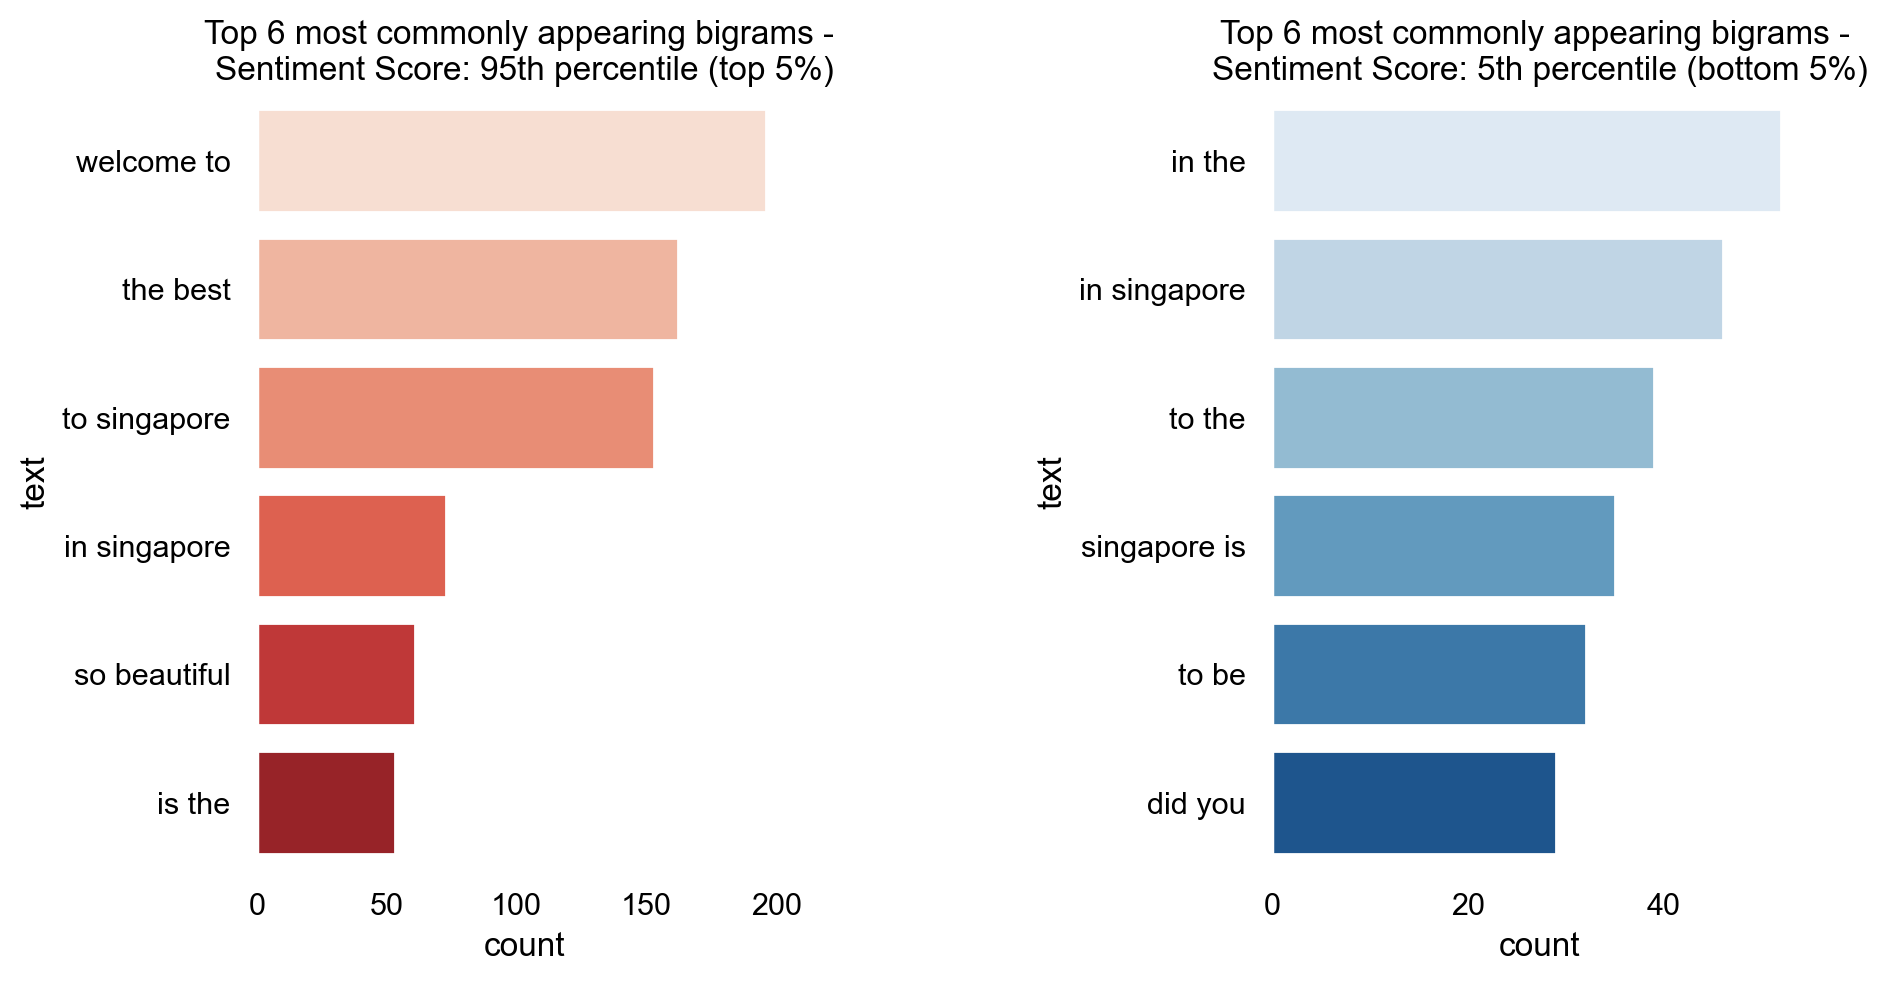

In [22]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=6, ngram=(2,2), stop=None),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 6 most commonly appearing bigrams - \nSentiment Score: 95th percentile (top 5%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=6, ngram=(2,2), stop=None),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 6 most commonly appearing bigrams - \nSentiment Score: 5th percentile (bottom 5%)')
None

Some bigrams do not really mean anything, such as 'to the', 'is the', 'to be', etc. As such, we shall include stopwords in the next step.

#### Visualize commonly appearing bigrams with stopwords

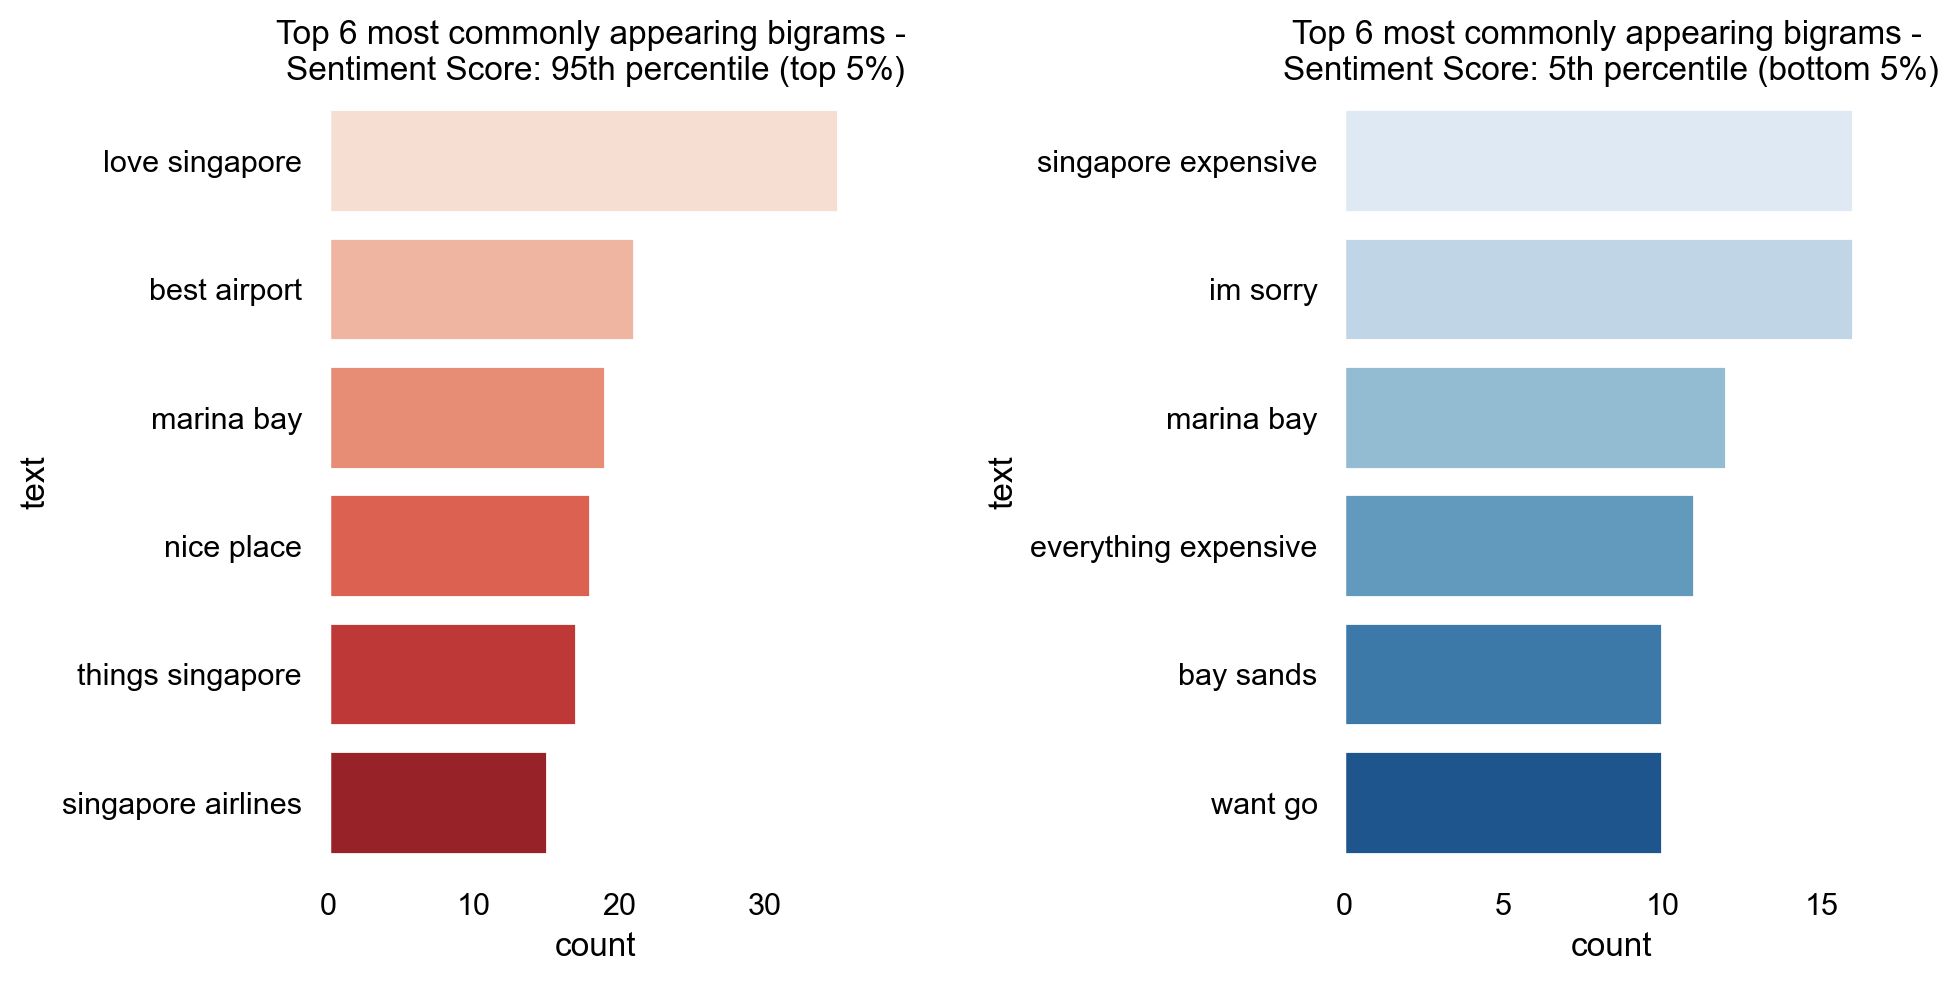

In [23]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=6, ngram=(2,2), stop=stopwords),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 6 most commonly appearing bigrams - \nSentiment Score: 95th percentile (top 5%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=6, ngram=(2,2), stop=stopwords),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 6 most commonly appearing bigrams - \nSentiment Score: 5th percentile (bottom 5%)')
None

With the use of stopwords, the top commonly appearing bigrams now have more meaning. 

In comparison to unigrams, bigrams offer a richer context, allowing us to discern word pairings such as 'best airport' rather than just the isolated word 'best.'

Considering both unigrams and bigrams, it becomes apparent that Singapore is well-received by many tourists, with favorable remarks highlighting its beauty, excellent airport, and airline services. However, unfavorable sentiments arise due to the country's relatively high costs.

A seemingly peculiar observation is the repeated appearance of 'marina bay' in both analyses. This phenomenon can be readily explained by the fact that popular tourist attractions, like 'marina bay,' tend to receive frequent mentions, regardless of tourists' eventual sentiment scores, owing to their inherent popularity and recognition.

In the next part, we shall look at the most commonly mentioned entities.

### Analyze most  commonly mentioned entities

#### Create dataframe for most commonly mentioned entities for sentences with sentiment scores that are in the 95th percentile (top 5%)

In [24]:
list_of_lists_top = [entities for entities in top_sentences['entity']]

word_counts_top = {}

# Loop through each sublist in the list of lists
for sublist in list_of_lists_top:
    # Loop through each string in the sublist
    for word in sublist:
        # need to swap out the word with the replacement from my other list
        if word in sg_entities_patterns_df['pattern'].values:
            # find the row number in which this word is found
            row_num = (sg_entities_patterns_df.index[sg_entities_patterns_df['pattern'] == word])[0]
            # replace word with value in 'sublocation'
            word = sg_entities_patterns_df['sublocation'][row_num]
        if word not in remove_entities:
            # Update the count in the dictionary
            word_counts_top[word] = word_counts_top.get(word, 0) + 1

In [25]:
# save entity and its corresponding count in a dataframe
word_counts_top_df = {'entity': [],'count': []}
for k,v in word_counts_top.items():
    word_counts_top_df['entity'].append(k)
    word_counts_top_df['count'].append(v)
word_counts_top_df = pd.DataFrame(word_counts_top_df)

In [26]:
word_counts_top_df = word_counts_top_df.sort_values(by=['count','entity'],
                                                    ascending=False)

In [27]:
word_counts_top_df.head(20)

,entity,count
1,singapore,370
4,food,70
22,shoppe at marina bay sand,19
24,garden by the bay,17
76,malaysia,15
63,singaporean,13
30,singapore airport,13
35,hawker centre,13
31,singapore airline,12
126,light show,11


#### Create dataframe for most commonly mentioned entities for sentences with sentiment scores that are in the 5th percentile (bottom 5%).

In [ ]:
train_df['entity'][0]

In [ ]:
type(train_df['entity'][0])

In [ ]:
train_df['entity'][0]

In [ ]:
type(train_df['entity'][0])

In [18]:
remove_entities = ['one','two','first','1','2','3','4','5','6','7','10','30',
                   'ref','kak','juga','ga','bro','kami','sa']

In [28]:
list_of_lists_bottom = [entities for entities in bottom_sentences['entity']]

word_counts_bottom = {}

# Loop through each sublist in the list of lists
for sublist in list_of_lists_bottom:
    # Loop through each string in the sublist
    for word in sublist:
        # need to swap out the word with the replacement from my other list
        if word in sg_entities_patterns_df['pattern'].values:
            # find the row number in which this word is found
            row_num = (sg_entities_patterns_df.index[sg_entities_patterns_df['pattern'] == word])[0]
            # replace word with value in 'sublocation'
            word = sg_entities_patterns_df['sublocation'][row_num]
        if word not in remove_entities:
            # Update the count in the dictionary            
            word_counts_bottom[word] = word_counts_bottom.get(word, 0) + 1

In [31]:
word_counts_top

{'48 hour': 2,
 'singapore': 226,
 'singapore airlines': 2,
 'the good 48 hour': 1,
 'food': 31,
 'swedish': 1,
 'indonesian': 2,
 'october 13': 1,
 'october 14': 1,
 'mag sg': 1,
 'malaysian': 1,
 'cebu pacific air the': 1,
 'hawker market': 1,
 '17 year': 1,
 'qatar': 3,
 'sg airline good ngl': 1,
 'shenzhen': 1,
 'tokyo': 2,
 'kyoto': 1,
 'artscience museum': 1,
 '5 month': 1,
 'merlion park': 2,
 'shoppe at marina bay sand': 3,
 'cable car': 2,
 'garden by the bay': 7,
 'night': 1,
 'jfk': 1,
 'boston': 1,
 'tysm': 1,
 'wanton noodle': 1,
 'singapore airport': 4,
 'singapore airline': 8,
 'mrt': 2,
 'ezlink': 1,
 '14': 1,
 'hawker centre': 6,
 'the previous seven': 1,
 'cam recommend': 1,
 'sia': 2,
 '2019': 2,
 'doha': 2,
 'changi': 3,
 'phua chu kang': 1,
 '1997': 1,
 'jewel changi': 3,
 '4 month': 1,
 '2022': 1,
 'my good 3 month': 1,
 '33': 2,
 'nih': 2,
 'cikchomel cam good jekk': 1,
 'dah': 1,
 'kalau nak guna withdrawal duit guna card': 1,
 '2 month ago': 1,
 'australia': 1,

In [29]:
# save entity and its corresponding count in a dataframe
word_counts_bottom_df = {'entity': [],'count': []}
for k,v in word_counts_bottom.items():
    word_counts_bottom_df['entity'].append(k)
    word_counts_bottom_df['count'].append(v)
word_counts_bottom_df = pd.DataFrame(word_counts_bottom_df)

In [30]:
word_counts_bottom_df = word_counts_bottom_df.sort_values(by=['count','entity'],
                                                    ascending=False)

In [31]:
word_counts_bottom_df.head(20)

,entity,count
1,singapore,181
2,food,45
31,thailand,20
51,malaysia,18
321,un,12
15,shoppe at marina bay sand,12
58,asia,12
96,mrt,10
50,indonesia,10
185,english,10


#### Create dataframe for most commonly mentioned entities for sentences with sentiment scores that are in the 95th percentile (top 5%).

#### Visualize most commonly mentioned entities for sentences with sentiment scores that are in the 95th percentile (top 5%) vs those with sentiment scores that are in the 5th percentile (bottom 5%). 

In [19]:
top_sentences['entity'][0]

['48 hour', 'singapore']

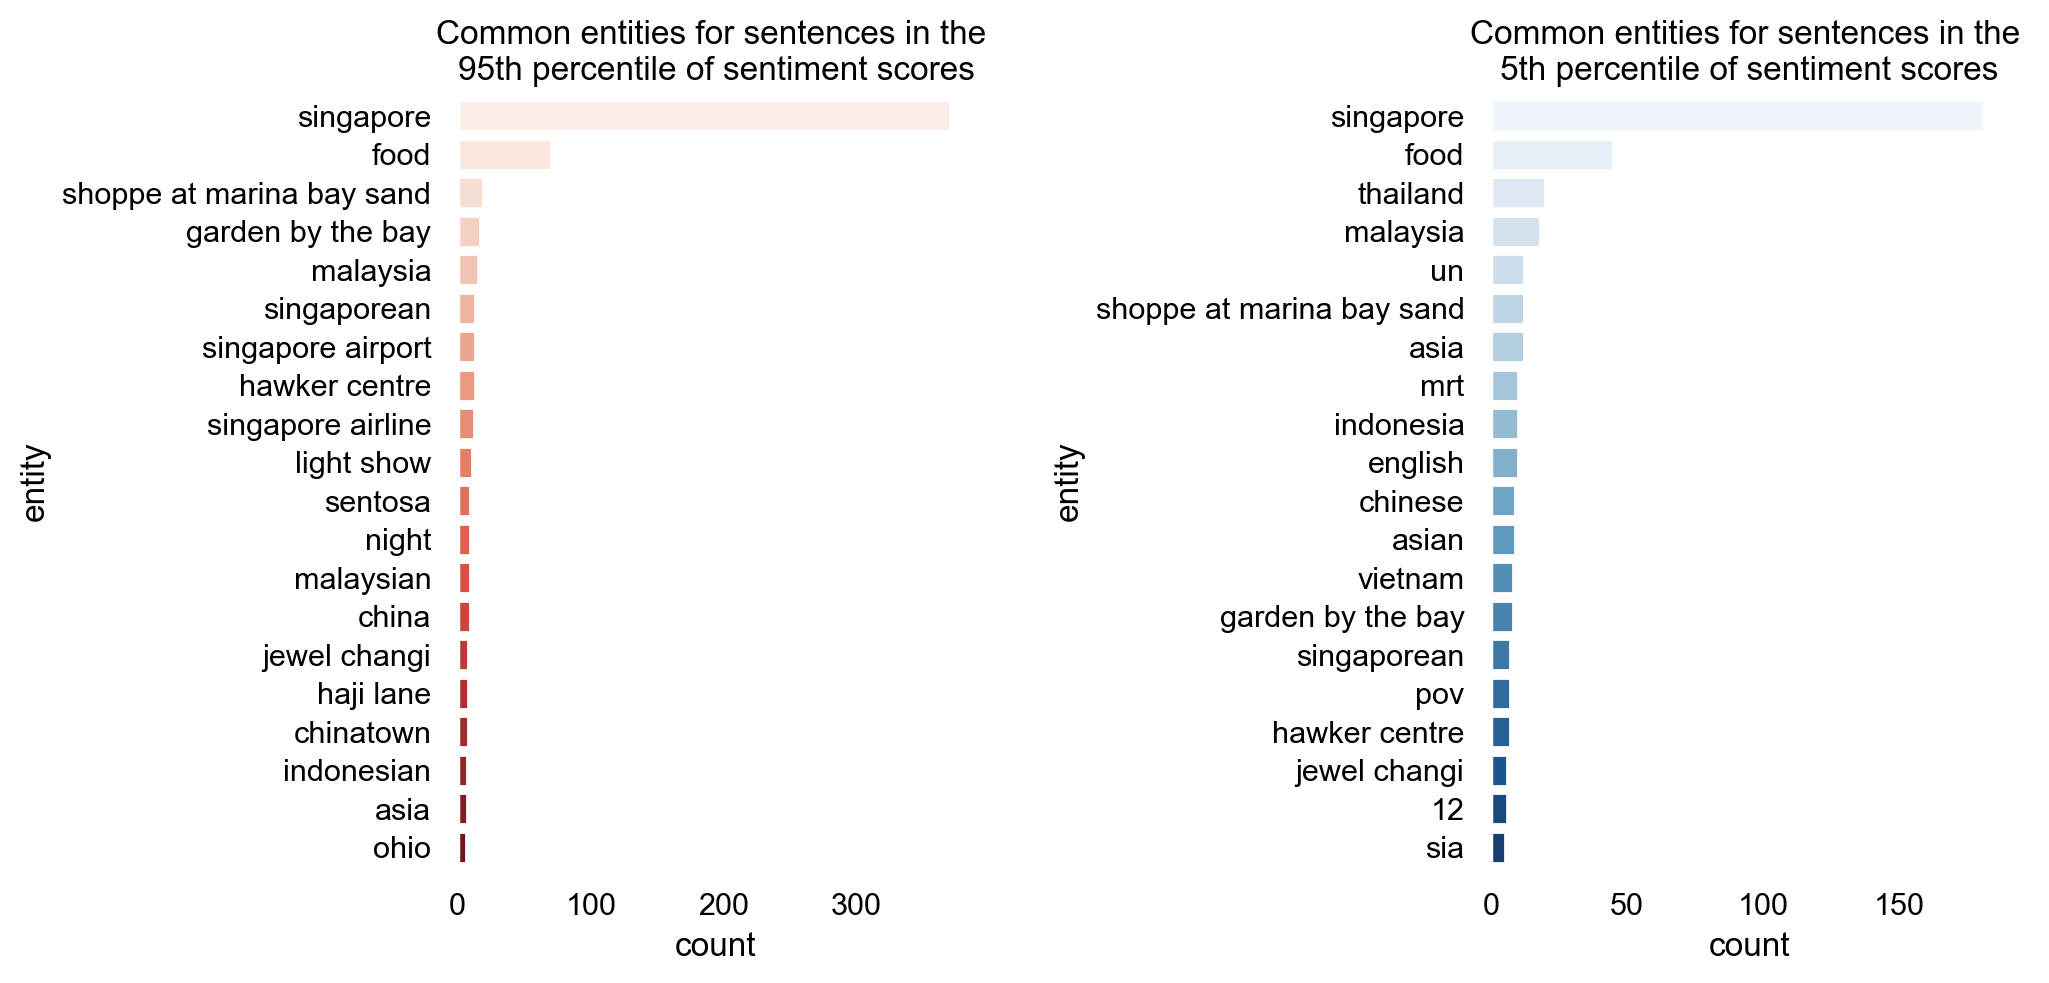

In [32]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
sns.barplot(data=word_counts_top_df.head(20),
            x='count',y='entity',
            ax=axes[0],
            palette='Reds').set(title='Common entities for sentences in the \n95th percentile of sentiment scores')
sns.barplot(data=word_counts_bottom_df.head(20),
            x='count',y='entity',
            ax=axes[1],
            palette='Blues').set(title='Common entities for sentences in the \n5th percentile of sentiment scores')
# Adjust the subplot layout parameters
fig.subplots_adjust(hspace=1.0, wspace=1.0)

In [19]:
# convert string of list back to a list
train_df['entity'] = train_df['entity'].map(lambda x: ast.literal_eval(x))
train_df['pos_sentiment_words'] = train_df['pos_sentiment_words'].map(lambda x: ast.literal_eval(x))
train_df['neg_sentiment_words'] = train_df['neg_sentiment_words'].map(lambda x: ast.literal_eval(x))

In [20]:
list_of_lists_top = [entities for entities in top_sentences['entity']]

This does not give us much information which is not surprising. As mentioned above, since tourists typically gravitate towards popular tourist locations, the frequency of mentions for these attractions remains high, irrespective of whether the tourists' eventual sentiment scores are low or high.

In [21]:
list_of_lists_top

[['48 hour', 'singapore'],
 [],
 [],
 ['singapore airlines'],
 [],
 [],
 [],
 ['the good 48 hour'],
 [],
 [],
 [],
 ['food'],
 [],
 ['bro', 'swedish'],
 ['indonesian'],
 ['singapore', 'first'],
 [],
 [],
 [],
 ['singapore'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['october 13', 'october 14', 'mag sg'],
 [],
 [],
 [],
 [],
 [],
 ['malaysian'],
 [],
 [],
 [],
 ['cebu pacific air the'],
 ['singapore airlines'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['singapore'],
 [],
 ['singapore'],
 [],
 [],
 ['hawker market'],
 [],
 ['17 year'],
 [],
 [],
 [],
 [],
 [],
 ['10'],
 [],
 [],
 [],
 ['singapore'],
 [],
 [],
 ['qatar'],
 ['sg airline good ngl'],
 ['shenzhen', 'tokyo'],
 ['one'],
 [],
 [],
 ['kyoto'],
 ['artscience museum'],
 [],
 [],
 [],
 [],
 [],
 ['singapore', 'first'],
 [],
 ['5 month',
  'singapore',
  'merlion park',
  'marina bay',
  'cable car',
  'garden by the bay',
  'night'],
 ['one', 'singapore'],
 [],
 [],
 ['singapore'],
 [],
 [],
 [],
 [],
 [],
 

Instead, we should calculate the Net Promoter Score (NPS) for each entity and compare NPS across different entities.

### Compare Net Promoter Score (NPS) across entities

#### Most commonly mentioned entities for sentences with sentiment scores that are in the 95th percentile (top 5%) vs those with sentiment scores that are in the 5th percentile (bottom 5%). 

NPS = % Promoters - % Detractors

Promoters: Respondents who give a rating of 9 or 10.

Passives: Respondents who give a rating of 7 or 8. 

Detractors: Respondents who give a rating of 0 to 6. 

[Text(0.5, 1.0, 'Distribution of Rating')]

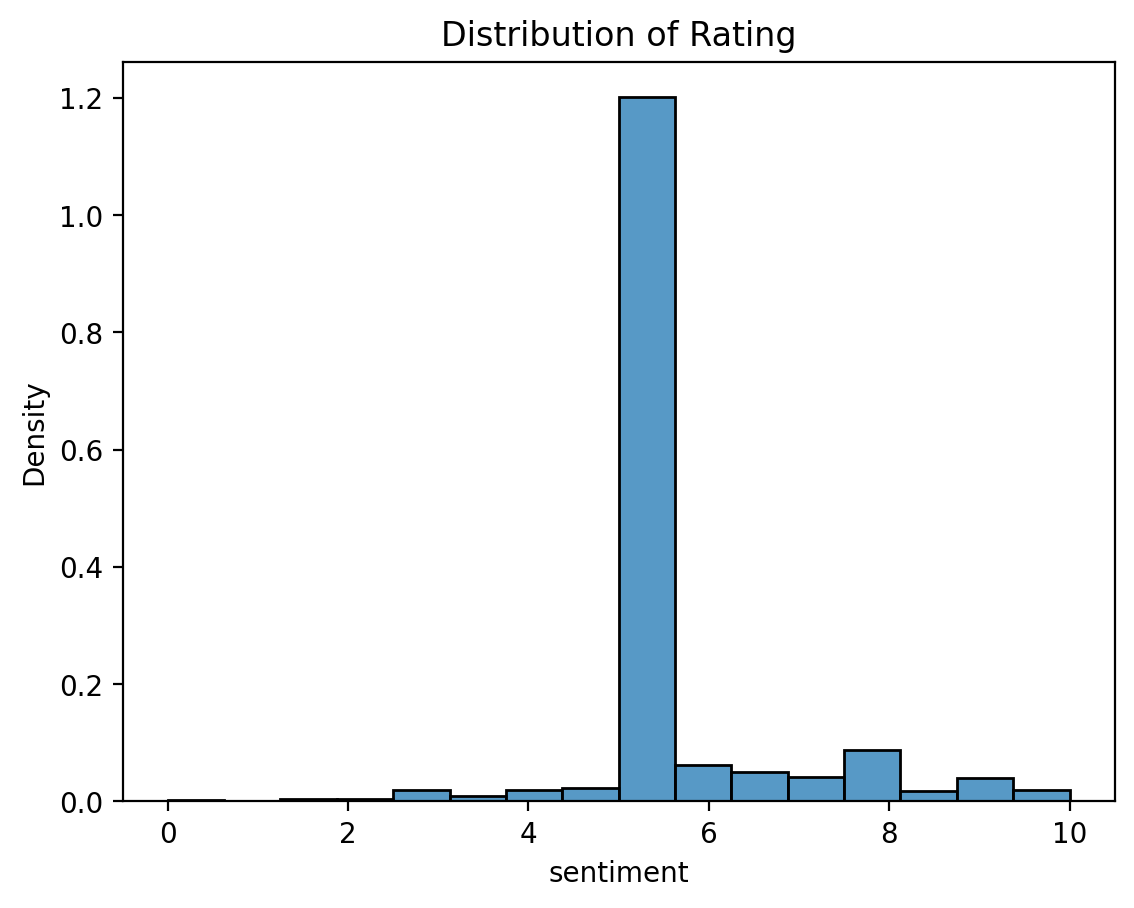

In [5]:
sns.histplot(data=train_df,x='sentiment', stat='density').set(title='Distribution of Rating')

In [6]:
# create function for statistical data
def normality(df, col):
    stat, p = shapiro(df[col])
    alpha = 0.07
    nl = '\n'
    if p > alpha:
        return f"p: {p}{nl}Since p > {alpha}, it cannot be concluded that {col} does not follow a normal distribution (fail to reject H0)"
    else:
        return f"p: {p}{nl}Since p <= {alpha}, it can be concluded that {col} does not follow a normal distribution (reject H0)"
      

def skewness(df,col):
    if skew(df[col]) == 0:
        pos_neg='not'
    elif skew(df[col]) > 0:
        pos_neg='positively'
    else:
        pos_neg='negatively'
    return f"Distribution of {col} is {pos_neg} skewed, with skew at: {skew(df[col])}"

def statistical_data(df,col):
    nl = '\n'
    return print(f"Statistical Data for {col}\nMean: {df[col].mean()}{nl}Standard Deviation: {df[col].std()}{nl}{normality(df, col)}{nl}{skewness(df,col)}")

In [7]:
statistical_data(train_df, 'sentiment')

Statistical Data for sentiment
Mean: 5.416148336753535
Standard Deviation: 1.2085739803421407
p: 0.0
Since p <= 0.07, it can be concluded that sentiment does not follow a normal distribution (reject H0)
Distribution of sentiment is positively skewed, with skew at: 1.4895377698252081


/Users/edenng/anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [8]:
train_df['sentiment'] = (train_df['sentiment'])**(1 / 1.1)

#### Create a dataframe where each entity (that appears in the scrapped dataset and `sg_entities_patterns_df`) has its own NPS. This dataframe will also have additional information such as positive and negative sentiment words frequently mentioned together with said entity.

In [23]:
list_of_lists_top

NameError: name 'list_of_lists_top' is not defined

In [33]:
# generate a list of all entities mentioned
list_of_lists_all = [entities for entities in train_df['entity']]

unique_entities_count = {}

# Loop through each sublist in the list of lists
for sublist in list_of_lists_all:
    # Loop through each string in the sublist
    for word in sublist:
        # need to swap out the word with the replacement from my other list
        # we will only keep entities that are in 'sg_entities_patterns_df'
        if word in sg_entities_patterns_df['pattern'].values:
            # find the row number in which this word is found
            row_num = (sg_entities_patterns_df.index[sg_entities_patterns_df['pattern'] == word])[0]
            # replace word with value in 'sublocation'
            word = sg_entities_patterns_df['sublocation'][row_num]
            if word not in remove_entities:
                # Update the count in the dictionary                 
                unique_entities_count[word] = unique_entities_count.get(word, 0) + 1
        

In [34]:
# save entity and its corresponding count in a dataframe
unique_entities_count_df = {'entity': [],'count': []}
for k,v in unique_entities_count.items():
    unique_entities_count_df['entity'].append(k)
    unique_entities_count_df['count'].append(v)
unique_entities_count_df = pd.DataFrame(unique_entities_count_df)

In [35]:
# add new columns
unique_entities_count_df['promoter_count'] = 0
unique_entities_count_df['detractor_count'] = 0
unique_entities_count_df['total_count'] = 0
unique_entities_count_df['pos_sentiment_words'] = 0
unique_entities_count_df['neg_sentiment_words'] = 0
unique_entities_count_df['interest_1'] = ''
unique_entities_count_df['interest_2'] = ''
unique_entities_count_df['indoor_outdoor'] = ''
# empty list function
def create_empty_list():
    return []

# Apply the function to each cell
unique_entities_count_df['pos_sentiment_words'] = unique_entities_count_df['pos_sentiment_words'].apply(lambda x: create_empty_list())
unique_entities_count_df['neg_sentiment_words'] = unique_entities_count_df['neg_sentiment_words'].apply(lambda x: create_empty_list())

unique_entities_count_df.head(20)

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor
0,singapore airport,43,0,0,0,[],[],,,
1,future world exhibition,8,0,0,0,[],[],,,
2,artscience museum,22,0,0,0,[],[],,,
3,garden by the bay,127,0,0,0,[],[],,,
4,skyway,10,0,0,0,[],[],,,
5,floral fantasy,10,0,0,0,[],[],,,
6,light show,59,0,0,0,[],[],,,
7,fort canning,13,0,0,0,[],[],,,
8,arab street,21,0,0,0,[],[],,,
9,food,356,0,0,0,[],[],,,


In [36]:
# calculate nps for each entity
for index, entities in enumerate(train_df['entity']):
    # extract the positive and negative sentiment words as a list
    pos_list = train_df['pos_sentiment_words'].loc[index]
    neg_list = train_df['neg_sentiment_words'].loc[index]
    for entity in entities:
        # we only want the locations mentioned in sg_entities_patterns_df
        if entity in sg_entities_patterns_df['pattern'].values:
            # find the row number in which this word is found
            row_num = (sg_entities_patterns_df.index[sg_entities_patterns_df['pattern'] == entity])[0]
            # replace word with value in 'sublocation'
            entity = sg_entities_patterns_df['sublocation'][row_num]        
            # find the row in which this entity is saved in for unique_entities_count_df
            row_num = (unique_entities_count_df.index[unique_entities_count_df['entity'] == entity])
            unique_entities_count_df['total_count'].loc[row_num] = unique_entities_count_df['total_count'].loc[row_num] + 1
            
            # save the extracted pos and neg words in a list
            unique_entities_count_df['pos_sentiment_words'].loc[row_num[0]] = pos_list + unique_entities_count_df['pos_sentiment_words'].loc[row_num[0]]
            unique_entities_count_df['neg_sentiment_words'].loc[row_num[0]] = neg_list + unique_entities_count_df['neg_sentiment_words'].loc[row_num[0]]
            
            # add to the respective count if the sentence is a promoter / detractor
            if train_df['sentiment'].loc[index] >= 9:
                unique_entities_count_df['promoter_count'].loc[row_num] = unique_entities_count_df['promoter_count'].loc[row_num] + 1
            elif train_df['sentiment'].loc[index] < 6:
                unique_entities_count_df['detractor_count'].loc[row_num] = unique_entities_count_df['detractor_count'].loc[row_num] + 1

/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_95366/2198707034.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['total_count'].loc[row_num] = unique_entities_count_df['total_count'].loc[row_num] + 1
/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_95366/2198707034.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['pos_sentiment_words'].loc[row_num[0]] = pos_list + unique_entities_count_df['pos_sentiment_words'].loc[row_num[0]]
/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_95366/2198707034.py:19: SettingWithCopyWarning: 
A value

In [37]:
# nps formula
unique_entities_count_df['nps'] = ((unique_entities_count_df['promoter_count'] - unique_entities_count_df['detractor_count']) / unique_entities_count_df['count']) * 100

In [38]:
unique_entities_count_df.head(20)

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor,nps
0,singapore airport,43,4,0,43,"[amazing, whole, best, live, awesome, love, fa...","[spent, crying, impossible, spent, down, long,...",,,,9.302326
1,future world exhibition,8,0,2,8,"[best, absolutely, beautiful, best, better, be...","[mean, mean, down, chicken, mean, hidden, bad,...",,,,-25.000000
2,artscience museum,22,1,1,22,"[cool, free, top, absolutely, amazing, really,...","[few, tight, little, down, other, expensive]",,,,0.000000
3,garden by the bay,127,3,4,127,"[loved, most, popular, real, free, gorgeous, l...","[closed, closed, sorry, spent, other, unbeliev...",,,,-0.787402
4,skyway,10,0,1,10,"[best, absolutely, beautiful, best, better, be...","[mean, mean, down, chicken, mean, hidden, bad,...",,,,-10.000000
5,floral fantasy,10,0,0,10,"[new, far, bright, famous, colorful, top, most...","[few, insane]",,,,0.000000
6,light show,59,1,2,59,"[cheap, better, free, free, amazing, beautiful...","[fucking, harder, expensive, fucking, down, do...",,,,-1.694915
7,fort canning,13,0,1,13,"[nice, straight, completely, free, early, most...",[expensive],,,,-7.692308
8,arab street,21,0,2,21,"[hahaha, free, free, free, certain, free, free...","[down, expensive]",,,,-9.523810
9,food,356,11,30,356,"[amazing, cool, pretty, amazing, amazing, lol,...","[expensive, due, expensive, seriously, fucking...",,,,-5.337079


#### Add additional columns that provide more context to the entity such as the type of tourist attraction (amusement park, shopping, museum, etc.) and whether it is an indoor or outdoor attraction

In [39]:
# add the 'interest_1', 'interest_2' and 'indoor_outdoor' info to the dataframe
for index, entity in enumerate(unique_entities_count_df['entity']):
    # find the matching entity in 'sg_entities_patterns_df' and get the row_num
    row_num = sg_entities_patterns_df.index[sg_entities_patterns_df['sublocation'] == entity][0]
    unique_entities_count_df['interest_1'].loc[index] = sg_entities_patterns_df['interest_1'].loc[row_num]
    unique_entities_count_df['interest_2'].loc[index] = sg_entities_patterns_df['interest_2'].loc[row_num]
    unique_entities_count_df['indoor_outdoor'].loc[index] = sg_entities_patterns_df['indoor_outdoor'].loc[row_num]

unique_entities_count_df

/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_95366/3074340239.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['interest_1'].loc[index] = sg_entities_patterns_df['interest_1'].loc[row_num]
/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_95366/3074340239.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['interest_2'].loc[index] = sg_entities_patterns_df['interest_2'].loc[row_num]
/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_95366/3074340239.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor,nps
0,singapore airport,43,4,0,43,"[amazing, whole, best, live, awesome, love, fa...","[spent, crying, impossible, spent, down, long,...",transport,recreation,indoor,9.302326
1,future world exhibition,8,0,2,8,"[best, absolutely, beautiful, best, better, be...","[mean, mean, down, chicken, mean, hidden, bad,...",art,NaN,indoor,-25.000000
2,artscience museum,22,1,1,22,"[cool, free, top, absolutely, amazing, really,...","[few, tight, little, down, other, expensive]",museum,NaN,indoor,0.000000
3,garden by the bay,127,3,4,127,"[loved, most, popular, real, free, gorgeous, l...","[closed, closed, sorry, spent, other, unbeliev...",nature,architecture,outdoor,-0.787402
4,skyway,10,0,1,10,"[best, absolutely, beautiful, best, better, be...","[mean, mean, down, chicken, mean, hidden, bad,...",architecture,nature,outdoor,-10.000000
...,...,...,...,...,...,...,...,...,...,...,...
156,people park centre,1,0,0,1,[],[],shopping,NaN,indoor,0.000000
157,suntec city,1,0,0,1,[],[],shopping,NaN,indoor,0.000000
158,beauty world centre,1,0,0,1,[top],[],shopping,NaN,indoor,0.000000
159,nex,1,0,0,1,[],[],shopping,NaN,indoor,0.000000


#### Change the list of sentiment words into a dictionary instead so that it will be easier to visualize later.

In [40]:
# for positive words
for index, list_of_strings in enumerate(unique_entities_count_df['pos_sentiment_words']):
    dictionary = {}
    final_dict = {'sentiment_word': [],'count': []}
    for sentiment_word in list_of_strings:
        dictionary[sentiment_word] = dictionary.get(sentiment_word,0) + 1
    for k, v in dictionary.items():
        final_dict['sentiment_word'].append(k)
        final_dict['count'].append(v)
    # save in the cell
    unique_entities_count_df['pos_sentiment_words'][index] = final_dict
    
# for negative words
for index, list_of_strings in enumerate(unique_entities_count_df['neg_sentiment_words']):
    dictionary = {}
    final_dict = {'sentiment_word': [],'count': []}
    for sentiment_word in list_of_strings:
        dictionary[sentiment_word] = dictionary.get(sentiment_word,0) + 1
    for k, v in dictionary.items():
        final_dict['sentiment_word'].append(k)
        final_dict['count'].append(v)
    # save in the cell
    unique_entities_count_df['neg_sentiment_words'][index] = final_dict

/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_95366/949506435.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['pos_sentiment_words'][index] = final_dict
/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_95366/949506435.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['neg_sentiment_words'][index] = final_dict


### Feature Engineering

In [41]:
unique_entities_count_df

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor,nps
0,singapore airport,43,4,0,43,"{'sentiment_word': ['amazing', 'whole', 'best'...","{'sentiment_word': ['spent', 'crying', 'imposs...",transport,recreation,indoor,9.302326
1,future world exhibition,8,0,2,8,"{'sentiment_word': ['best', 'absolutely', 'bea...","{'sentiment_word': ['mean', 'down', 'chicken',...",art,NaN,indoor,-25.000000
2,artscience museum,22,1,1,22,"{'sentiment_word': ['cool', 'free', 'top', 'ab...","{'sentiment_word': ['few', 'tight', 'little', ...",museum,NaN,indoor,0.000000
3,garden by the bay,127,3,4,127,"{'sentiment_word': ['loved', 'most', 'popular'...","{'sentiment_word': ['closed', 'sorry', 'spent'...",nature,architecture,outdoor,-0.787402
4,skyway,10,0,1,10,"{'sentiment_word': ['best', 'absolutely', 'bea...","{'sentiment_word': ['mean', 'down', 'chicken',...",architecture,nature,outdoor,-10.000000
...,...,...,...,...,...,...,...,...,...,...,...
156,people park centre,1,0,0,1,"{'sentiment_word': [], 'count': []}","{'sentiment_word': [], 'count': []}",shopping,NaN,indoor,0.000000
157,suntec city,1,0,0,1,"{'sentiment_word': [], 'count': []}","{'sentiment_word': [], 'count': []}",shopping,NaN,indoor,0.000000
158,beauty world centre,1,0,0,1,"{'sentiment_word': ['top'], 'count': [1]}","{'sentiment_word': [], 'count': []}",shopping,NaN,indoor,0.000000
159,nex,1,0,0,1,"{'sentiment_word': [], 'count': []}","{'sentiment_word': [], 'count': []}",shopping,NaN,indoor,0.000000


#### Visualize most frequently mentioned entities and their corresponding NPS score

In [7]:
train_df.head()

,post_comment,id,sentence,entity,pos_sentiment_words,neg_sentiment_words,textblob,sentiment
0,post,0_post,how to spend the perfect 48 hours in singapore,"[48 hour, singapore]",['perfect'],[],1.000000,10.000000
1,post,0_post,first head to your waterfall at singapore airp...,"[first, singapore airport]","['absolutely', 'incredible']",[],0.900000,9.500000
2,post,0_post,then head to the center and drop by the future...,"[future world exhibition, art science museum]",[],[],0.000000,5.000000
3,post,0_post,next you have to head to gardens by the bay it...,[garden by the bay],"['completely', 'free', 'amazing']",[],0.333333,6.666667
4,post,0_post,dont forget to buy tickets for the skyway for ...,"[skyway, floral fantasy]","['most', 'magical']",['insane'],0.000000,5.000000


In [ ]:
sg_entities_patterns_df

In [48]:
a = 'garden by the bay'
if a in sg_entities_patterns_df['sublocation'].values:
    row_numbers = (sg_entities_patterns_df['sublocation'] == a).idxmax()
    print(row_numbers)

129


In [49]:
sg_entities_patterns_df['sublocation'][129]

'garden by the bay'

In [94]:
pct = 0.2
rows = len(train_df)
round(rows * pct)

6265

In [42]:
unique_entities_count_df.head(30)

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor,nps
0,singapore airport,43,4,0,43,"{'sentiment_word': ['amazing', 'whole', 'best'...","{'sentiment_word': ['spent', 'crying', 'imposs...",transport,recreation,indoor,9.302326
1,future world exhibition,8,0,2,8,"{'sentiment_word': ['best', 'absolutely', 'bea...","{'sentiment_word': ['mean', 'down', 'chicken',...",art,NaN,indoor,-25.000000
2,artscience museum,22,1,1,22,"{'sentiment_word': ['cool', 'free', 'top', 'ab...","{'sentiment_word': ['few', 'tight', 'little', ...",museum,NaN,indoor,0.000000
3,garden by the bay,127,3,4,127,"{'sentiment_word': ['loved', 'most', 'popular'...","{'sentiment_word': ['closed', 'sorry', 'spent'...",nature,architecture,outdoor,-0.787402
4,skyway,10,0,1,10,"{'sentiment_word': ['best', 'absolutely', 'bea...","{'sentiment_word': ['mean', 'down', 'chicken',...",architecture,nature,outdoor,-10.000000
5,floral fantasy,10,0,0,10,"{'sentiment_word': ['new', 'far', 'bright', 'f...","{'sentiment_word': ['few', 'insane'], 'count':...",nature,architecture,indoor,0.000000
6,light show,59,1,2,59,"{'sentiment_word': ['cheap', 'better', 'free',...","{'sentiment_word': ['fucking', 'harder', 'expe...",art,NaN,outdoor,-1.694915
7,fort canning,13,0,1,13,"{'sentiment_word': ['nice', 'straight', 'compl...","{'sentiment_word': ['expensive'], 'count': [1]}",park,heritage,outdoor,-7.692308
8,arab street,21,0,2,21,"{'sentiment_word': ['hahaha', 'free', 'certain...","{'sentiment_word': ['down', 'expensive'], 'cou...",culture,NaN,outdoor,-9.523810
9,food,356,11,30,356,"{'sentiment_word': ['amazing', 'cool', 'pretty...","{'sentiment_word': ['expensive', 'due', 'serio...",food and drinks,NaN,indoor,-5.337079


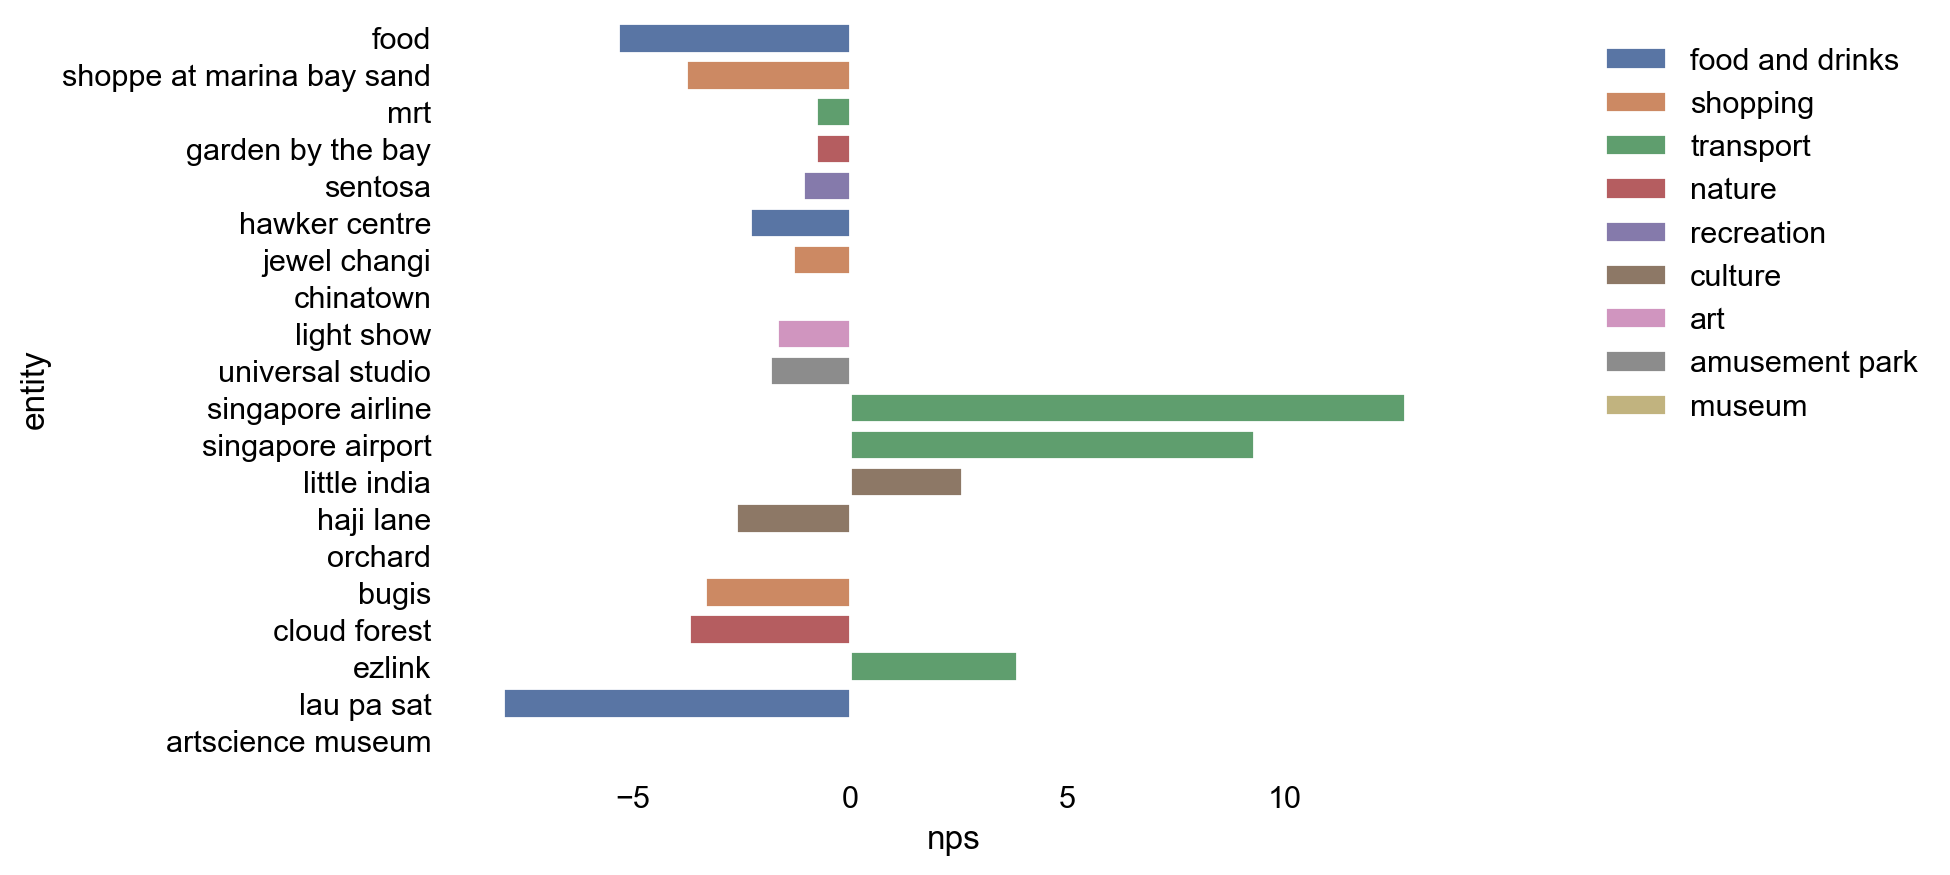

In [43]:
# sort by count
unique_entities_count_df = unique_entities_count_df.sort_values(by=['count','nps','entity'],
                                                                ascending=False)
sns.barplot(data=unique_entities_count_df.head(20),x='nps',y='entity', 
            hue='interest_1',
            dodge=False)

plt.legend(frameon=False,loc='upper right',bbox_to_anchor=(1.5, 1))

<Axes: xlabel='nps', ylabel='interest_1'>

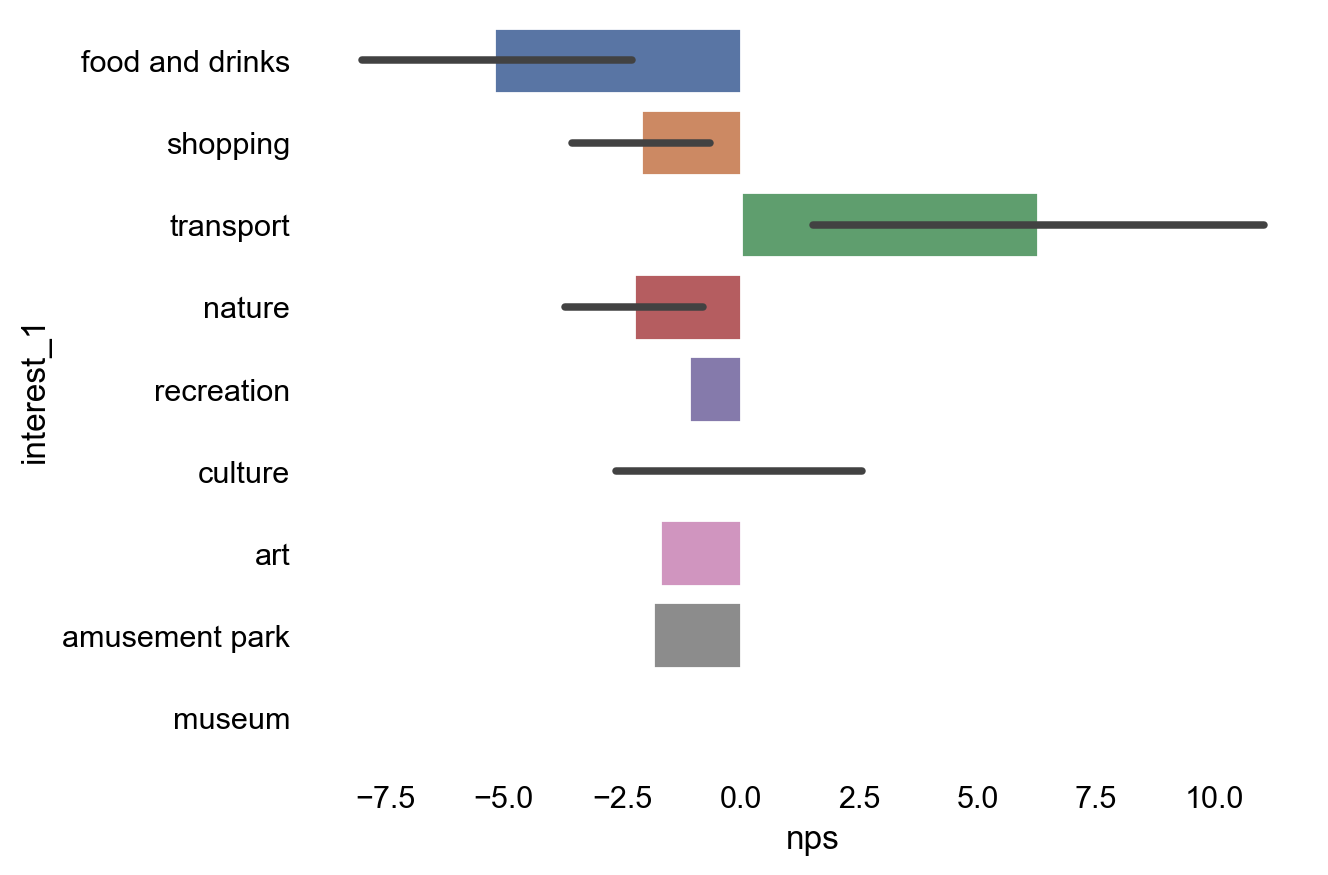

In [44]:
sns.barplot(data=unique_entities_count_df.head(20),x='nps',y='interest_1')

The analysis reveals notable variations in the Net Promoter Scores (NPS) across different entity categories. Specifically, 'transport' related entities exhibit significantly higher NPS ratings, whereas 'food and drinks' related entities demonstrate comparatively lower NPS values. On the other hand, entities related to culture, museums, and recreation tend to show a more neutral NPS sentiment.

This observation finds partial validation in the unigram and bigram analyses, where sentences mentioning aspects like 'Singapore airline' and 'airport' ('transport') receive notably high sentiment scores.

In the subsequent section, we will delve into the frequently mentioned positive and negative sentiment words to see if we can further explain factors contributing to the aforementioned NPS.

### Extract positive and negative sentiment words

In [130]:
top_sentences = train_df[train_df['sentiment'] > 6]
list_of_lists_top = [entities for entities in top_sentences['entity']]

word_counts_top = {}

# Loop through each sublist in the list of lists
for sublist in list_of_lists_top:
    # Loop through each string in the sublist
    for word in sublist:
        # need to swap out the word with the replacement from my other list
        if word in sg_entities_patterns_df['pattern'].values:
            # find the row number in which this word is found
            row_num = (sg_entities_patterns_df['pattern'] == word).idxmax()
            # replace word with value in 'sublocation'
            word = sg_entities_patterns_df['sublocation'][row_num]
        # Update the count in the dictionary
        word_counts_top[word] = word_counts_top.get(word, 0) + 1
        
word_counts_top

{'48 hour': 3,
 'singapore': 624,
 'first': 51,
 'singapore airport': 15,
 'garden by the bay': 49,
 'light show': 28,
 'one': 65,
 'fort canning': 3,
 'arab street': 6,
 'food': 154,
 'sultan mosque': 4,
 'five': 7,
 'hawker centre': 28,
 'spring': 1,
 'cloud forest': 13,
 'flower dome': 5,
 'night show': 2,
 'shoppe at marina bay sand': 49,
 'raffle hotel': 6,
 'british': 3,
 'long bar': 2,
 'sky garden': 2,
 'capitaspring': 1,
 'level 33': 3,
 '20': 6,
 'merlion park': 9,
 'fountain show': 2,
 'skypark': 2,
 'chinatown': 23,
 'only eight pound': 1,
 'capitol spring': 1,
 'only four pound': 1,
 'supertree grove': 7,
 'national orchid garden': 1,
 'rm52': 1,
 'macritchie treetop walk': 1,
 'changi': 5,
 'large indoor waterfall': 2,
 'three': 8,
 'sea aquarium': 5,
 'skyway': 3,
 'jewel changi airport': 3,
 'two': 17,
 '6 minute': 1,
 '1': 24,
 '86 meter': 1,
 'terminal 4': 1,
 'about six and a half hour': 1,
 'singapore zoo': 5,
 'universal studio': 11,
 'the end of the day': 1,
 'haj

#### Create 2 new dataframes that contain positive and negative sentiment words and the corresponding count

In [98]:
top_sentences

,post_comment,id,sentence,entity,pos_sentiment_words,neg_sentiment_words,textblob,sentiment
0,post,0_post,how to spend the perfect 48 hours in singapore,"[48 hour, singapore]",['perfect'],[],1.0,10.0
16338,post,241_cmt,they are truly the best,[],['best'],[],1.0,10.0
21535,post,317_cmt,s the best airport ever,[],['best'],[],1.0,10.0
21301,post,315_cmt,singapore airlines is the best company in the ...,[singapore airlines],['best'],[],1.0,10.0
21296,post,315_cmt,best the emirates airline,[],['best'],[],1.0,10.0
...,...,...,...,...,...,...,...,...
28561,post,426_cmt,m glad you enjoyed,[],"['glad', 'enjoyed']",[],0.5,7.5
15385,post,220_cmt,hi are you able to share how you notarized,[],['able'],[],0.5,7.5
147,post,28_post,follow me for more travel content i,[],['more'],[],0.5,7.5
15428,post,220_cmt,gonna have way better life than here,[],['better'],[],0.5,7.5


In [45]:
# new dictionary
pos_sentiment_words_dict = {'sentiment_word':[],'count':[]}
neg_sentiment_words_dict = {'sentiment_word':[],'count':[]}

In [46]:
# for positive words
for index, interest_1 in enumerate(unique_entities_count_df['pos_sentiment_words']):
    # Add pos_sentiment_words_dict to the combined_dict
    combined_dict = pos_sentiment_words_dict

    # Add counts from unique_entities_count_df['pos_sentiment_words'][index] to the combined_dict
    add_counts(unique_entities_count_df['pos_sentiment_words'][index]['sentiment_word'], unique_entities_count_df['pos_sentiment_words'][index]['count'],combined_dict)

    # save the combined_dict in pos_sentiment_words_dict
    pos_sentiment_words_dict = combined_dict

# save as dataframe
pos_sentiment_words_df = pd.DataFrame(pos_sentiment_words_dict)

NameError: name 'add_counts' is not defined

### Extract positive and negative sentiment words

In [59]:
# new dictionary
pos_sentiment_words_dict = {'sentiment_word':[],'count':[]}
neg_sentiment_words_dict = {'sentiment_word':[],'count':[]}

In [60]:
# for positive words
for index, interest_1 in enumerate(unique_entities_count_df['pos_sentiment_words']):
    # Add pos_sentiment_words_dict to the combined_dict
    combined_dict = pos_sentiment_words_dict

    # Add counts from unique_entities_count_df['pos_sentiment_words'][index] to the combined_dict
    add_counts(unique_entities_count_df['pos_sentiment_words'][index]['sentiment_word'], unique_entities_count_df['pos_sentiment_words'][index]['count'],combined_dict)

    # save the combined_dict in pos_sentiment_words_dict
    pos_sentiment_words_dict = combined_dict

# save as dataframe
pos_sentiment_words_df = pd.DataFrame(pos_sentiment_words_dict)

In [63]:
# for negitive words
for index, interest_1 in enumerate(unique_entities_count_df['neg_sentiment_words']):
    # Add pos_sentiment_words_dict to the combined_dict
    combined_dict = neg_sentiment_words_dict

    # Add counts from unique_entities_count_df['neg_sentiment_words'][index] to the combined_dict
    add_counts(unique_entities_count_df['neg_sentiment_words'][index]['sentiment_word'], unique_entities_count_df['neg_sentiment_words'][index]['count'],combined_dict)

    # save the combined_dict in neg_sentiment_words_dict
    neg_sentiment_words_dict = combined_dict

# save as dataframe
neg_sentiment_words_df = pd.DataFrame(neg_sentiment_words_dict)

In [67]:
pos_sentiment_words_df = pos_sentiment_words_df.sort_values(by=['count'],ascending=False)
neg_sentiment_words_df = neg_sentiment_words_df.sort_values(by=['count'],ascending=False)

#### Visualize the positive and negative sentiment words commonly mentioned

<Axes: xlabel='count', ylabel='sentiment_word'>

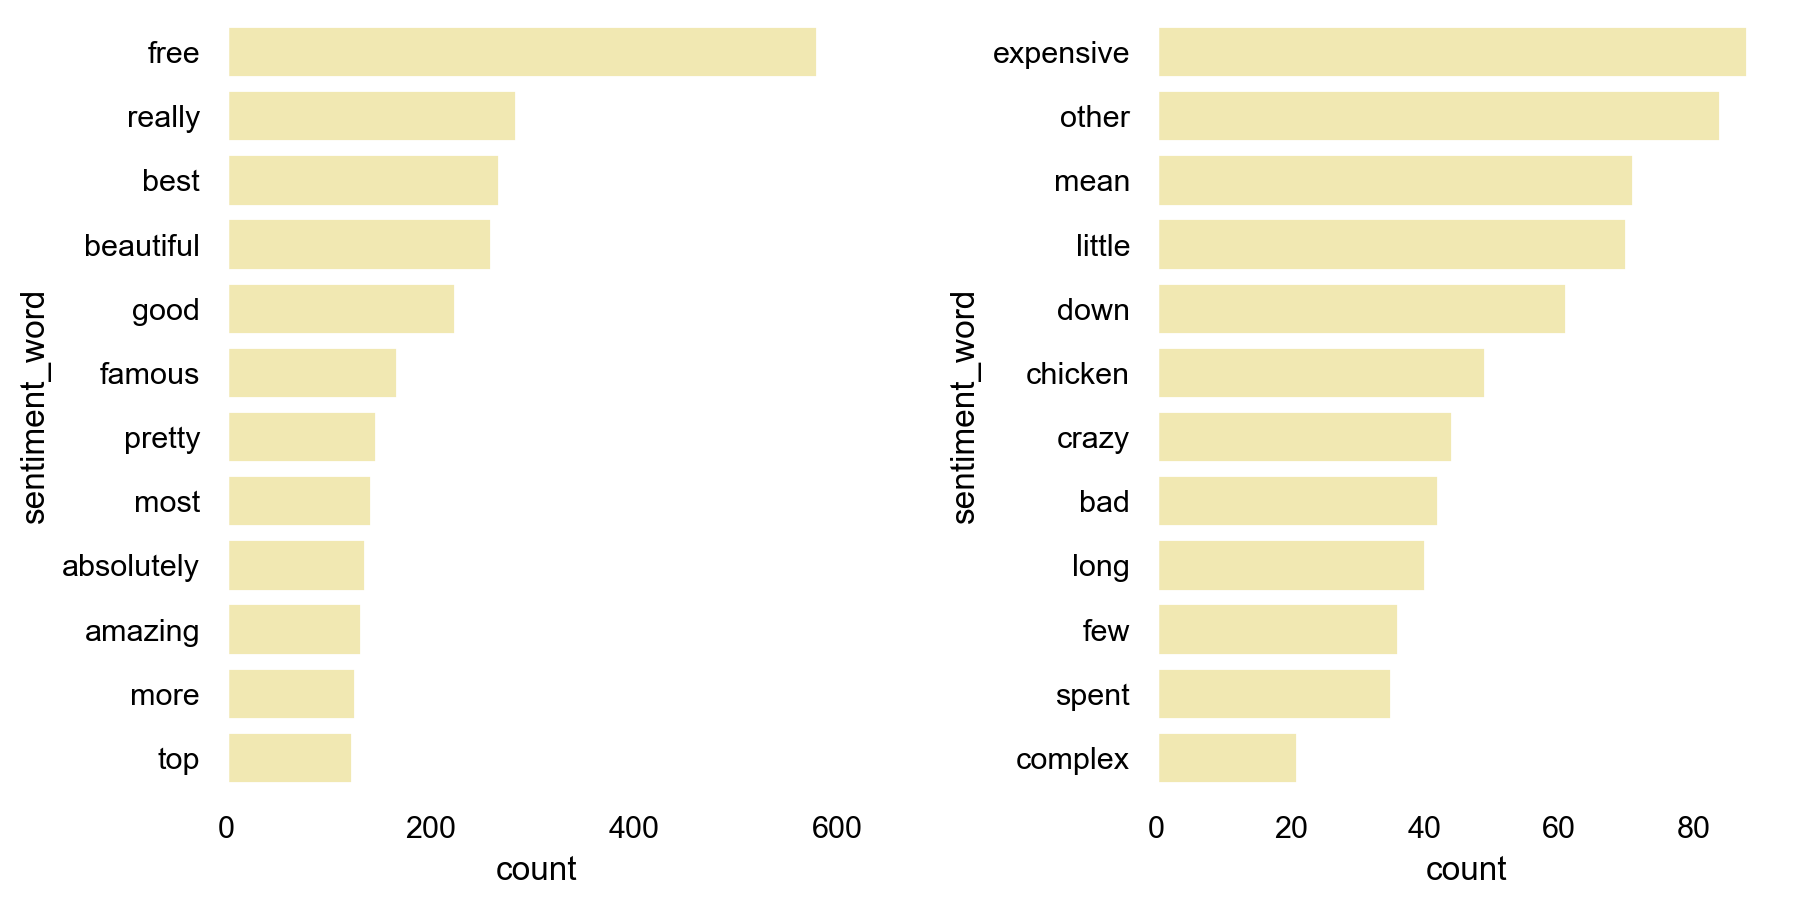

In [74]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.5)

sns.barplot(data=pos_sentiment_words_df.head(12),
            x='count',y='sentiment_word',
            ax=axes[0],
           color='#fcefa7',)
sns.barplot(data=neg_sentiment_words_df.head(12),
            x='count',y='sentiment_word',
            ax=axes[1],
           color='#fcefa7',)

In [ ]:
# for negitive words
for index, interest_1 in enumerate(unique_entities_count_df['neg_sentiment_words']):
    # Add pos_sentiment_words_dict to the combined_dict
    combined_dict = neg_sentiment_words_dict

    # Add counts from unique_entities_count_df['neg_sentiment_words'][index] to the combined_dict
    add_counts(unique_entities_count_df['neg_sentiment_words'][index]['sentiment_word'], unique_entities_count_df['neg_sentiment_words'][index]['count'],combined_dict)

    # save the combined_dict in neg_sentiment_words_dict
    neg_sentiment_words_dict = combined_dict

# save as dataframe
neg_sentiment_words_df = pd.DataFrame(neg_sentiment_words_dict)

In [ ]:
pos_sentiment_words_df = pos_sentiment_words_df.sort_values(by=['count'],ascending=False)
neg_sentiment_words_df = neg_sentiment_words_df.sort_values(by=['count'],ascending=False)

#### Visualize the positive and negative sentiment words commonly mentioned

In [ ]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.5)

sns.barplot(data=pos_sentiment_words_df.head(12),
            x='count',y='sentiment_word',
            ax=axes[0],
           palette='Reds',)
sns.barplot(data=neg_sentiment_words_df.head(12),
            x='count',y='sentiment_word',
            ax=axes[1],
           palette='Blues',)

As with the unigrams and bigrams analyses, favorable remarks highlights Singapore's beauty and pleasant ambiance, while unfavorable remarks center around its perceived expensiveness.  

Here we see that the top most mentioned positive and negative sentiment words are related: 'free' and 'expensive'.  This leads us to the conclusion that tourists visiting Singapore exhibit a strong sensitivity to pricing. Consequently, this explains the varying Net Promoter Scores (NPS) for different types of tourist attractions:- 

- The perceived high cost of living in Singapore contributes to lower NPS scores for interests like 'food and drinks' and 'shopping'. 

- Conversely, tourist attractions such as 'culture' and 'museum' tend to evoke more neutral scores. This is likely because while the attractions themselves are often free, the surrounding amenities may be costly. Additionally, museums often feature both free and paid sections, which could account for the neutral sentiment. 

- 'Transport', however, garners considerable appreciation from tourists, with numerous accolades lauding the Singapore airport and airlines as exemplary and among the best in the industry.

## Feature Engineering

#### As mentioned in EDA, the sentiment scores are skewed to the left. To reduce the skew, apply transformation.

In [ ]:
train_df['sentiment'] = (train_df['sentiment'])**(1 / 1.25)

In [54]:
# create function for statistical data
def normality(df, col):
    stat, p = shapiro(df[col])
    alpha = 0.07
    nl = '\n'
    if p > alpha:
        return f"p: {p}{nl}Since p > {alpha}, it cannot be concluded that {col} does not follow a normal distribution (fail to reject H0)"
    else:
        return f"p: {p}{nl}Since p <= {alpha}, it can be concluded that {col} does not follow a normal distribution (reject H0)"
      

def skewness(df,col):
    if skew(df[col]) == 0:
        pos_neg='not'
    elif skew(df[col]) > 0:
        pos_neg='positively'
    else:
        pos_neg='negatively'
    return f"Distribution of {col} is {pos_neg} skewed, with skew at: {skew(df[col])}"

def statistical_data(df,col):
    nl = '\n'
    return print(f"Statistical Data for {col}\nMean: {df[col].mean()}{nl}Standard Deviation: {df[col].std()}{nl}{normality(df, col)}{nl}{skewness(df,col)}")

In [ ]:
statistical_data(train_df, 'sentiment')

In [ ]:
statistical_data(train_df, 'sentiment')

In [ ]:
sns.histplot(data=train_df,
             x='sentiment',
             stat='density',
             color='#fcefa7',
            alpha=1.0).set(title='Distribution of Sentiment Score after Transformation')

Here, the skew in the data has been partially mitigated through a specific transformation. Although not entirely eliminated, this tailored approach has been fine-tuned to optimize both the R^2 and MSE scores.

## Scaling

#### Scale the data to a fixed range of 0 to 1

In [ ]:
# scale using minmax
# convert to array
y = train_df['sentiment'].array

mm = MinMaxScaler()
mm.fit(y.reshape(-1,1))
y = mm.transform(y.reshape(-1,1))

# convert back to dataframe
train_df['sentiment'] = pd.DataFrame(y)

In [85]:
statistical_data(train_df, 'sentiment')

Statistical Data for sentiment
Mean: 0.568996847474307
Standard Deviation: 0.11641254900708756
p: 0.0
Since p <= 0.07, it can be concluded that sentiment does not follow a normal distribution (reject H0)
Distribution of sentiment is positively skewed, with skew at: 1.330341558728993


/Users/edenng/anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


inverse_transform(X[, copy])

Scale back the data to the original representation.

[Text(0.5, 1.0, 'Distribution of Sentiment Score after Transformation')]

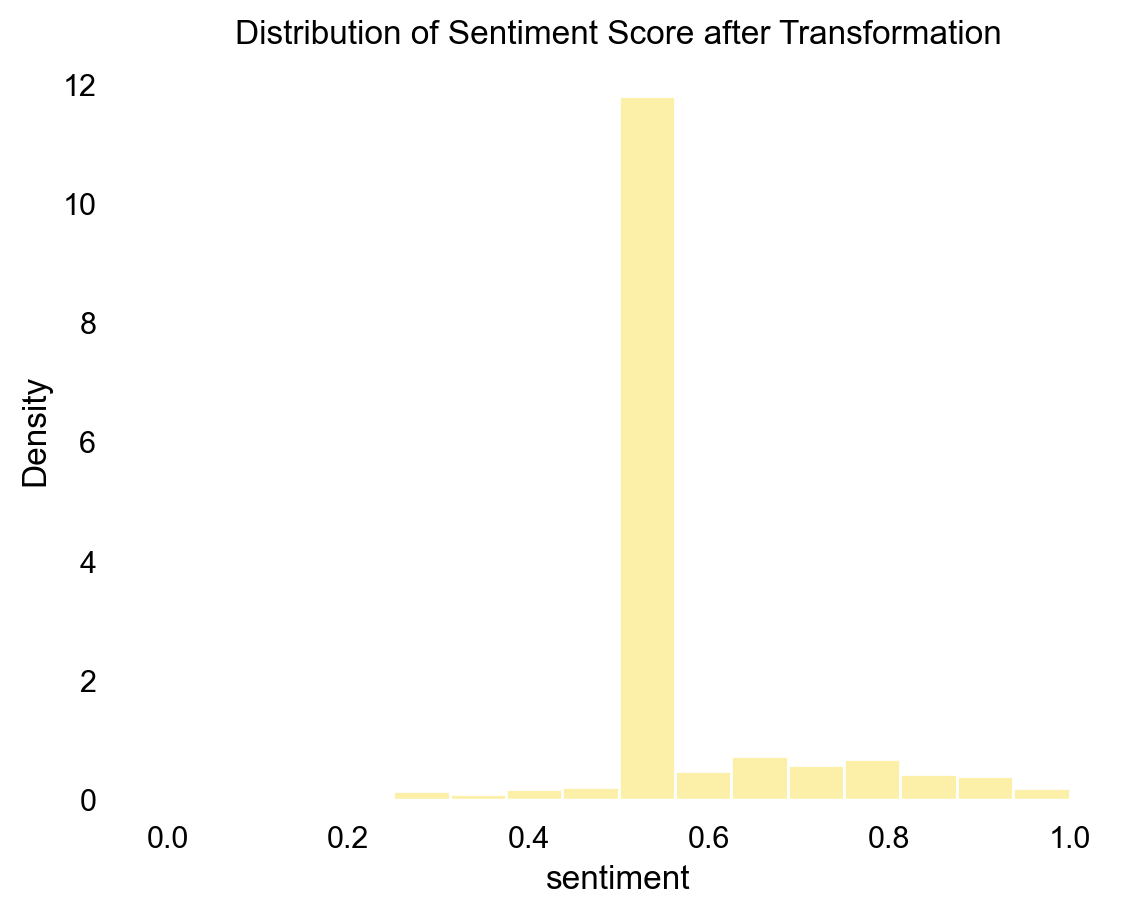

In [84]:
sns.histplot(data=train_df,
             x='sentiment',
             stat='density',
             color='#fcefa7',
            alpha=1.0).set(title='Distribution of Sentiment Score after Transformation')

## Train-Test-Split

#### Using train_test_split, the data will be split for training and testing 

In [ ]:
X = train_df['sentence']
y = train_df['sentiment']

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.78,random_state=42)

print(f'The X train set has {X_train.shape[0]} rows.')
print(f'The y train set has {y_train.shape[0]} rows.')
print(f'The X test set has {X_test.shape[0]} rows.')
print(f'The y test set has {y_test.shape[0]} rows.')

## Modeling

#### Kickstart the modeling process by fixing the random seed

### Distribution of sentiment score

[Text(0.5, 1.0, 'Distribution of Sentiment Score')]

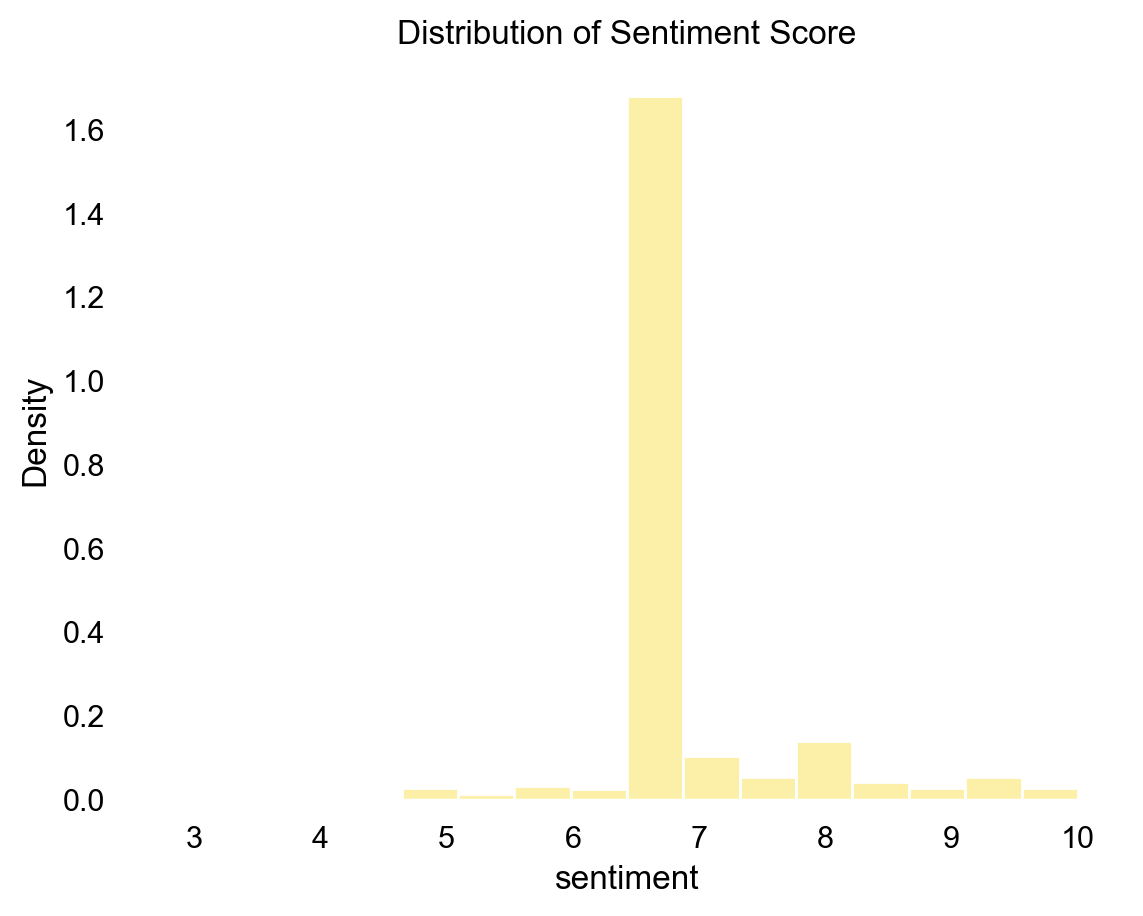

In [53]:
sns.histplot(data=train_df,
             x='sentiment',
             stat='density',
             color='#fcefa7',
            alpha=1.0).set(title='Distribution of Sentiment Score')

In [ ]:
tf.keras.utils.set_random_seed(1) 

#### Instantiate variables that will be used in the model. Some of these variables are tuned to optimize for R^2 and MSE scores.

In [ ]:
vocab_size = 9800
oov_token = "<OOV>"
padding_type = 'post'
trunc_type = 'post'
embedding_dim = 16 # 16
max_length = 200 # 100, 110

#### Define custom function to calculate R^2

In [ ]:
# define custom functions to calculate R2
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) # sum of squares of residuals
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) # total sum of squares
    # K.epsilon: Epsilon is small value that makes very little difference to the value of 
    # the denominator, but ensures that it isn't equal to exactly zero.
    r2_score = (1 - (SS_res / (SS_tot + K.epsilon())))
    return r2_score

#### Initialize and fit the tokenizer

In [ ]:
# initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_token)

# create tokens for every word in the corpus
tokenizer.fit_on_texts(X_train)

# save them in word_index
word_index = tokenizer.word_index

#### Turn sentences in both X_train and X_test into sequences of tokens and pad them

In [ ]:
# turn sentences into sequences of tokens
X_train_seq = tokenizer.texts_to_sequences(X_train)
# pad sentences so they are all the same length
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=max_length,
                                   padding=padding_type,truncating=trunc_type)

# do the same for X_test
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=max_length,
                                   padding=padding_type,truncating=trunc_type)

#### Build Model

In [ ]:
model = tf.keras.Sequential([
    # top layer is an embedding, where direction of each word will be learned epoch by epoch
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # we pool with a global average pooling, ie, adding up the vectors to get meaning
    tf.keras.layers.GlobalAveragePooling1D(),
    # this is then fed into deep neural network
    tf.keras.layers.Dense(96, 
                          activation='relu',
                          kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., 
                                                                                  stddev=2.)),
    tf.keras.layers.Dense(64, 
                          activation='relu'),
    tf.keras.layers.Dense(32, 
                          activation='relu'),
    tf.keras.layers.Dense(1)
])

#### Get model summary

In [ ]:
# get model summary
model.summary()

#### Compile the model

In [ ]:
# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0009, 
                                     weight_decay=0.004,
                                     clipvalue=2.)

model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mse',
                       tf.keras.metrics.RootMeanSquaredError(name='RMSE'),
                       R2]) # r2 defined above

#### Fit the model

In [ ]:
# fit RNN model
num_epochs = 92 # 550
batch_size = 32

history = model.fit(X_train_seq_padded,y_train,epochs=num_epochs,batch_size=batch_size,
                   validation_data=(X_test_seq_padded, y_test),
                   verbose=2)

#### Save the training history into a dataframe

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.rename(columns={'mse': 'MSE','val_mse': 'val_MSE'})
hist.tail()

#### Visualize MSE progress

In [ ]:
metric = 'MSE'
sns.lineplot(data=hist,x='epoch',y=metric,color='blue').set(title=f'Results for {metric}')
metric_patch = mpatches.Patch(color='blue', label=metric)
sns.lineplot(data=hist,x='epoch',y=f'val_{metric}',color='orange')
val_metric_patch = mpatches.Patch(color='orange', label=f'val_{metric}')

plt.legend(handles=[metric_patch,val_metric_patch],
           labels=[metric,f'val_{metric}'],
          frameon=False)

#### Visualize RMSE progress

In [ ]:
metric = 'RMSE'
sns.lineplot(data=hist,x='epoch',y=metric,color='blue').set(title=f'Results for {metric}')
metric_patch = mpatches.Patch(color='blue', label=metric)
sns.lineplot(data=hist,x='epoch',y=f'val_{metric}',color='orange')
val_metric_patch = mpatches.Patch(color='orange', label=f'val_{metric}')

plt.legend(handles=[metric_patch,val_metric_patch],
           labels=[metric,f'val_{metric}'],
          frameon=False)

#### Visualize R^2 progress

In [ ]:
metric = 'R2'
sns.lineplot(data=hist,x='epoch',y=metric,color='blue').set(title=f'Results for {metric}')
metric_patch = mpatches.Patch(color='blue', label=metric)
sns.lineplot(data=hist,x='epoch',y=f'val_{metric}',color='orange')
val_metric_patch = mpatches.Patch(color='orange', label=f'val_{metric}')

plt.legend(handles=[metric_patch,val_metric_patch],
           labels=[metric,f'val_{metric}'],
          frameon=False)

#### Reverse both the transformation and scaling

In [ ]:
pred = model.predict(X_test_seq_padded)

In [ ]:
len(pred)

0.909689

In [8]:
top_sentences

NameError: name 'top_sentences' is not defined

<Axes: xlabel='count', ylabel='sentiment_word'>

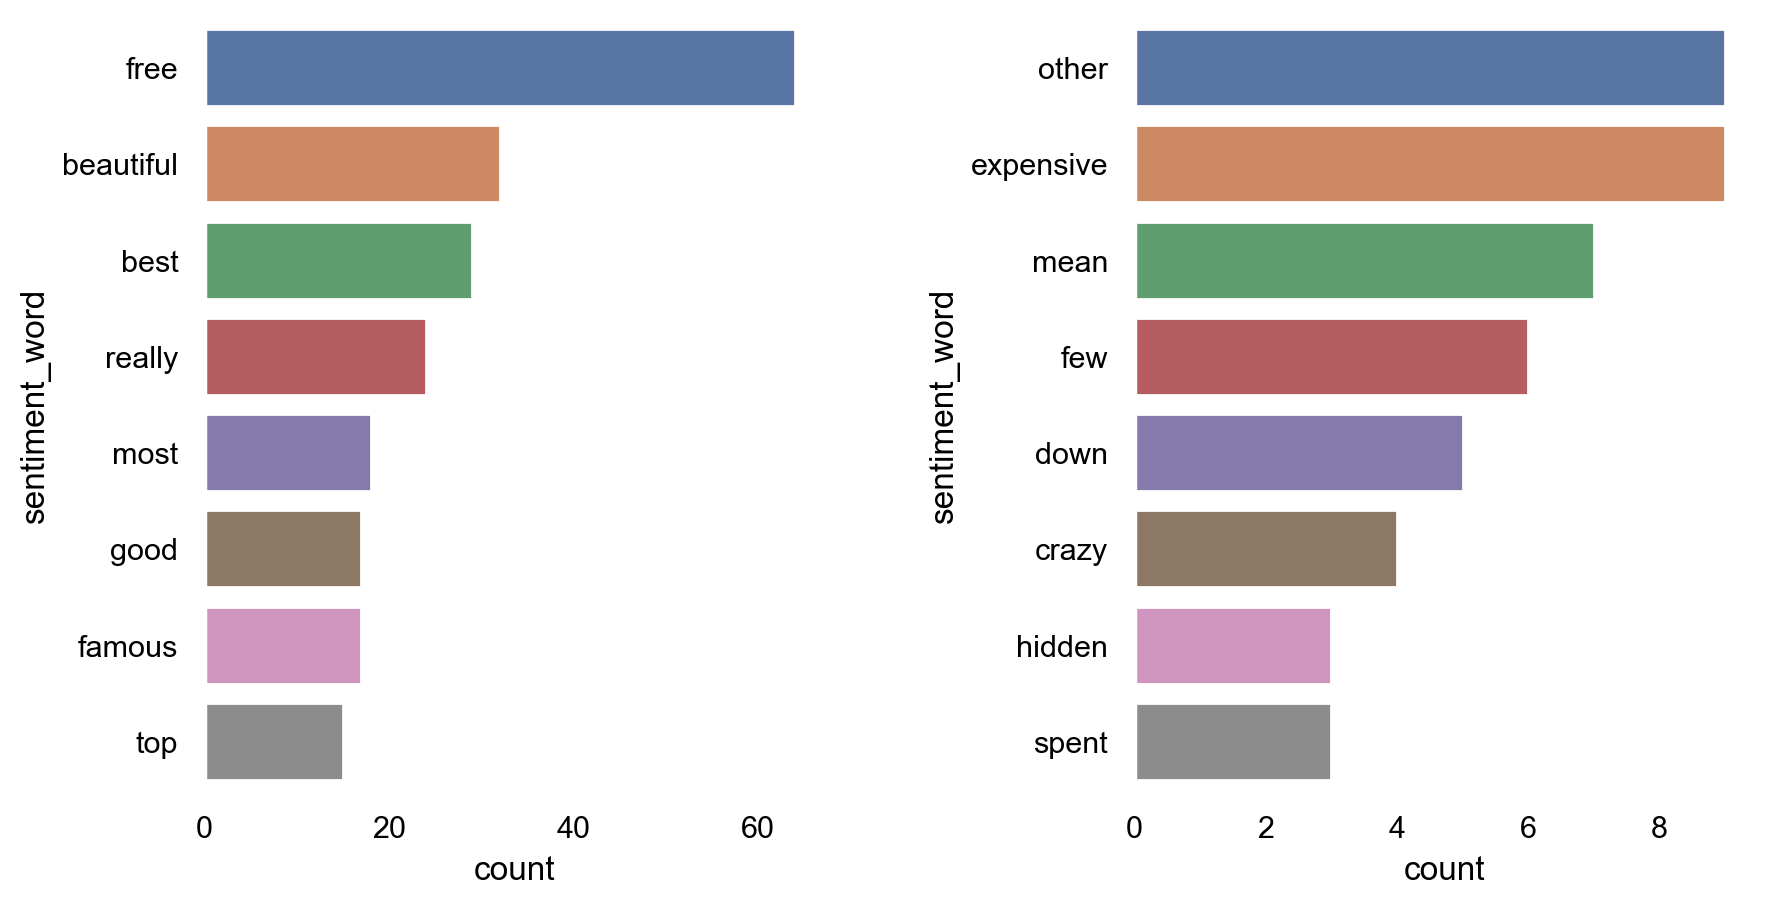

In [52]:
# nature
interest_1 = 'nature'

fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.5)

sns.barplot(data=create_df_sort(interest_1_df,interest_1,8,'pos_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[0])
sns.barplot(data=create_df_sort(interest_1_df,interest_1,8,'neg_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[1])

#### Visualize the positive and negative sentiment words commonly associated with `nature`

<Axes: xlabel='count', ylabel='sentiment_word'>

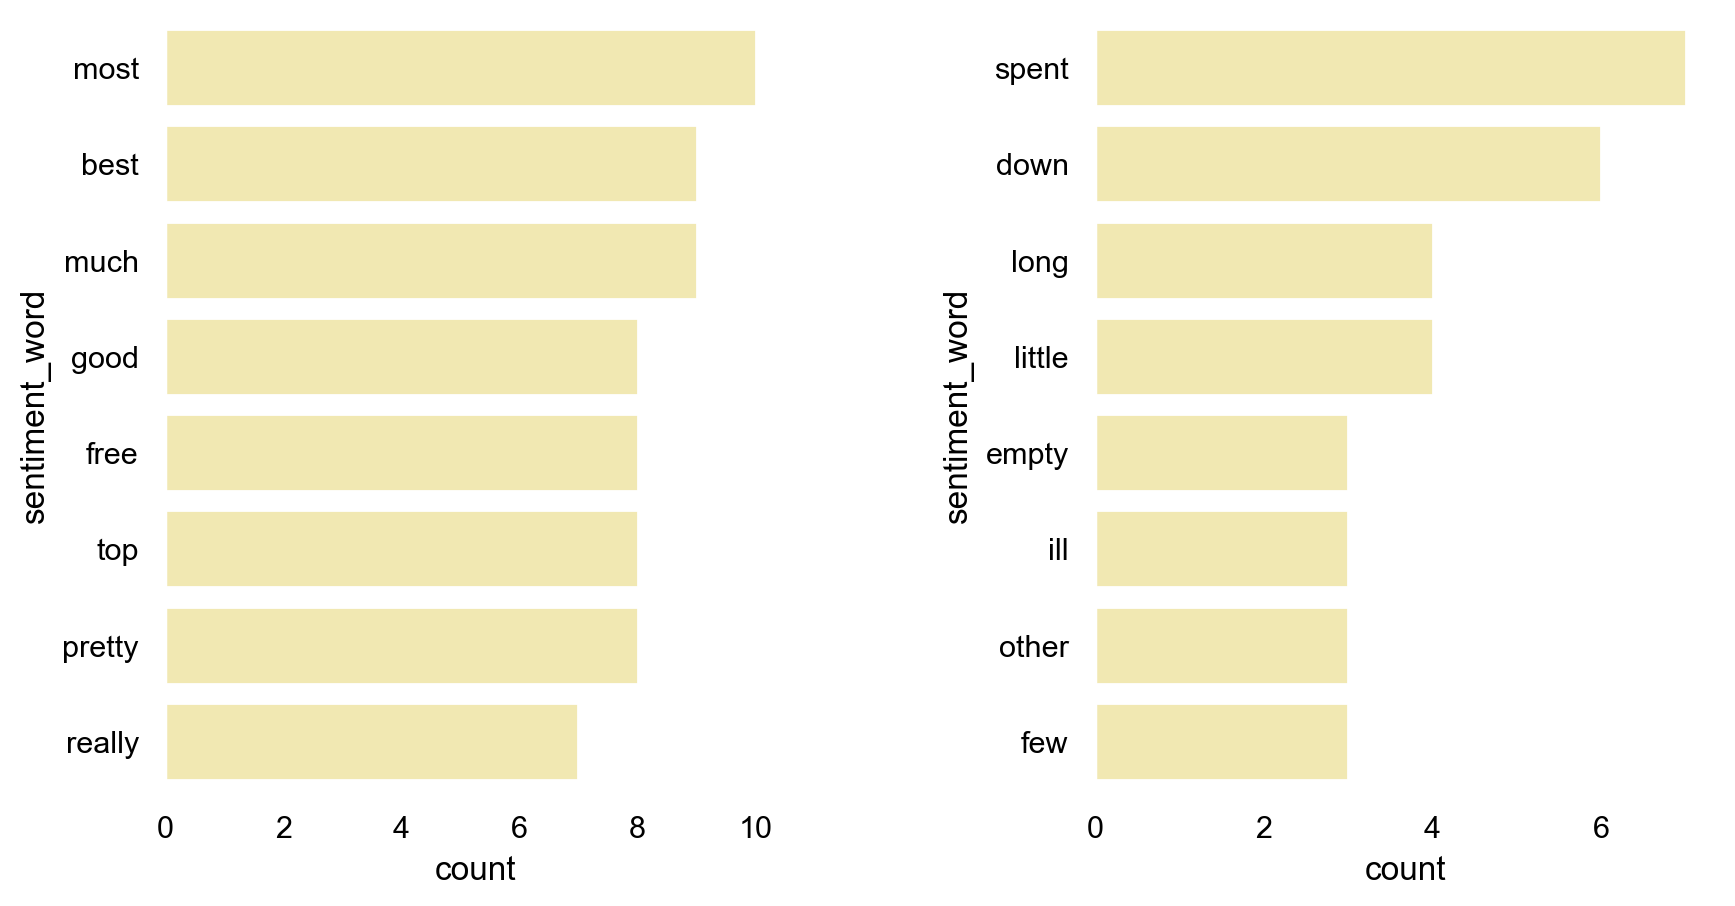

In [69]:
# transport
interest_1 = 'transport'

fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.5)

sns.barplot(data=create_df_sort(interest_1_df,interest_1,8,'pos_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[0],
           color='#fcefa7',)
sns.barplot(data=create_df_sort(interest_1_df,interest_1,8,'neg_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[1],
           color='#fcefa7',)

#### Visualize the positive and negative sentiment words commonly associated with `transport`

In [49]:
# function to create dataframe from cell and sort by count
def create_df_sort(interest_1_df,interest_1,top_n_words,pos_or_neg_col):
    # find row number in which 'interest_1' appears in interest_1_df
    row_num = interest_1_df.index[interest_1_df['interest_1'] == interest_1][0]
    # create df
    df = pd.DataFrame(interest_1_df[interest_1_df['interest_1'] == interest_1].loc[row_num,pos_or_neg_col])
    # sort df by count
    df = df.sort_values(by=['count'],ascending=False)
    # only show the top_n_words
    df = df.head(top_n_words)
    return df

#### Create a function to create dataframe from cell and sort by count

#### Combine `neg_sentiment_words` dictionaries by `interest_1`

,sentiment_word,count
0,amazing,132
1,whole,17
2,best,268
3,live,12
4,awesome,16
...,...,...
183,laughed,2
184,clear,2
185,interested,1
186,secure,1


#### Combine `pos_sentiment_words` dictionaries by `interest_1`

In [45]:
# reset sorting
unique_entities_count_df = unique_entities_count_df.sort_index()

In [44]:
def add_counts(sentiment_words, counts, combined_dict):
    for word, count in zip(sentiment_words, counts):
        if word in combined_dict['sentiment_word']:
            # find the index of the word in the list saved in combined_dict['sentiment_words']
            index_of_word = combineddict['sentiment_word'].index(word)
            combined_dict['count'][index_of_word] += count
        else:
            combined_dict['sentiment_word'].append(word)
            combined_dict['count'].append(count)
    return combined_dict

#### Create a function that adds 2 dictionaries together. If the `sentiment_word` has appeared before, the function will add `count` to its corresponding `count`, if `sentiment_word` has not appeared before, append `sentiment_word` to the list and append `count` to the `count` list.

In [43]:
interest_1_df['interest_1'] = unique_entities_count_df['interest_1'].unique()
interest_1_df['pos_sentiment_words'] = 0
interest_1_df['neg_sentiment_words'] = 0
interest_1_df.head()

,interest_1,pos_sentiment_words,neg_sentiment_words
0,food and drinks,0,0
1,shopping,0,0
2,transport,0,0
3,nature,0,0
4,recreation,0,0


In [42]:
# create a dataframe for the different types of tourist attractions
interest_1_df = pd.DataFrame(columns=['interest_1',
                                      'pos_sentiment_words',
                                      'neg_sentiment_words'])
interest_1_df

,interest_1,pos_sentiment_words,neg_sentiment_words


In [57]:
pos_sentiment_words_dict

{'sentiment_word': ['amazing',
  'whole',
  'best',
  'live',
  'awesome',
  'love',
  'favorite',
  'incredible',
  'available',
  'top',
  'pretty',
  'sure',
  'most',
  'famous',
  'beautiful',
  'adult',
  'super',
  'win',
  'perfect',
  'fresh',
  'dim',
  'absolutely',
  'really',
  'early',
  'peaceful',
  'fun',
  'wild',
  'much',
  'honestly',
  'more',
  'accurately',
  'real',
  'many',
  'better',
  'haha',
  'near',
  'great',
  'free',
  'mostly',
  'right',
  'good',
  'clean',
  'normal',
  'special',
  'apparently',
  'very',
  'modern',
  'cool',
  'funny',
  'colorful',
  'offers',
  'new',
  'cheap',
  'complete',
  'major',
  'welcome',
  'smart',
  'wants',
  'own',
  'authentic',
  'grand',
  'iconic',
  'fantastic',
  'fair',
  'nice',
  'reasonable',
  'surprised',
  'enjoy',
  'classic',
  'enjoyed',
  'able',
  'easy',
  'worth',
  'useful',
  'fly',
  'experienced',
  'proud',
  'direct',
  'catching',
  'appetizing',
  'excited',
  'safely',
  'high',
  

Compared to the unigram, the bigram provides more meaning and context. For example, instead of just the word 'best', the bigram shows us word pairings such as 'best airport'.

With the use of stopwords, the top commonly appearing bigrams now have more meaning. 

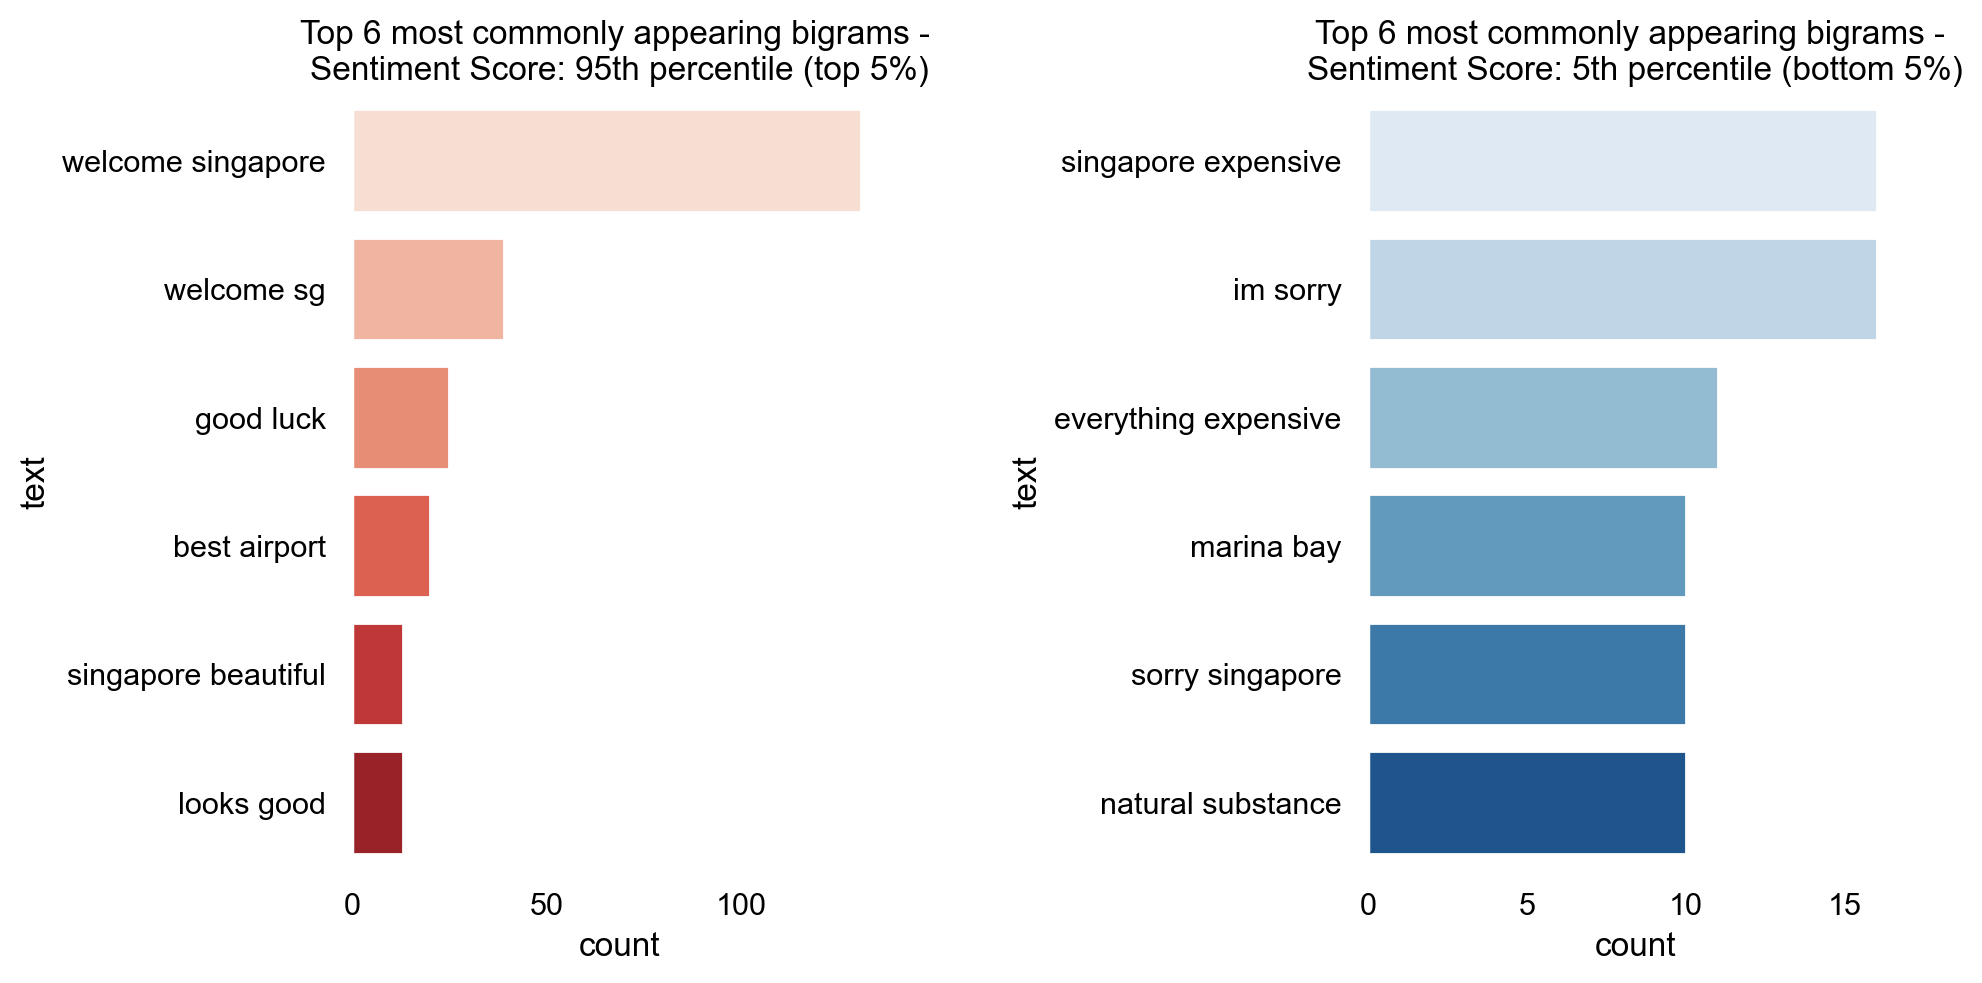

In [99]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=6, ngram=(2,2), stop=stopwords),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 6 most commonly appearing bigrams - \nSentiment Score: 95th percentile (top 5%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=6, ngram=(2,2), stop=stopwords),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 6 most commonly appearing bigrams - \nSentiment Score: 5th percentile (bottom 5%)')
None

#### Visualize commonly appearing bigrams with stopwords

Some bigrams do not really mean anything, such as 'to the', 'is the', 'to be', etc. As such, we shall include stopwords in the next step.

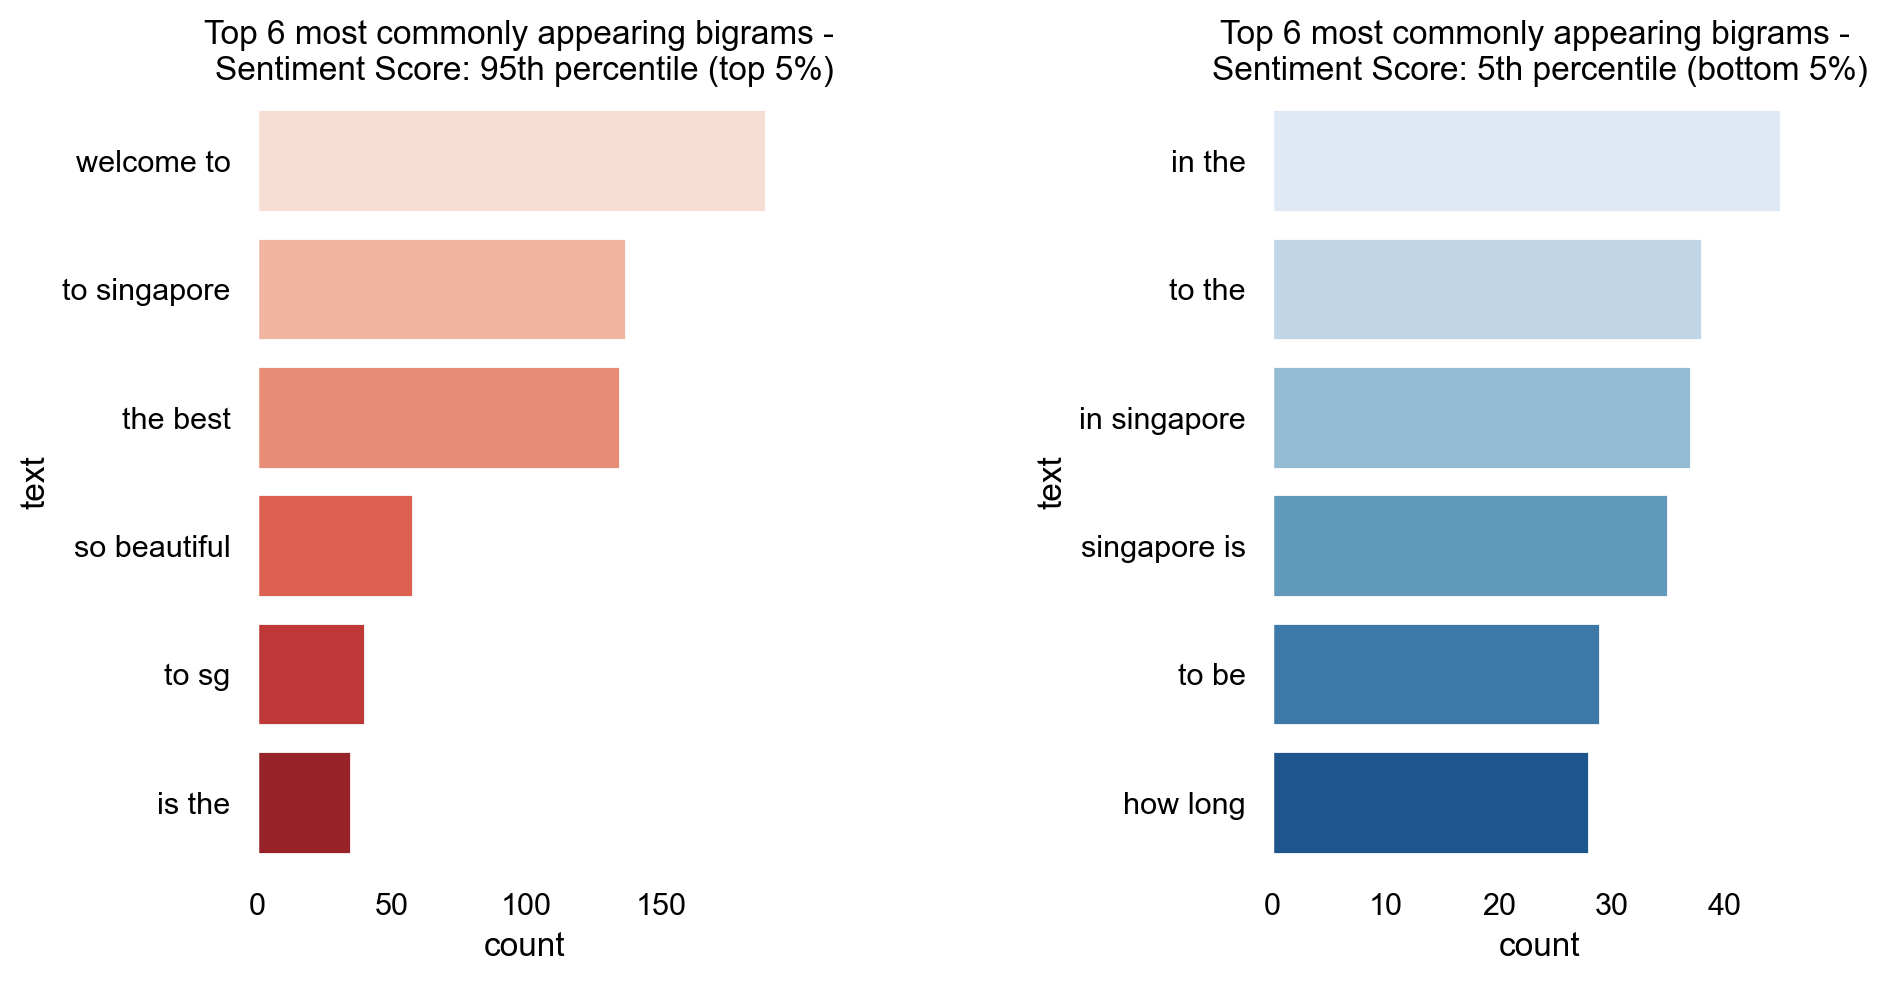

In [97]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=6, ngram=(2,2), stop=None),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 6 most commonly appearing bigrams - \nSentiment Score: 95th percentile (top 5%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=6, ngram=(2,2), stop=None),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 6 most commonly appearing bigrams - \nSentiment Score: 5th percentile (bottom 5%)')
None

#### Visualize commonly appearing bigrams without stopwords

However, it is still not extremely clear what the context is. As such, we shall look at bigrams to see if we can gain more insights. 

With the use of stopwords, the top commonly appearing unigrams now have more meaning. 

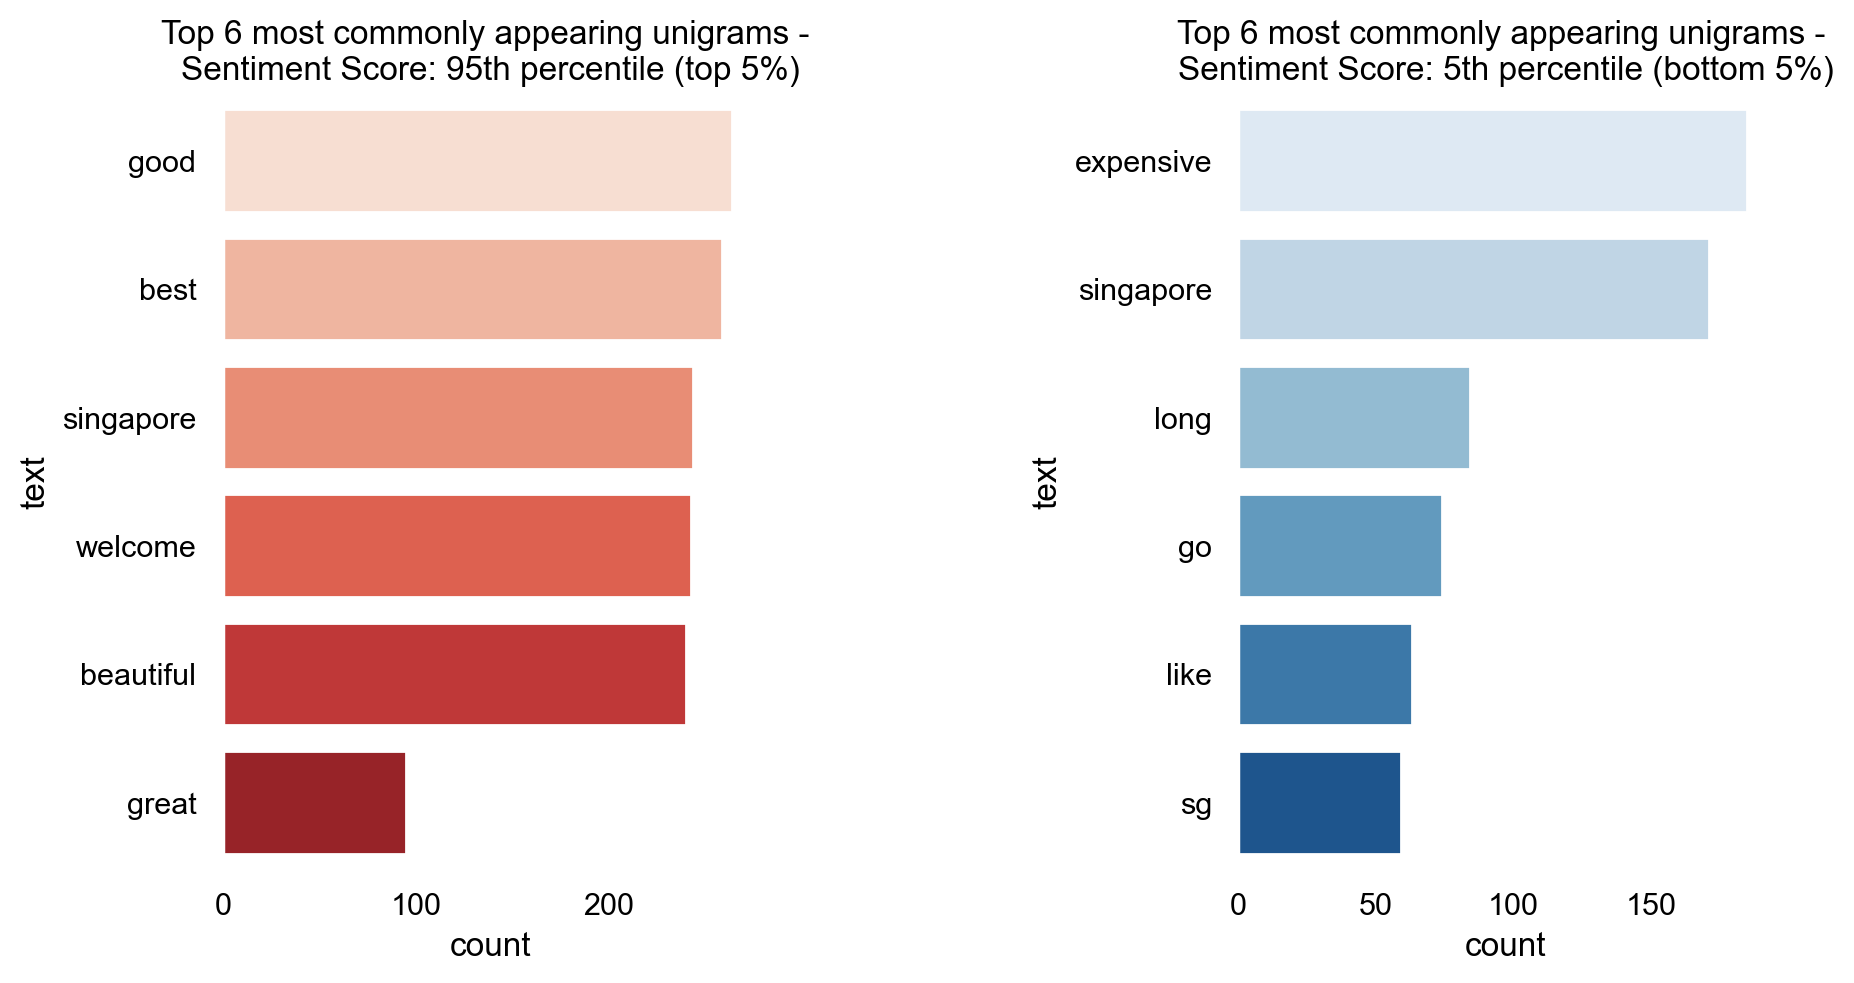

In [96]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=6, ngram=(1,1), stop=stopwords),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 6 most commonly appearing unigrams - \nSentiment Score: 95th percentile (top 5%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=6, ngram=(1,1), stop=stopwords),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 6 most commonly appearing unigrams - \nSentiment Score: 5th percentile (bottom 5%)')
None

#### Visualize commonly appearing unigrams with stopwords

Some unigrams do not really mean anything, such as 'to', 'the', 'is', etc. As such, we shall include stopwords in the next step.

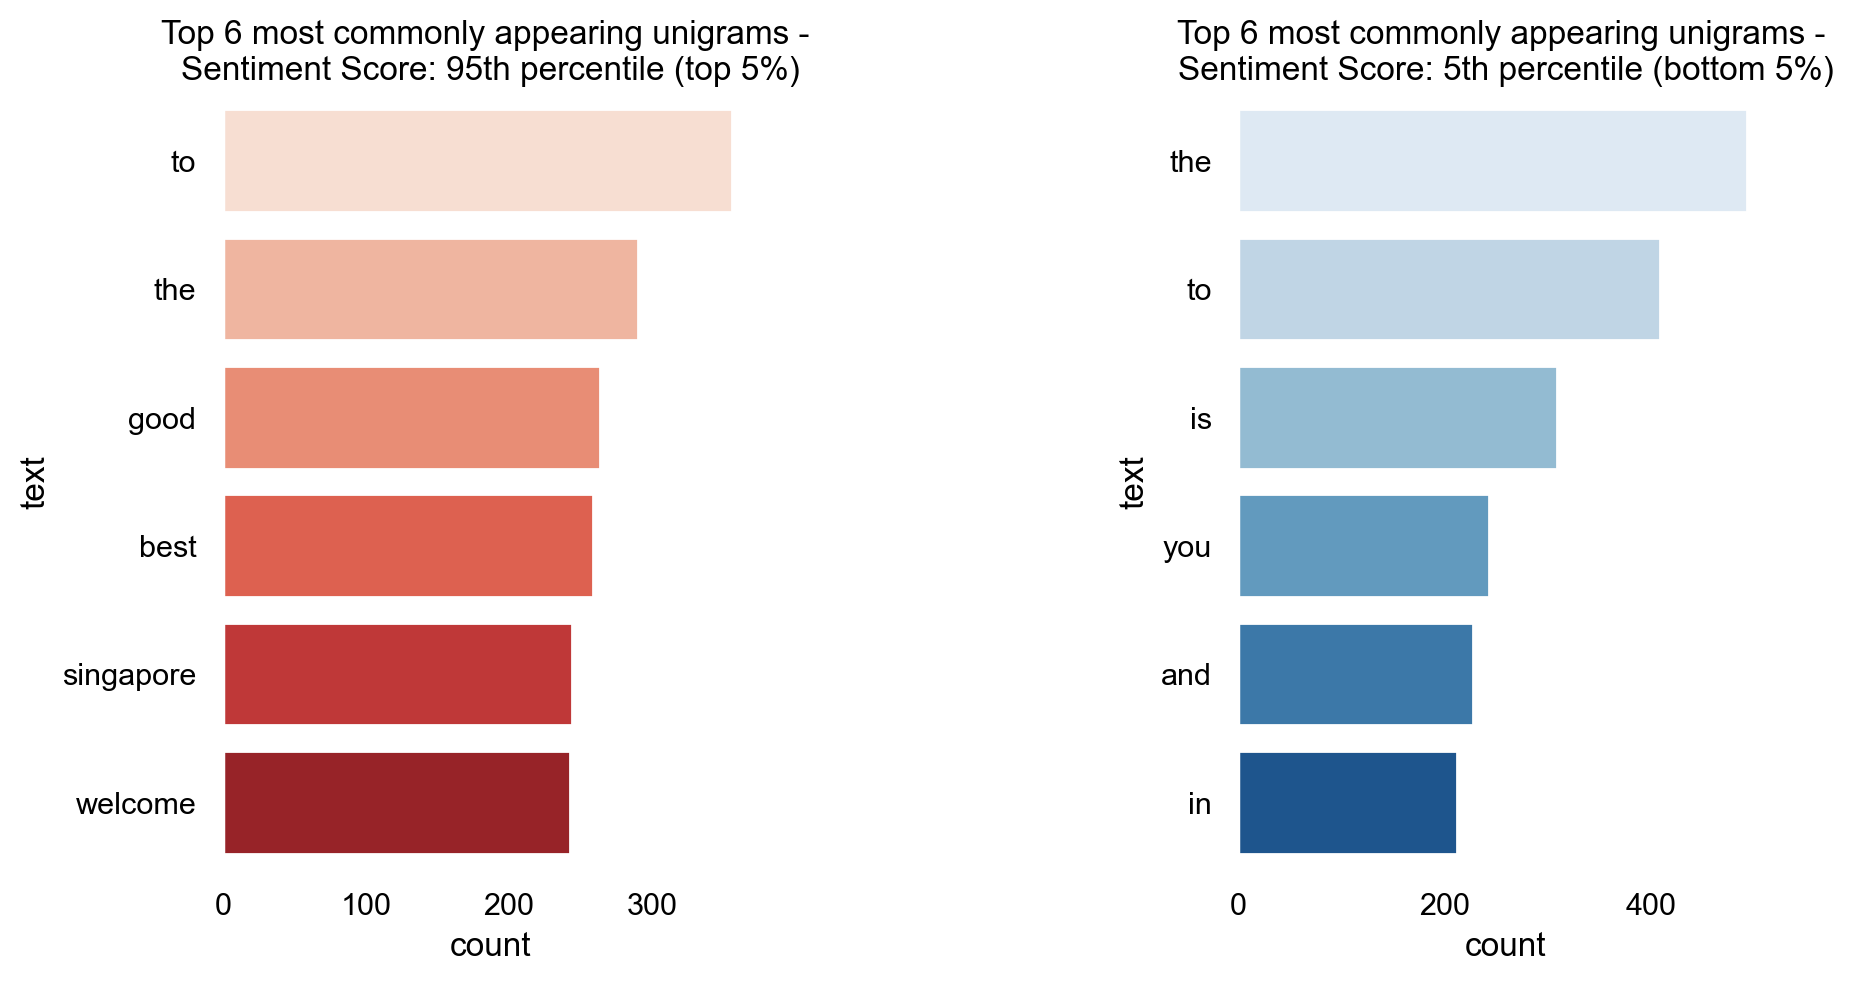

In [94]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=6, ngram=(1,1), stop=None),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 6 most commonly appearing unigrams - \nSentiment Score: 95th percentile (top 5%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=6, ngram=(1,1), stop=None),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 6 most commonly appearing unigrams - \nSentiment Score: 5th percentile (bottom 5%)')
None

#### Visualize commonly appearing unigrams without stopwords

In [92]:
def top_n_grams(corpus, n, ngram, stop):
    # Create a CountVectorizer object with specified n-gram range and stop words
    vec = CountVectorizer(ngram_range=ngram, stop_words=stop)
    # Convert the corpus into a bag of words representation
    bag_of_words = vec.fit_transform(corpus)
    # Calculate the sum of words across all documents
    sum_words = bag_of_words.sum(axis=0) 
    # Create a list of (word, count) pairs from the vocabulary and word counts
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sort the list of (word, count) pairs by count in descending order and select top n
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)[:n]
    # Store top n common n-grams in a dataframe
    df = pd.DataFrame(words_freq, columns=['text', 'count'])
    # Sort the dataframe by the count column in descending order
    df = df.sort_values(by='count', ascending=False)

    return df 

In [90]:
stopwords = stopwords.words('english')

AttributeError: 'list' object has no attribute 'words'

### Analyze most commonly used words

With the use of stopwrds, the top 20 commonly appearing trigrams now have more meaning. 

[Text(0.5, 1.0, 'Top 20 most commonly appearing trigrams - \nSentiment Score: 5th percentile (bottom 5%)')]

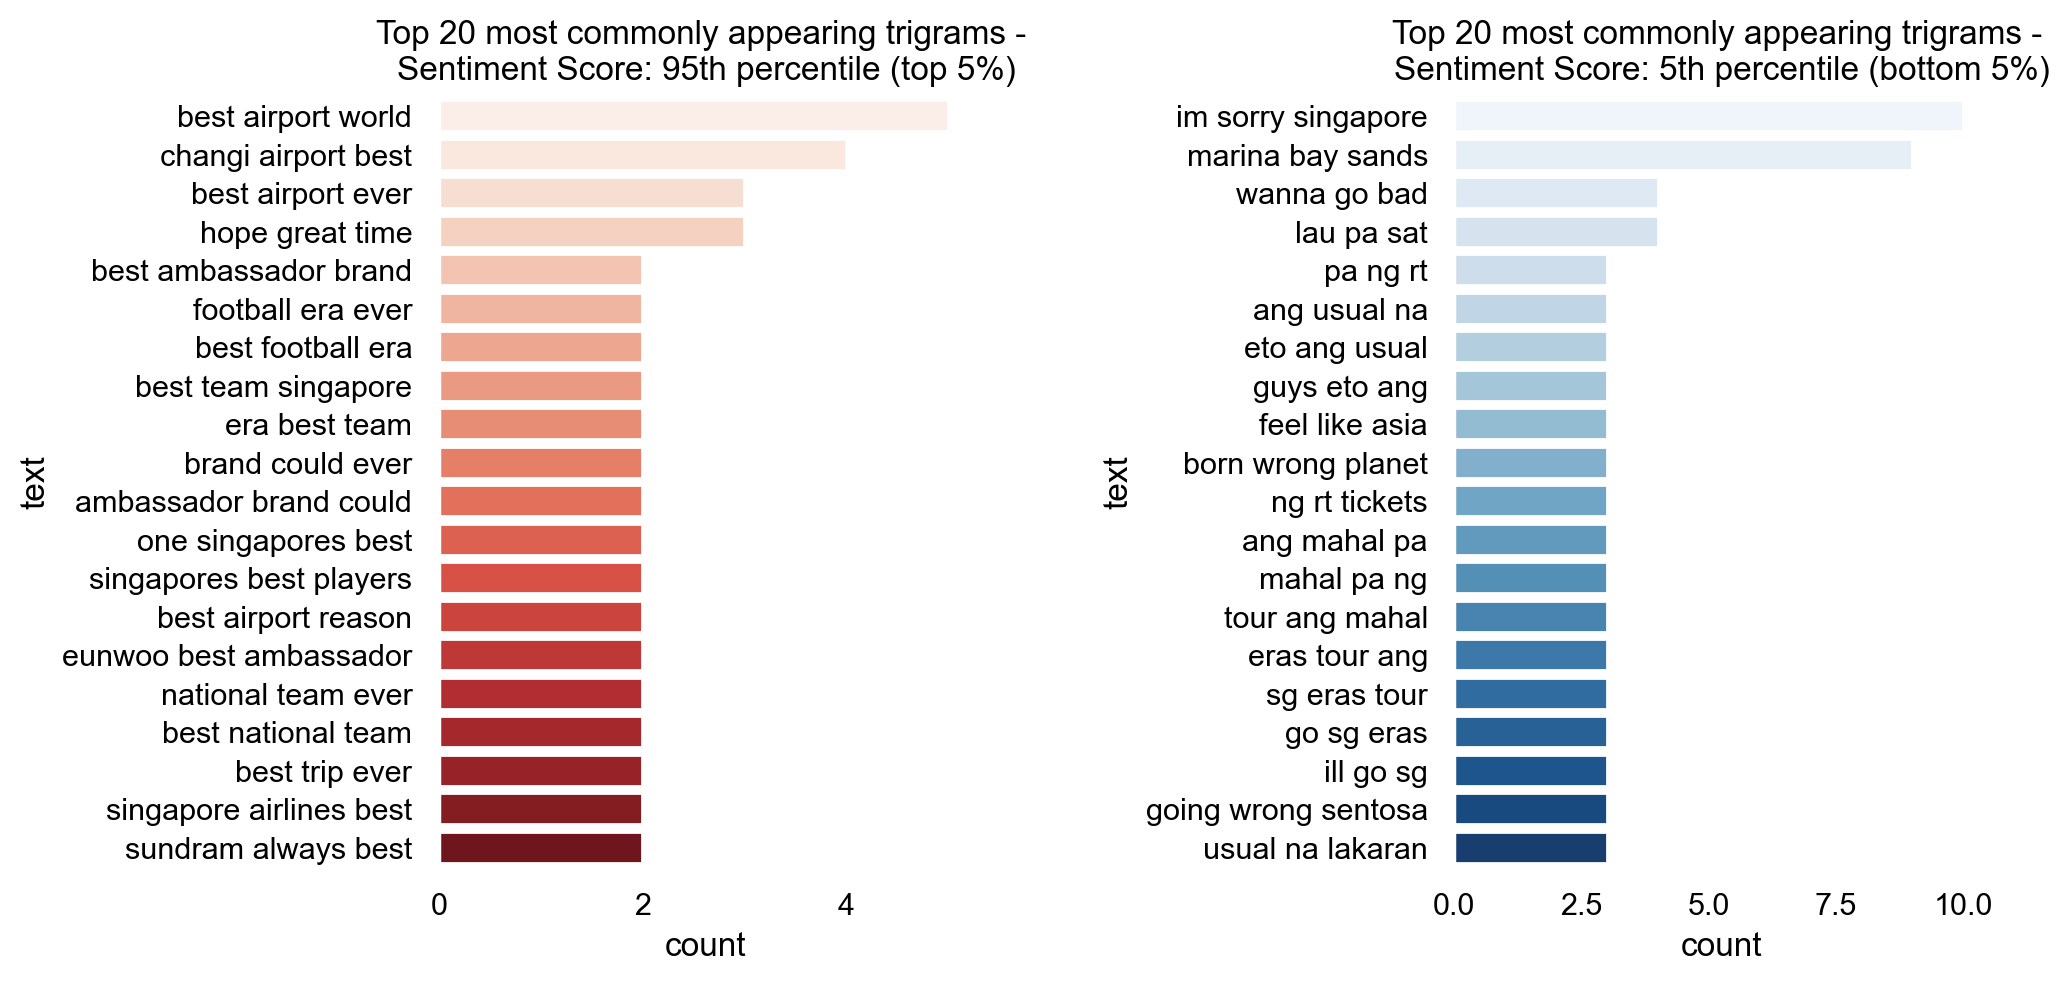

In [89]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=20, ngram=(3,3), stop=stopwords),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 20 most commonly appearing trigrams - \nSentiment Score: 95th percentile (top 5%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=20, ngram=(3,3), stop=stopwords),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 20 most commonly appearing trigrams - \nSentiment Score: 5th percentile (bottom 5%)')

#### Visualize commonly appearing trigrams with stopwords

Some trigrams do not really mean anything, such as 'you are', 'it was', 'have to', etc. As such, we shall include stopwords in the next step.

[Text(0.5, 1.0, 'Top 20 most commonly appearing trigrams - \nSentiment Score: 5th percentile (bottom 5%)')]

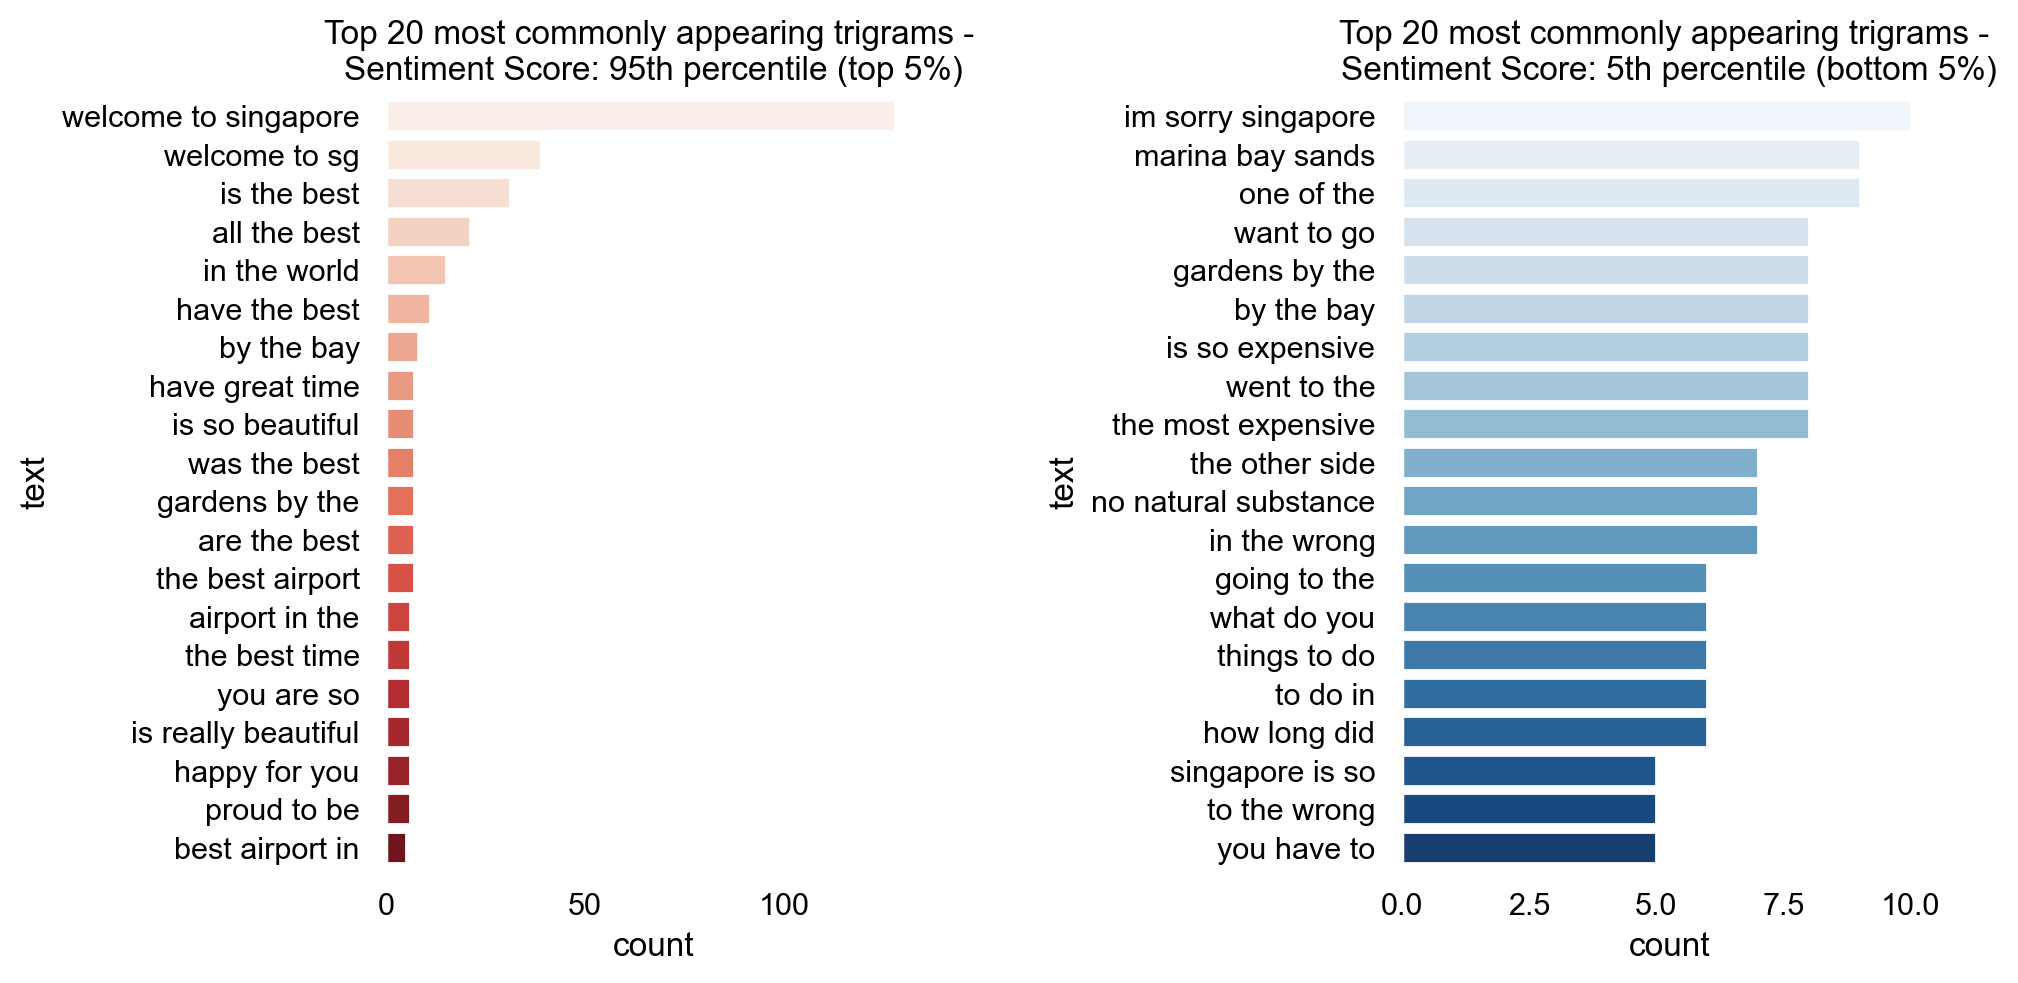

In [88]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=20, ngram=(3,3), stop=None),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 20 most commonly appearing trigrams - \nSentiment Score: 95th percentile (top 5%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=20, ngram=(3,3), stop=None),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 20 most commonly appearing trigrams - \nSentiment Score: 5th percentile (bottom 5%)')

#### Visualize commonly appearing trigrams without stopwords

##### Bi-gram with stopwords

#### Most commonly used words for sentences with sentiment scores that are in the 5th percentile (bottom 5%).

##### Bi-gram with stopwords

#### Most commonly used words for sentences with sentiment scores that are in the 95th percentile (top 5%).

<Axes: xlabel='count', ylabel='text'>

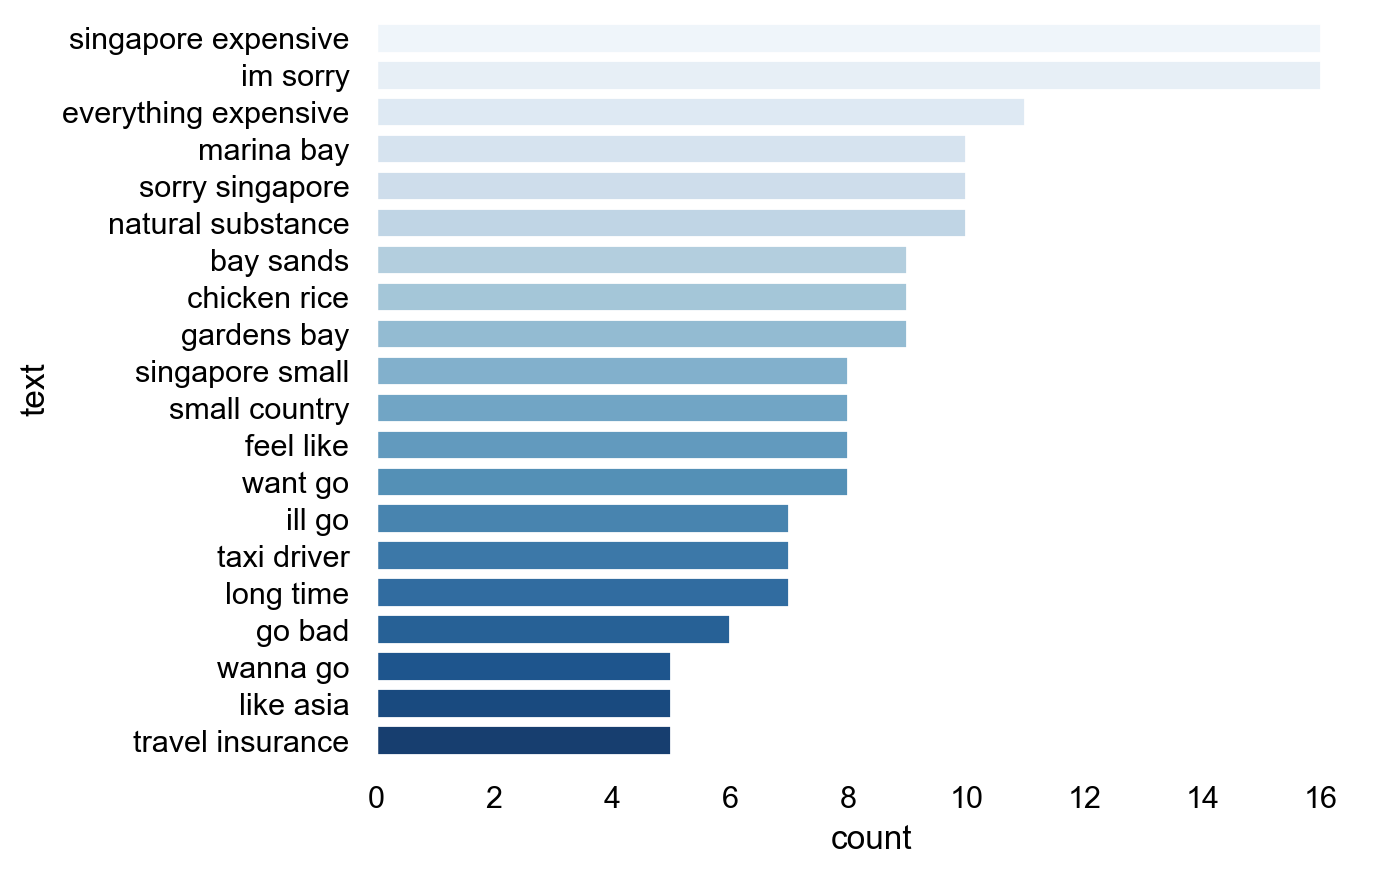

In [67]:
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=20, ngram=(2,2), stop=stopwords),
           x='count',y='text',
             palette='Blues',
            alpha=1.0)

In [58]:
top_n_grams(top_sentences['sentence'], n=20, ngram=(2,2), stop=stopwords)

,text,count
0,welcome singapore,131
1,welcome sg,39
2,good luck,25
3,best airport,20
4,singapore beautiful,13
5,looks good,13
6,best airline,12
7,beautiful country,12
8,good food,11
11,beautiful place,9


In [59]:
top_n_grams(bottom_sentences['sentence'], n=20, ngram=(2,2), stop=stopwords)

,text,count
0,singapore expensive,16
1,im sorry,16
2,everything expensive,11
3,marina bay,10
4,sorry singapore,10
5,natural substance,10
6,bay sands,9
7,chicken rice,9
8,gardens bay,9
11,singapore small,8


In [ ]:
# 'payment'

#### Visualize the positive and negative sentiment words commonly associated with `payment`

In [ ]:
# 'heritage'

#### Visualize the positive and negative sentiment words commonly associated with `heritage`

In [ ]:
# 'park'

#### Visualize the positive and negative sentiment words commonly associated with `park`

In [ ]:
# 'museum'
interest_1 = 'nature'

fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.5)

sns.barplot(data=create_df_sort(interest_1_df,interest_1,10,'pos_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[0])
sns.barplot(data=create_df_sort(interest_1_df,interest_1,10,'neg_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[1])

#### Visualize the positive and negative sentiment words commonly associated with `museum`

In [ ]:
# 'amusement park'
interest_1 = 'nature'

fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.5)

sns.barplot(data=create_df_sort(interest_1_df,interest_1,10,'pos_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[0])
sns.barplot(data=create_df_sort(interest_1_df,interest_1,10,'neg_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[1])

#### Visualize the positive and negative sentiment words commonly associated with `amusement park`

<Axes: xlabel='count', ylabel='sentiment_word'>

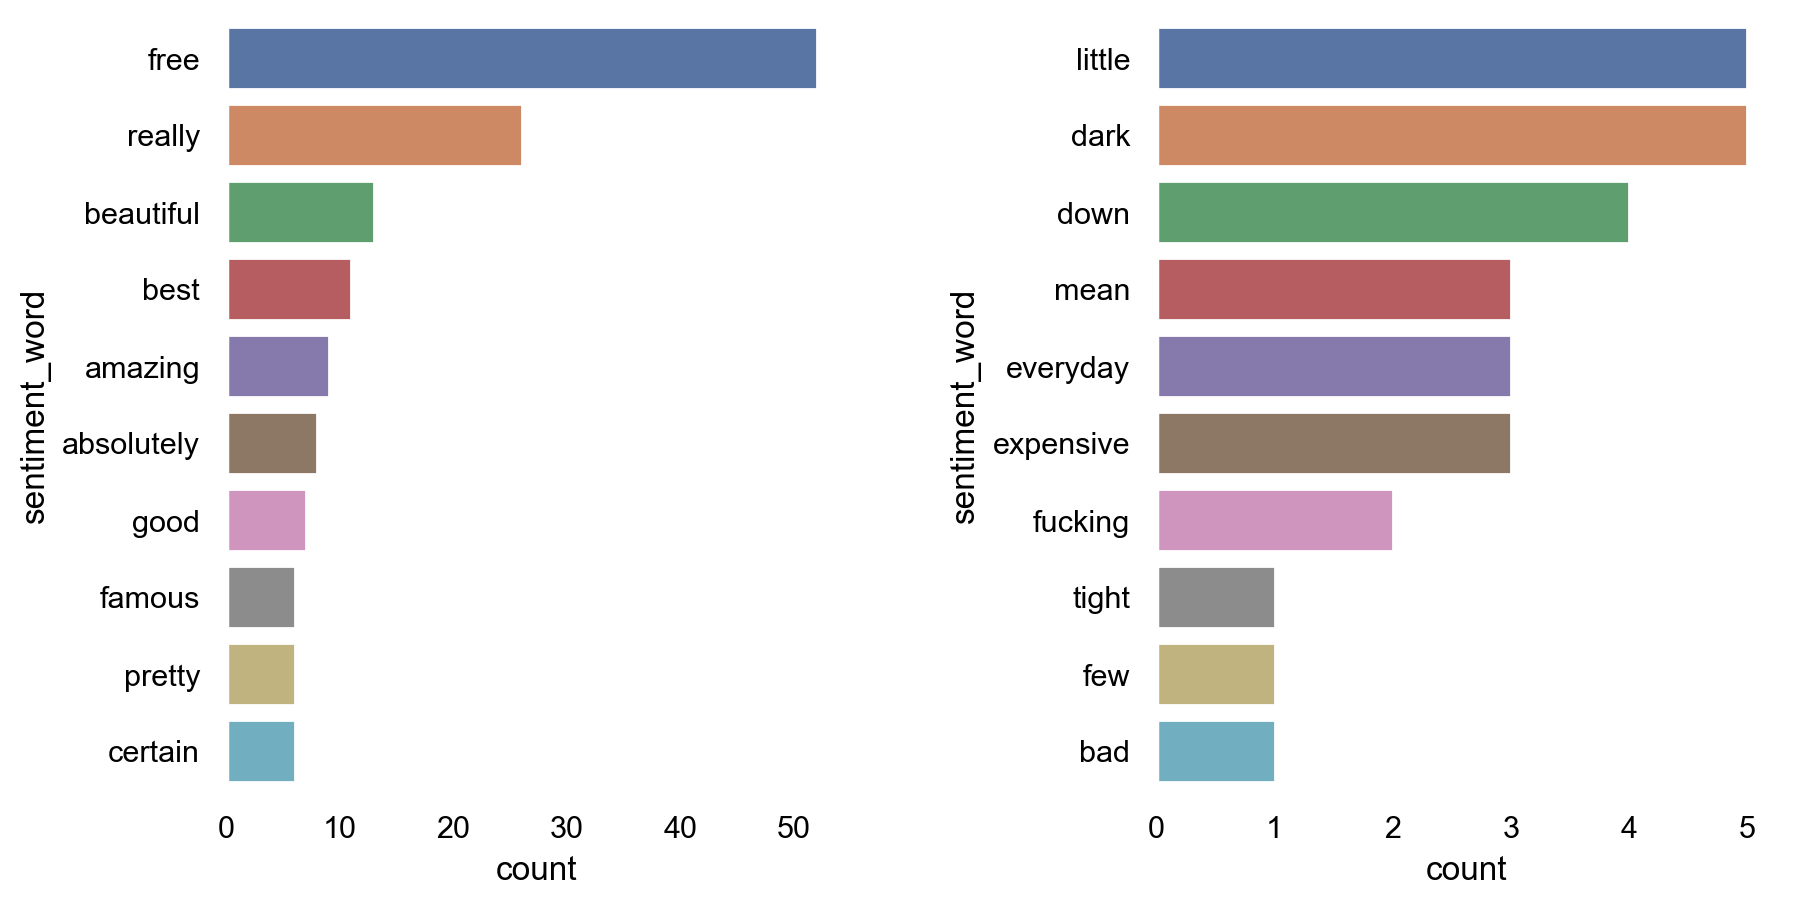

In [52]:
# 'art'
interest_1 = 'art'

fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.5)

sns.barplot(data=create_df_sort(interest_1_df,interest_1,10,'pos_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[0])
sns.barplot(data=create_df_sort(interest_1_df,interest_1,10,'neg_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[1])

#### Visualize the positive and negative sentiment words commonly associated with `art`

<Axes: xlabel='count', ylabel='sentiment_word'>

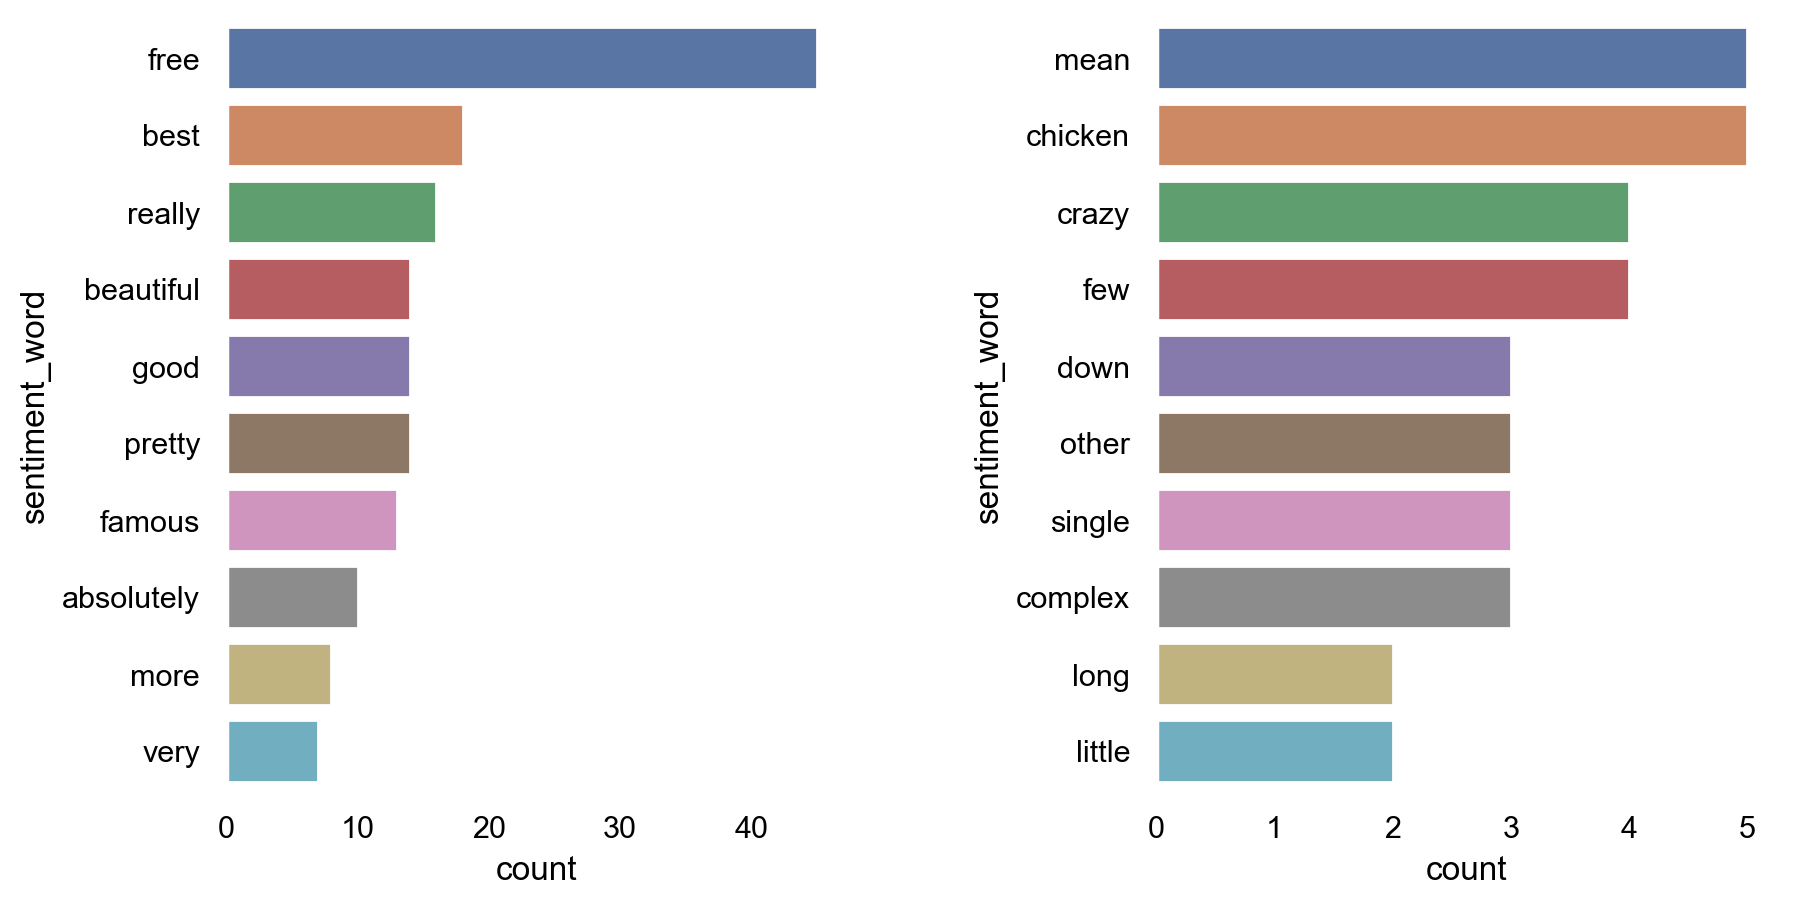

In [46]:
# 'culture'
interest_1 = 'culture'

fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.5)

sns.barplot(data=create_df_sort(interest_1_df,interest_1,10,'pos_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[0])
sns.barplot(data=create_df_sort(interest_1_df,interest_1,10,'neg_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[1])

#### Visualize the positive and negative sentiment words commonly associated with `culture`

<Axes: xlabel='count', ylabel='sentiment_word'>

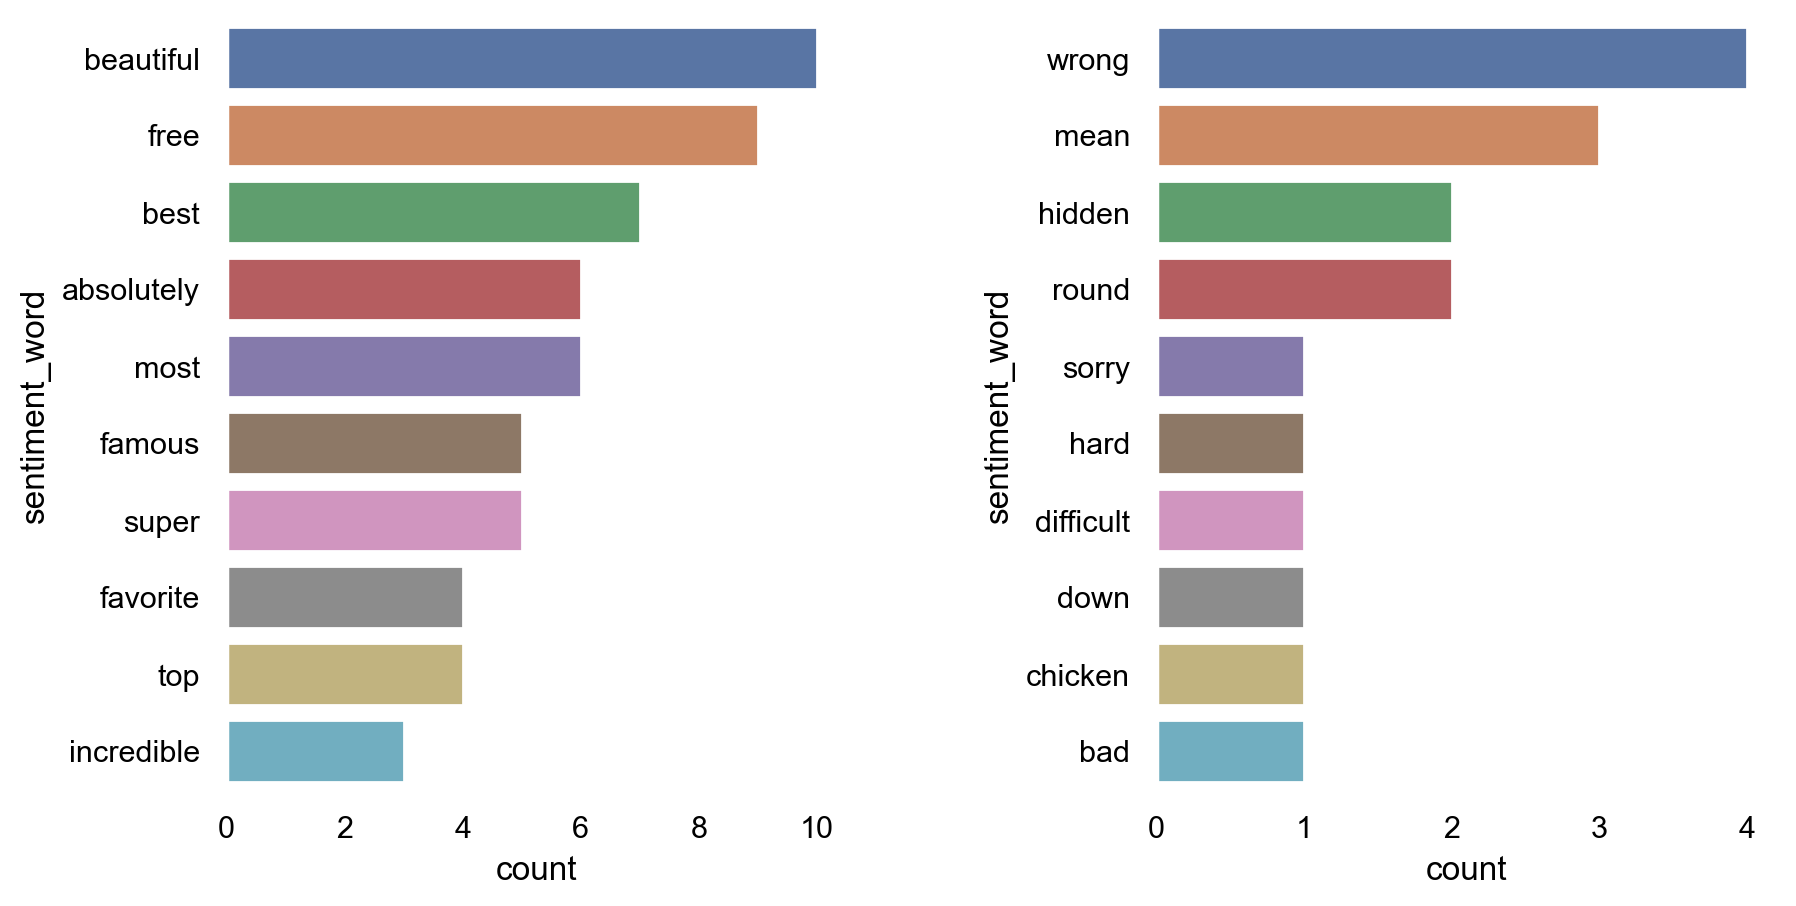

In [45]:
# 'recreation'
interest_1 = 'recreation'

fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.5)

sns.barplot(data=create_df_sort(interest_1_df,interest_1,10,'pos_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[0])
sns.barplot(data=create_df_sort(interest_1_df,interest_1,10,'neg_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[1])

#### Visualize the positive and negative sentiment words commonly associated with `recreation`

<Axes: xlabel='Density', ylabel='interest_1'>

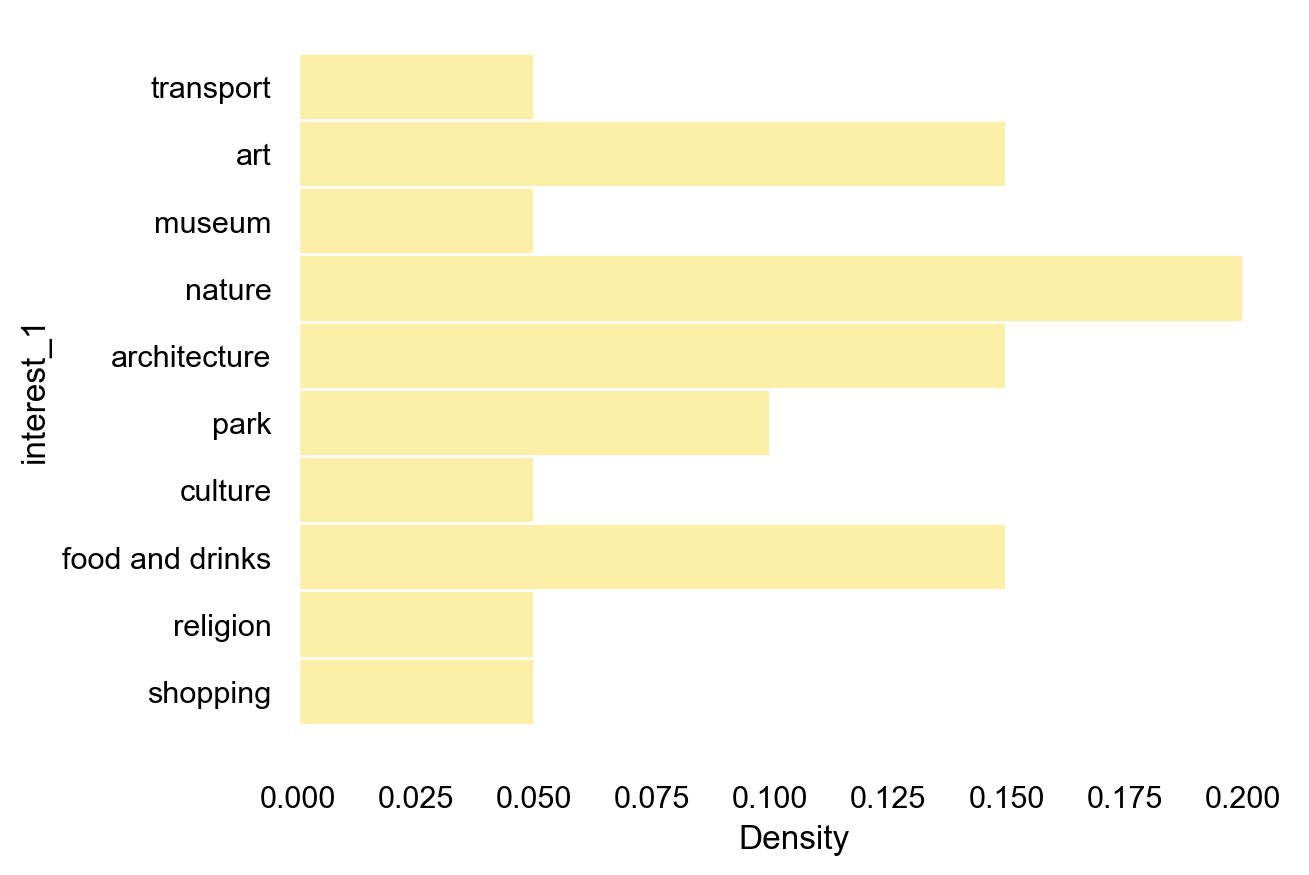

In [51]:
sns.histplot(data=unique_entities_count_df.head(20),
             y='interest_1',
             stat='density',
             color='#fcefa7',
            alpha=1.0)

#### Visualize the positive and negative sentiment words commonly associated with `shopping`

<Axes: xlabel='count', ylabel='sentiment_word'>

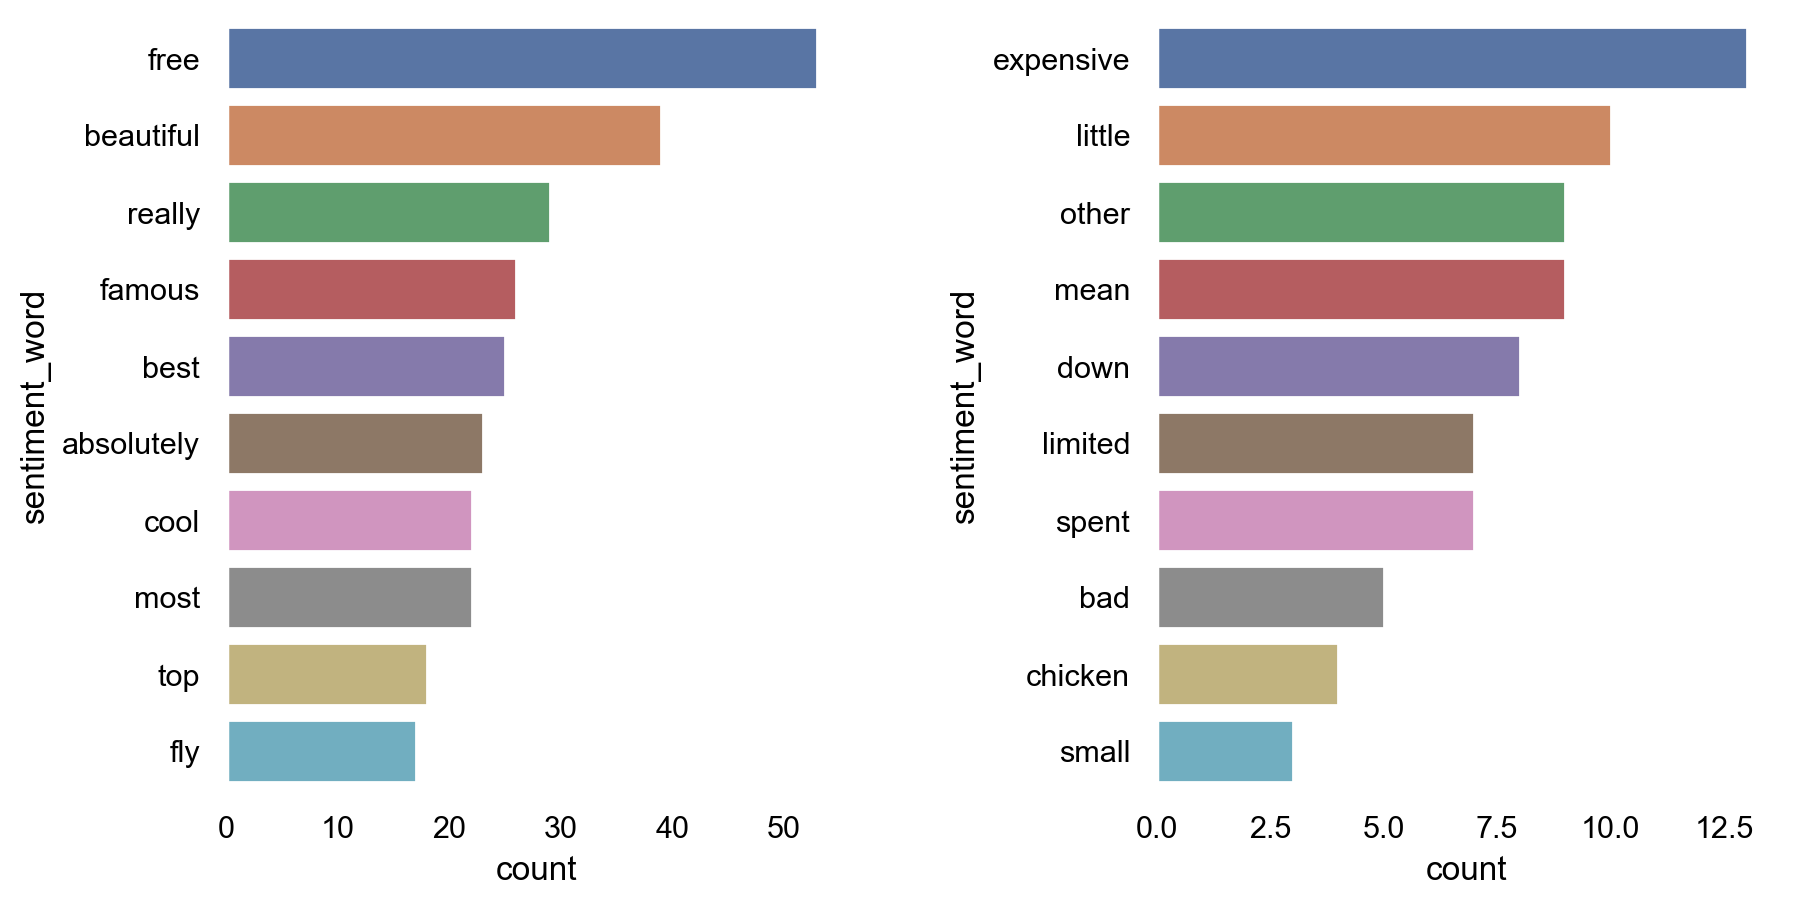

In [42]:
# shopping
interest_1 = 'shopping'

fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.5)

sns.barplot(data=create_df_sort(interest_1_df,interest_1,10,'pos_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[0])
sns.barplot(data=create_df_sort(interest_1_df,interest_1,10,'neg_sentiment_words'),
            x='count',y='sentiment_word',
            ax=axes[1])

In [71]:
interest_1_df.index[interest_1_df['interest_1'] == interest_1][0]

0

In [ ]:
# 'nature'

In [ ]:
# 'transport'

In [37]:
combined_dict

NameError: name 'combined_dict' is not defined

In [47]:
unique_entities_count_df['pos_sentiment_words'][0]

{'sentiment_word': ['amazing',
  'whole',
  'best',
  'live',
  'awesome',
  'love',
  'favorite',
  'incredible',
  'available',
  'top',
  'pretty',
  'sure',
  'most',
  'famous',
  'beautiful',
  'adult',
  'super',
  'win',
  'perfect',
  'fresh',
  'dim',
  'absolutely',
  'really',
  'early',
  'peaceful',
  'fun',
  'wild',
  'much',
  'honestly',
  'more',
  'accurately',
  'real',
  'many',
  'better'],
 'count': [3,
  1,
  1,
  1,
  1,
  1,
  2,
  3,
  1,
  3,
  2,
  1,
  5,
  2,
  4,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  2,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1]}

In [43]:
interest_1_df

,interest_1,pos_sentiment_words,neg_sentiment_words
0,food and drinks,"{'amazing': 39, 'cool': 11, 'pretty': 28, 'lol...",0
1,shopping,0,0
2,transport,"{'sentiment_word': ['amazing', 'whole', 'best'...",0
3,nature,"{'loved': 2, 'most': 12, 'popular': 1, 'real':...",0
4,recreation,0,0
5,culture,"{'sentiment_word': ['hahaha', 'free', 'certain...",0
6,art,"{'best': 11, 'absolutely': 7, 'beautiful': 11,...",0
7,amusement park,0,0
8,museum,"{'sentiment_word': ['cool', 'free', 'top', 'ab...",0
9,park,"{'sentiment_word': ['nice', 'straight', 'compl...",0


In [45]:
unique_entities_count_df

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor,nps
0,singapore airport,43,4,0,43,"{'sentiment_word': ['amazing', 'whole', 'best'...","{'sentiment_word': ['spent', 'crying', 'imposs...",transport,recreation,indoor,9.302326
1,future world exhibition,8,0,2,8,"{'sentiment_word': ['best', 'absolutely', 'bea...","{'sentiment_word': ['mean', 'down', 'chicken',...",art,NaN,indoor,-25.000000
2,artscience museum,22,1,1,22,"{'sentiment_word': ['cool', 'free', 'top', 'ab...","{'sentiment_word': ['few', 'tight', 'little', ...",museum,NaN,indoor,0.000000
3,garden by the bay,127,3,4,127,"{'sentiment_word': ['loved', 'most', 'popular'...","{'sentiment_word': ['closed', 'sorry', 'spent'...",nature,architecture,outdoor,-0.787402
4,skyway,10,0,1,10,"{'sentiment_word': ['best', 'absolutely', 'bea...","{'sentiment_word': ['mean', 'down', 'chicken',...",architecture,nature,outdoor,-10.000000
...,...,...,...,...,...,...,...,...,...,...,...
156,people park centre,1,0,0,1,"{'sentiment_word': [], 'count': []}","{'sentiment_word': [], 'count': []}",shopping,NaN,indoor,0.000000
157,suntec city,1,0,0,1,"{'sentiment_word': [], 'count': []}","{'sentiment_word': [], 'count': []}",shopping,NaN,indoor,0.000000
158,beauty world centre,1,0,0,1,"{'sentiment_word': ['top'], 'count': [1]}","{'sentiment_word': [], 'count': []}",shopping,NaN,indoor,0.000000
159,nex,1,0,0,1,"{'sentiment_word': [], 'count': []}","{'sentiment_word': [], 'count': []}",shopping,NaN,indoor,0.000000


In [ ]:
# Sample dictionaries
dict1 = {'sentiment_word': ['apple', 'banana', 'orange'], 'count': [3, 2, 5]}
dict2 = {'sentiment_word': ['banana', 'orange', 'grape'], 'count': [1, 4, 2]}

# Create a dictionary to store the combined counts
combined_dict = {}

# Helper function to add counts to the combined_dict
def add_counts(sentiment_words, counts):
    for word, count in zip(sentiment_words, counts):
        if word in combined_dict:
            combined_dict[word] += count
        else:
            combined_dict[word] = count

# Add counts from dict1 to the combined_dict
add_counts(dict1['sentiment_word'], dict1['count'])

# Add counts from dict2 to the combined_dict
add_counts(dict2['sentiment_word'], dict2['count'])

print(combined_dict)

In [39]:
unique_entities_count_df

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor,nps
9,food,356,11,30,356,"{'sentiment_word': ['amazing', 'cool', 'pretty...","{'sentiment_word': ['expensive', 'due', 'serio...",food and drinks,NaN,indoor,-5.337079
15,shoppe at marina bay sand,132,1,6,132,"{'sentiment_word': ['nice', 'great', 'many', '...","{'sentiment_word': ['expensive', 'less', 'othe...",shopping,NaN,indoor,-3.787879
36,mrt,128,2,3,128,"{'sentiment_word': ['haha', 'near', 'better', ...","{'sentiment_word': ['confusing', 'usual', 'toi...",transport,NaN,indoor,-0.781250
3,garden by the bay,127,3,4,127,"{'sentiment_word': ['loved', 'most', 'popular'...","{'sentiment_word': ['closed', 'sorry', 'spent'...",nature,architecture,outdoor,-0.787402
31,sentosa,92,3,4,92,"{'sentiment_word': ['pretty', 'nice', 'great',...","{'sentiment_word': ['hidden', 'round', 'wrong'...",recreation,NaN,outdoor,-1.086957
...,...,...,...,...,...,...,...,...,...,...,...
82,atico lounge,1,0,0,1,"{'sentiment_word': ['rich'], 'count': [1]}","{'sentiment_word': [], 'count': []}",food and drinks,NaN,indoor,0.000000
92,anderson bridge,1,0,0,1,"{'sentiment_word': [], 'count': []}","{'sentiment_word': [], 'count': []}",architecture,NaN,outdoor,0.000000
84,alkaff mansion,1,0,0,1,"{'sentiment_word': [], 'count': []}","{'sentiment_word': [], 'count': []}",architecture,NaN,indoor,0.000000
77,war memorial park,1,0,1,1,"{'sentiment_word': [], 'count': []}","{'sentiment_word': ['everyday'], 'count': [1]}",historic,NaN,outdoor,-100.000000


In [111]:
unique_entities_count_df

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor,nps
9,food,356,11,30,356,{},{},food and drinks,NaN,indoor,-5.337079
15,shoppe at marina bay sand,132,1,6,132,{},{},shopping,NaN,indoor,-3.787879
36,mrt,128,2,3,128,{},{},transport,NaN,indoor,-0.781250
3,garden by the bay,127,3,4,127,{},{},nature,architecture,outdoor,-0.787402
31,sentosa,92,3,4,92,{},{},recreation,NaN,outdoor,-1.086957
...,...,...,...,...,...,...,...,...,...,...,...
82,atico lounge,1,0,0,1,{},{},food and drinks,NaN,indoor,0.000000
92,anderson bridge,1,0,0,1,{},{},architecture,NaN,outdoor,0.000000
84,alkaff mansion,1,0,0,1,{},{},architecture,NaN,indoor,0.000000
77,war memorial park,1,0,1,1,{},{},historic,NaN,outdoor,-100.000000


In [112]:
unique_entities_count_df[unique_entities_count_df['interest_1'] == 'food and drinks']

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor,nps
9,food,356,11,30,356,{},{},food and drinks,NaN,indoor,-5.337079
11,hawker centre,87,3,5,87,{},{},food and drinks,NaN,indoor,-2.298851
74,lau pa sat,25,1,3,25,{},{},food and drinks,NaN,indoor,-8.000000
20,level 33,10,0,1,10,{},{},food and drinks,NaN,indoor,-10.000000
99,kaya toast,8,0,0,8,{},{},food and drinks,NaN,indoor,0.000000
67,newton food,7,0,0,7,{},{},food and drinks,NaN,indoor,0.000000
116,hawker market,6,1,0,6,{},{},food and drinks,NaN,indoor,16.666667
79,maxwell food centre,5,0,1,5,{},{},food and drinks,NaN,indoor,-20.000000
125,food court,4,0,1,4,{},{},food and drinks,NaN,indoor,-25.000000
16,long bar,3,0,0,3,{},{},food and drinks,NaN,indoor,0.000000


In [97]:
type(interest_1_df['pos_sentiment_words'][0])

float

In [77]:
interest_1_df

,interest_1,pos_sentiment_words,neg_sentiment_words


In [70]:
unique_entities_count_df['interest_1'].unique()

array(['food and drinks', 'shopping', 'transport', 'nature', 'recreation',
       'culture', 'art', 'amusement park', 'museum', 'park',
       'wildlife park', 'religion', 'architecture', 'historic',
       'heritage', 'payment'], dtype=object)

<Axes: xlabel='nps', ylabel='entity'>

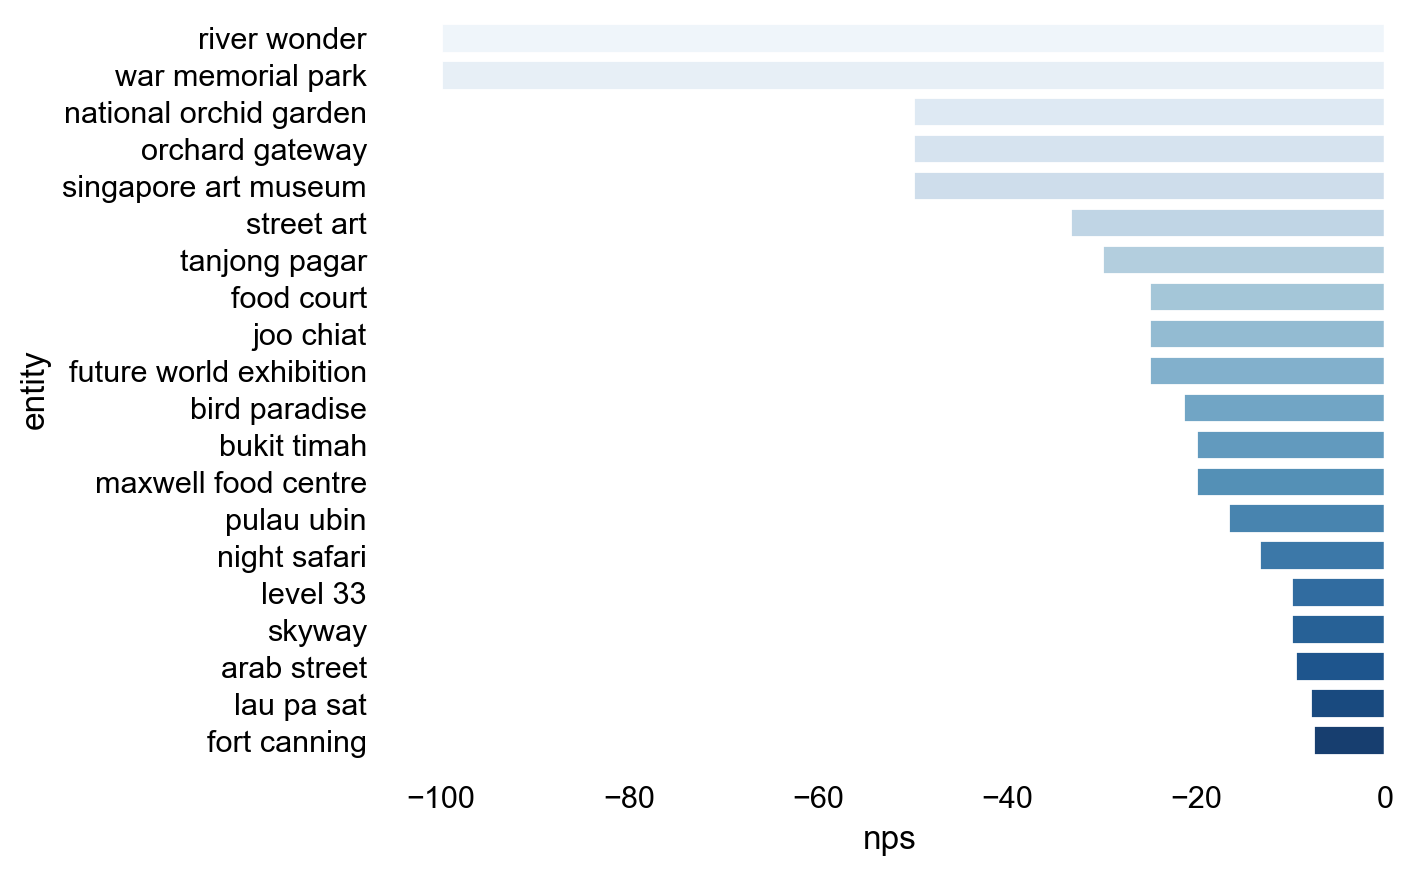

In [32]:
# sort by nps (filtered by top 30 count-wise)
unique_entities_count_df = unique_entities_count_df.sort_values(by=['nps','count','entity'],
                                                                ascending=True)
sns.barplot(data=unique_entities_count_df.head(20),
            x='nps',y='entity',
            palette='Blues')

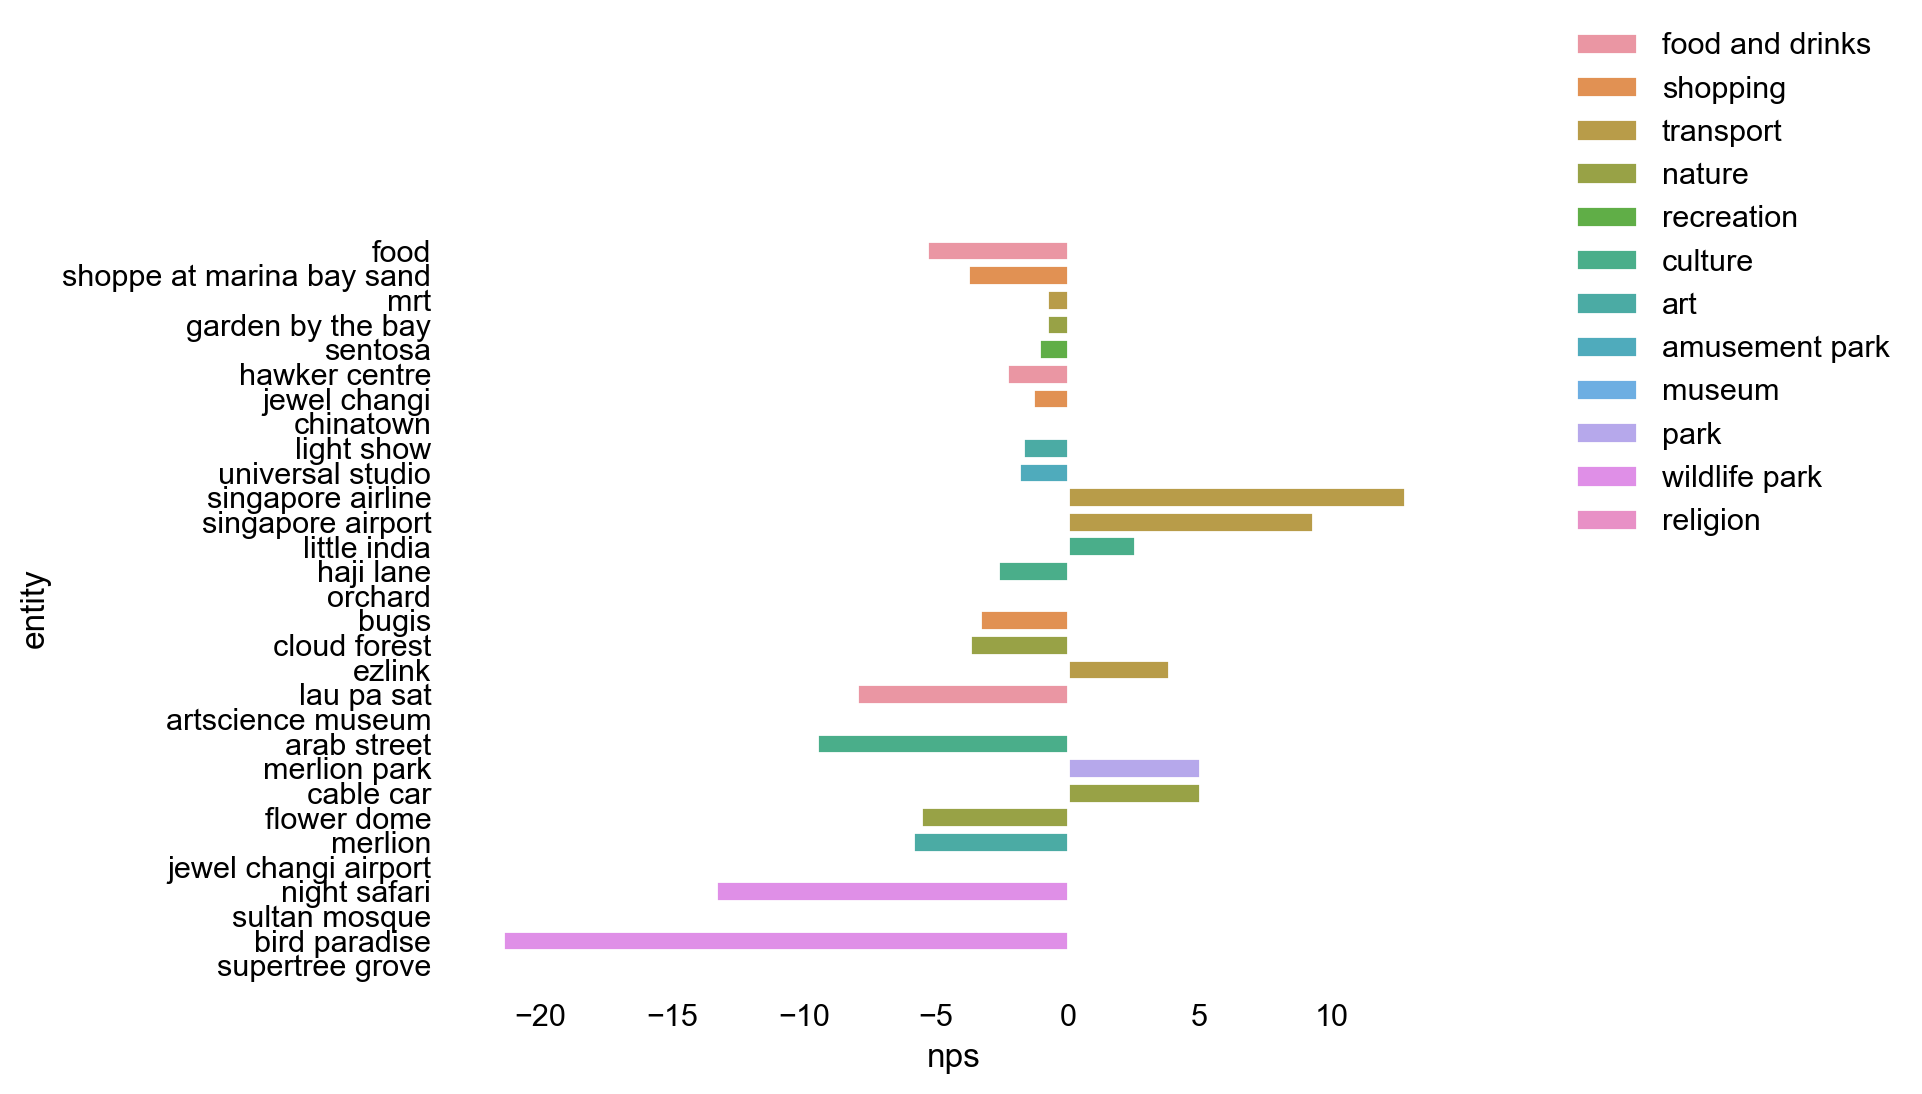

In [38]:
# sort by nps (filtered by top 30 count-wise)
sns.barplot(data=unique_entities_count_df.head(30),x='nps',y='entity',
            hue='interest_1',
            dodge=False)
plt.legend(frameon=False,bbox_to_anchor=(1.1,0.56))

In [57]:
sg_entities_patterns_df.loc[391]

label                              FAC
pattern              singapore airport
sublocation          singapore airport
count                              NaN
country                      singapore
interest_1                    shopping
interest_2                  recreation
indoor_outdoor                  indoor
adjective                          NaN
video_sentiment                    NaN
comment_sentiment                  NaN
Name: 391, dtype: object

#### Add some columns that provide more details to the 

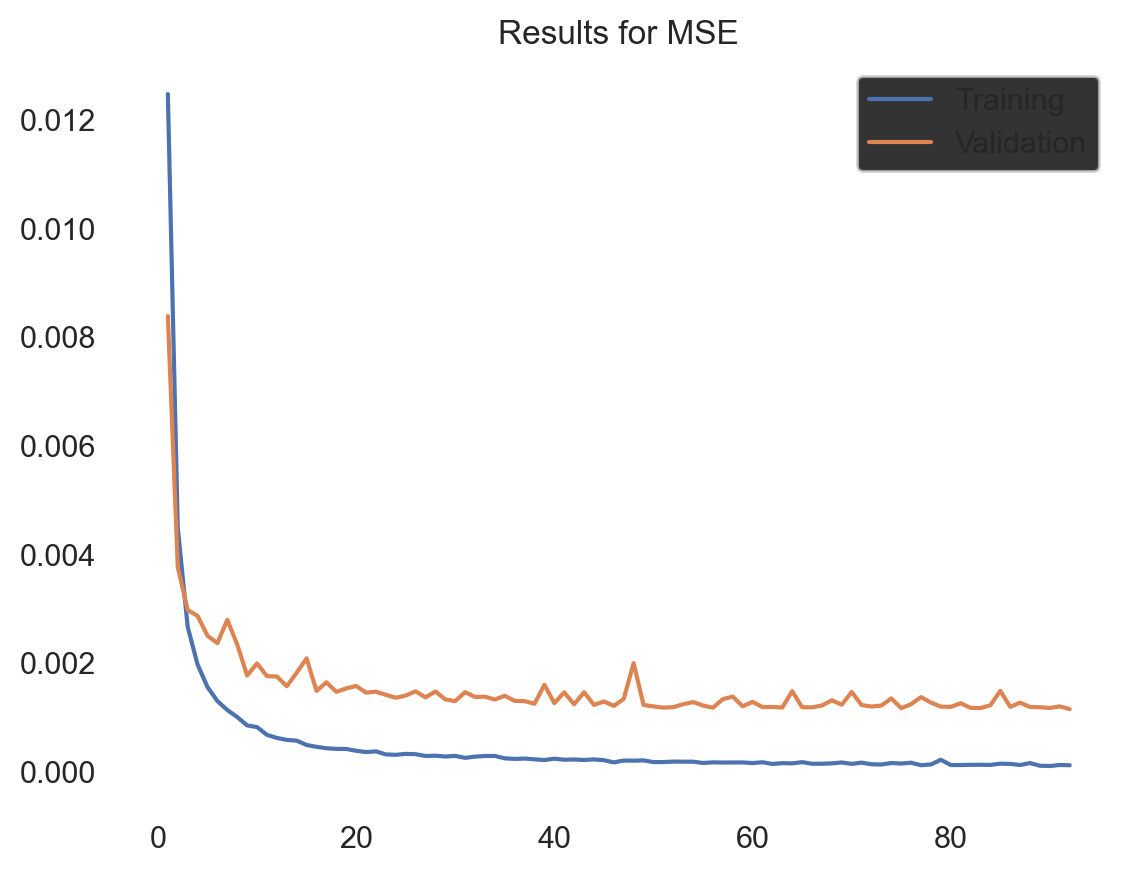

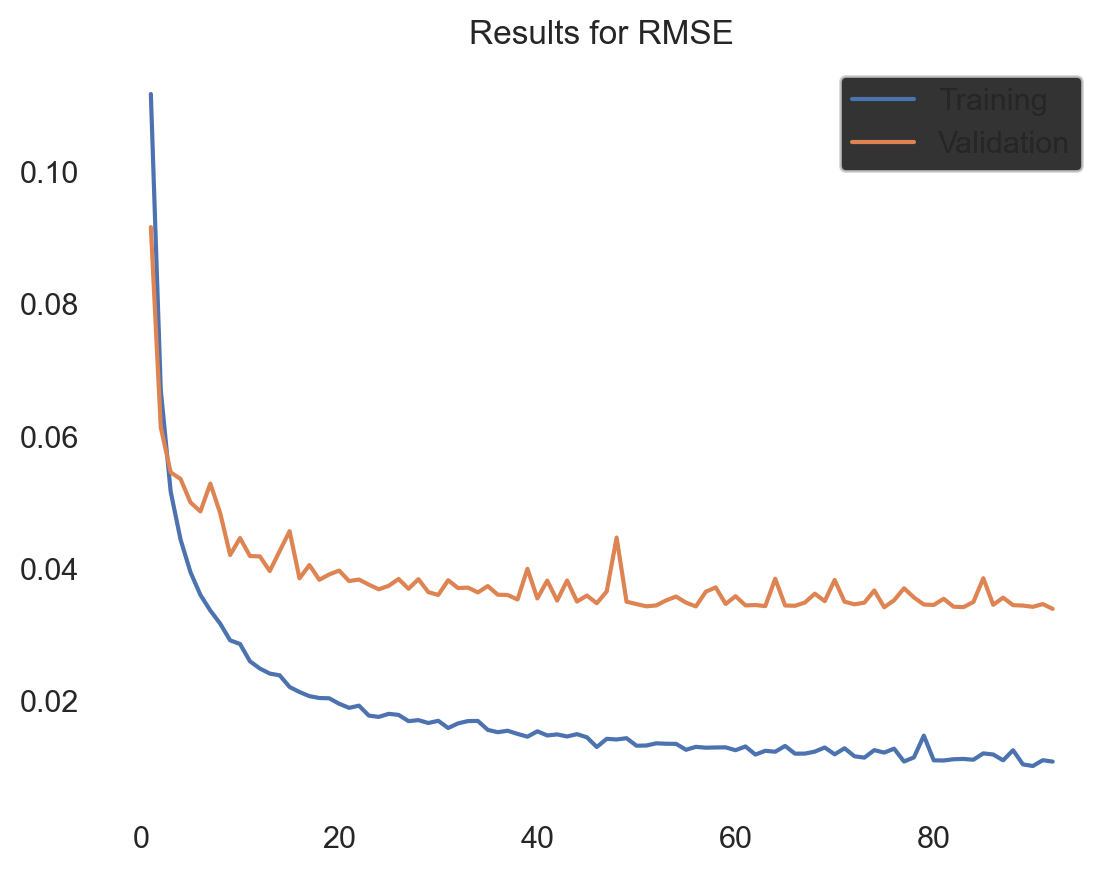

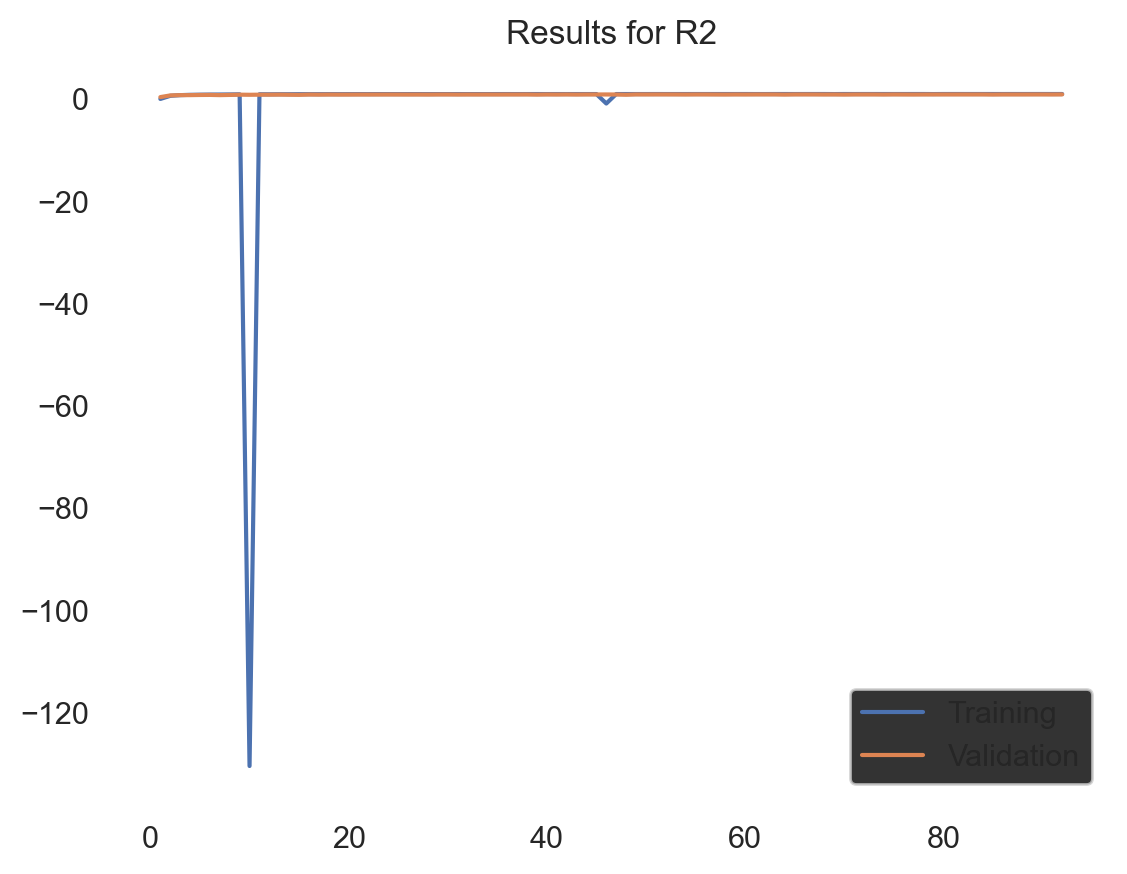

In [60]:
for i in ['MSE','RMSE','R2']:
    metric = hist[i]
    val_metric = hist[f'val_{i}']
    epochs = range(1, len(metric) + 1)

    plt.figure()
    plt.plot(epochs, metric, label='Training')
    plt.plot(epochs, val_metric, label='Validation')
    plt.title(f'Results for {i}')
    plt.legend()
    plt.show()

In [31]:
unique_entities_count_df['pos_sentiment_words'][0]

{'sentiment_word': ['amazing',
  'whole',
  'best',
  'live',
  'awesome',
  'love',
  'favorite',
  'incredible',
  'available',
  'top',
  'pretty',
  'sure',
  'most',
  'famous',
  'beautiful',
  'adult',
  'super',
  'win',
  'perfect',
  'fresh',
  'dim',
  'absolutely',
  'really',
  'early',
  'peaceful',
  'fun',
  'wild',
  'much',
  'honestly',
  'more',
  'accurately',
  'real',
  'many',
  'better'],
 'count': [3,
  1,
  1,
  1,
  1,
  1,
  2,
  3,
  1,
  3,
  2,
  1,
  5,
  2,
  4,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  2,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1]}

In [ ]:
# save entity and its corresponding count in a dataframe
unique_entities_count_df = {'entity': [],'count': []}
for k,v in unique_entities_count.items():
    unique_entities_count_df['entity'].append(k)
    unique_entities_count_df['count'].append(v)
unique_entities_count_df = pd.DataFrame(unique_entities_count_df)

In [28]:
unique_entities_count_df['interest_1'].loc[0]

''

In [29]:
unique_entities_count_df.loc[1]

entity                                           future world exhibition
count                                                                  8
promoter_count                                                         0
detractor_count                                                        2
total_count                                                            8
pos_sentiment_words    [best, absolutely, beautiful, best, better, be...
neg_sentiment_words    [mean, mean, down, chicken, mean, hidden, bad,...
interest_1                                                              
interest_2                                                              
indoor_outdoor                                                          
nps                                                                -25.0
Name: 1, dtype: object

In [40]:
sg_entities_patterns_df.loc[117]

label                           FOOD
pattern                         food
sublocation                     food
count                            NaN
country                          NaN
interest_1           food and drinks
interest_2                       NaN
indoor_outdoor                indoor
adjective                        NaN
video_sentiment                  NaN
comment_sentiment                NaN
Name: 117, dtype: object

In [26]:
print(unique_entities_count_df['pos_sentiment_words'].loc[0])

[]


In [ ]:
# Function to add the new list to the existing list in the specified row and column
def add_list(row):
    if row.name == 1:  # Check if it's the second row (index 1)
        return row['ListColumn'] + new_list
    else:
        return row['ListColumn']

In [45]:
train_df['pos_sentiment_words'].loc[1]

['absolutely', 'incredible']

In [41]:
unique_entities_count_df['pos_sentiment_words'].loc[1]

['hhs', ['hhs', 'sdsd']]

In [51]:
type(unique_entities_count_df['pos_sentiment_words'].loc[1])

list

In [47]:
unique_entities_count_df['pos_sentiment_words'].loc[1] = []

/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_76107/1920678257.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['pos_sentiment_words'].loc[1] = []


In [40]:
unique_entities_count_df['pos_sentiment_words'].loc[1].append(['hhs','sdsd'])

In [25]:
# # calculate nps for each entity
# for index, entities in enumerate(train_df['entity']):
#     for entity in entities:
#         if entity in sg_entities_patterns_df['pattern'].values:
#             # find the row number in which this word is found
#             row_num = (sg_entities_patterns_df.index[sg_entities_patterns_df['pattern'] == entity])[0]
#             # replace word with value in 'sublocation'
#             entity = sg_entities_patterns_df['sublocation'][row_num]        
#             # find the row in which this entity is saved in for unique_entities_count_df
#             row_num = (unique_entities_count_df.index[unique_entities_count_df['entity'] == entity])
#             unique_entities_count_df['total_count'].loc[row_num] += 1
#     if train_df['sentiment'].loc[index] >= 9:
#         for entity in entities:
#             if entity in sg_entities_patterns_df['pattern'].values:
#                 # find the row number in which this word is found
#                 row_num = (sg_entities_patterns_df.index[sg_entities_patterns_df['pattern'] == entity])[0]
#                 # replace word with value in 'sublocation'
#                 entity = sg_entities_patterns_df['sublocation'][row_num]                    
#                 # find the row in which this entity is saved in for unique_entities_count_df
#                 row_num = (unique_entities_count_df.index[unique_entities_count_df['entity'] == entity])
#                 unique_entities_count_df['promoter_count'].loc[row_num] += 1
#     elif train_df['sentiment'].loc[index] < 6:
#         for entity in entities:
#             if entity in sg_entities_patterns_df['pattern'].values:
#                 # find the row number in which this word is found
#                 row_num = (sg_entities_patterns_df.index[sg_entities_patterns_df['pattern'] == entity])[0]
#                 # replace word with value in 'sublocation'
#                 entity = sg_entities_patterns_df['sublocation'][row_num]                        
#                 # find the row in which this entity is saved in for unique_entities_count_df
#                 row_num = (unique_entities_count_df.index[unique_entities_count_df['entity'] == entity])
#                 unique_entities_count_df['detractor_count'].loc[row_num] += 1

In [75]:
(unique_entities_count_df.index[unique_entities_count_df['entity'] == 'singapore'])[0]

1

In [76]:

for index, entities in enumerate(train_df['entity']):
    for entity in entities:
        if entity =='singapore':

            row_num = (unique_entities_count_df['entity'] == entity).idxmax()
            unique_entities_count_df['total_count'].loc[row_num] += 1
unique_entities_count_df

/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_68381/3855009510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['total_count'].loc[row_num] += 1


,entity,count,promoter_count,detractor_count,nps,total_count
1,singapore,1887,220,2653,-128.934817,3774
11,food,356,9,193,-51.685393,356
114,malaysia,163,3,126,-75.460123,163
20,shoppe at marina bay sand,133,1,81,-60.150376,133
48,mrt,128,2,109,-83.593750,128
...,...,...,...,...,...,...
3340,030,1,0,1,-100.000000,1
5177,01 jan 2023,1,0,1,-100.000000,1
6394,000 dollar,1,0,1,-100.000000,1
174,00 to 9,1,0,1,-100.000000,1


In [101]:
train_df['sentiment'].loc[0]

10.0

In [69]:
unique_entities

['koma',
 'klo beli',
 'mo yung manga',
 'ethiopia',
 'una de las ciudades',
 'la ce',
 'posso',
 'po kau dun sa',
 'samaan 3d2n',
 'kahit walanv',
 'the last three night',
 'pag babalik',
 'fiqah sam',
 '313 somerset',
 'isang seafarer ang',
 'hablan aya',
 'ko mami',
 'makan sana',
 'earth',
 'mark anthony de guzman',
 'info modem kak',
 'kk coba ketepat',
 '30 to 90 day',
 'nalang ng straw yung mga inumin para',
 'henry à ce moment',
 'sa airport papuntang',
 '4 year ago',
 'georgia',
 'sobrang lakaran kasi diyan',
 'lau tk de passport blh tk',
 'airasia',
 'kalang talaga sa',
 '321',
 'info',
 'teneille jane',
 'pulang',
 'hago',
 'ไปมะ',
 'ready semua insyaallah',
 'ilovekinderbueno',
 'kk',
 'gitu2',
 'jak w radomiu',
 'mkn lagi',
 'jimelyn sigler',
 'pa ng',
 'abunawa',
 'beliau wowww',
 'max',
 'funan',
 'evalo mossemava',
 'kismatkoffi',
 'sg',
 '501',
 'anggi sisi',
 'national museum of singapore',
 'ramai2',
 'jin',
 'mag international',
 '70 cent',
 'gian dối',
 'bocilcanti

Most commonly used words for sentences with sentiment scores that are in the 95th percentile (top 5%).

In [184]:
top_sentences['sentence']

,post_comment,id,sentence,entity,pos_sentiment_words,neg_sentiment_words,textblob,sentiment
0,post,0_post,how to spend the perfect 48 hours in singapore,"[48 hour, singapore]",['perfect'],[],1.0,10.0
16338,post,241_cmt,they are truly the best,[],['best'],[],1.0,10.0
21535,post,317_cmt,s the best airport ever,[],['best'],[],1.0,10.0
21301,post,315_cmt,singapore airlines is the best company in the ...,[singapore airlines],['best'],[],1.0,10.0
21296,post,315_cmt,best the emirates airline,[],['best'],[],1.0,10.0
...,...,...,...,...,...,...,...,...
16922,post,249_cmt,fair play kegs being on your own is so refreshing,[],"['fair', 'own', 'refreshing']",[],0.6,8.0
14249,post,195_cmt,amazing,[],['amazing'],[],0.6,8.0
2458,post,9_cmt,nice photo shop,[],['nice'],[],0.6,8.0
17189,post,257_cmt,can i just fly to ho chi minh city and get a v...,[ho chi minh city],"['fly', 'free']",[],0.6,8.0


In [126]:
bottom_sentences = train_df[train_df['sentiment'] < 4]
list_of_lists_bottom = [entities for entities in bottom_sentences['entity']]

word_counts_bottom = {}

# Loop through each sublist in the list of lists
for sublist in list_of_lists_bottom:
    # Loop through each string in the sublist
    for word in sublist:
        # need to swap out the word with the replacement from my other list
        if word in sg_entities_patterns_df['pattern'].values:
            # find the row number in which this word is found
            row_num = (sg_entities_patterns_df['pattern'] == word).idxmax()
            # replace word with value in 'sublocation'
            word = sg_entities_patterns_df['sublocation'][row_num]
        # Update the count in the dictionary
        word_counts_bottom[word] = word_counts_bottom.get(word, 0) + 1
        
word_counts_bottom

{'level 33': 1,
 'seven pound': 1,
 'singapore': 74,
 'mrt': 3,
 'google': 1,
 'orchard gateway': 1,
 '3rd': 1,
 'the day': 2,
 'future world exhibition': 1,
 'artscience museum': 1,
 '23   17': 1,
 'fort canning': 1,
 'national orchid garden': 1,
 'jewel changi': 3,
 'skyway': 1,
 '4k': 1,
 '4': 3,
 'food': 18,
 'bird paradise': 1,
 '2023': 1,
 '10 day': 1,
 'sunday': 1,
 'first': 3,
 'maxwell food centre': 1,
 '11': 1,
 'night safari': 1,
 '12': 3,
 '10': 1,
 '2 day': 1,
 'one': 7,
 'london': 2,
 'asia': 6,
 'dubai': 1,
 'diyan kami nagstay': 1,
 'joo chiat': 1,
 'malapit sa': 1,
 'nakita yan': 1,
 'only 2 hour': 1,
 'ang mahal pa ng': 3,
 '1': 5,
 'nem nada': 1,
 'ainda': 1,
 'a few month': 1,
 '3': 2,
 'sia': 2,
 '4th': 1,
 'shoppe at marina bay sand': 3,
 '2k': 1,
 'malaysian': 3,
 'kentucky': 1,
 'kasi': 1,
 '12hrs': 1,
 'the first 2 day': 1,
 'tai lalat': 1,
 'libby': 1,
 'weekend': 1,
 '160': 1,
 'ko sya ma': 1,
 'sa': 3,
 'night': 2,
 '11 pm': 1,
 'uk': 1,
 'especialy': 1,
 'm

In [118]:
bottom_sentences

,post_comment,id,sentence,entity,pos_sentiment_words,neg_sentiment_words,textblob,sentiment
19362,post,288_cmt,s insane,[],[],['insane'],-1.000000,0.000000
12347,post,167_cmt,this is insane,[],[],['insane'],-1.000000,0.000000
29996,post,435_cmt,insane god mode tip,[],[],['insane'],-1.000000,0.000000
2295,post,8_cmt,singapore is so so boring place to be,[singapore],[],['boring'],-1.000000,0.000000
18472,post,276_cmt,experience it or else stuck in singapore will ...,[singapore],[],['boring'],-1.000000,0.000000
...,...,...,...,...,...,...,...,...
21615,post,317_cmt,because your rich and am poor,[],['rich'],['poor'],-0.012500,4.937500
11597,post,153_cmt,on the other hand cheers offers some drinks,[],['offers'],['other'],-0.012500,4.937500
1400,post,435_post,we even had trouble finding a restaurant that ...,[food],['decent'],['trouble'],-0.011111,4.944444
1306,post,389_post,hi im jess and im jack and this is day one of ...,"[jack, 3 year, the next 6 month, jack, day 1]",['old'],"['long', 'spent']",-0.008333,4.958333


In [55]:
sg_entities_patterns_df

,label,pattern,sublocation,count,country,interest_1,interest_2,indoor_outdoor,adjective,video_sentiment,comment_sentiment
0,FAC,100 am,100 am,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN
1,FAC,313,313 somerset,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN
2,FAC,313 somerset,313 somerset,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN
3,FAC,321 clementi,321 clementi,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN
4,FAC,888 plaza,888 plaza,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
505,FAC,yishun pond park,yishun pond park,NaN,NaN,park,NaN,outdoor,NaN,NaN,NaN
506,FAC,youth olympic park,youth olympic park,NaN,NaN,park,NaN,outdoor,NaN,NaN,NaN
507,FAC,yueh hai ching,yueh hai ching,NaN,NaN,religion,NaN,indoor,NaN,NaN,NaN
508,FAC,zhenghua park,zhenghua park,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN


In [11]:
train_df

,post_comment,id,sentence,entity,pos_sentiment_words,neg_sentiment_words,textblob,sentiment
0,post,0_post,how to spend the perfect 48 hours in singapore,"[48 hour, singapore]",['perfect'],[],1.000000,8.111308
1,post,0_post,first head to your waterfall at singapore airp...,"[first, singapore airport]","['absolutely', 'incredible']",[],0.900000,7.741759
2,post,0_post,then head to the center and drop by the future...,"[future world exhibition, art science museum]",[],[],0.000000,4.319438
3,post,0_post,next you have to head to gardens by the bay it...,[garden by the bay],"['completely', 'free', 'amazing']",[],0.333333,5.610582
4,post,0_post,dont forget to buy tickets for the skyway for ...,"[skyway, floral fantasy]","['most', 'magical']",['insane'],0.000000,4.319438
...,...,...,...,...,...,...,...,...
31322,post,435_cmt,locals,[],[],[],0.000000,4.319438
31323,post,435_cmt,you complained singaporeans are rude bec of yo...,[1],[],"['complained', 'rude']",-0.300000,3.123254
31324,post,435_cmt,i felt sorry for your friend if he is a singap...,[singaporean],[],['sorry'],-0.500000,2.300190
31325,post,435_cmt,next time do a bit of googling before going to...,[],['new'],[],0.068182,4.586362


In [12]:
top_sentences

NameError: name 'top_sentences' is not defined

In [8]:
statistical_data(train_df, 'sentiment')

Statistical Data for sentiment
Mean: 4.635983900971838
Standard Deviation: 0.9338122887958783
p: 0.0
Since p <= 0.07, it can be concluded that sentiment does not follow a normal distribution (reject H0)
Distribution of sentiment is positively skewed, with skew at: 1.345865255677649


inverse_transform(X[, copy])

Scale back the data to the original representation.

In [11]:
y_train = y_train.array
y_test = y_test.array

mm = MinMaxScaler()
mm.fit(y_train.reshape(-1,1))
y_train = mm.transform(y_train.reshape(-1,1))
y_test = mm.transform(y_test.reshape(-1,1))

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

### Scaling

ss = StandardScaler()
ss.fit(y_train.reshape(-1, 1))
y_train_sc = ss.transform(y_train)
y_test_sc = ss.transform(y_test)

y_train = y_train.array
y_test = y_test.array

ss = StandardScaler()
ss.fit(y_train.reshape(-1,1))
y_train = ss.transform(y_train.reshape(-1,1))
y_test = ss.transform(y_test.reshape(-1,1))

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

<Axes: xlabel='epoch', ylabel='r2'>

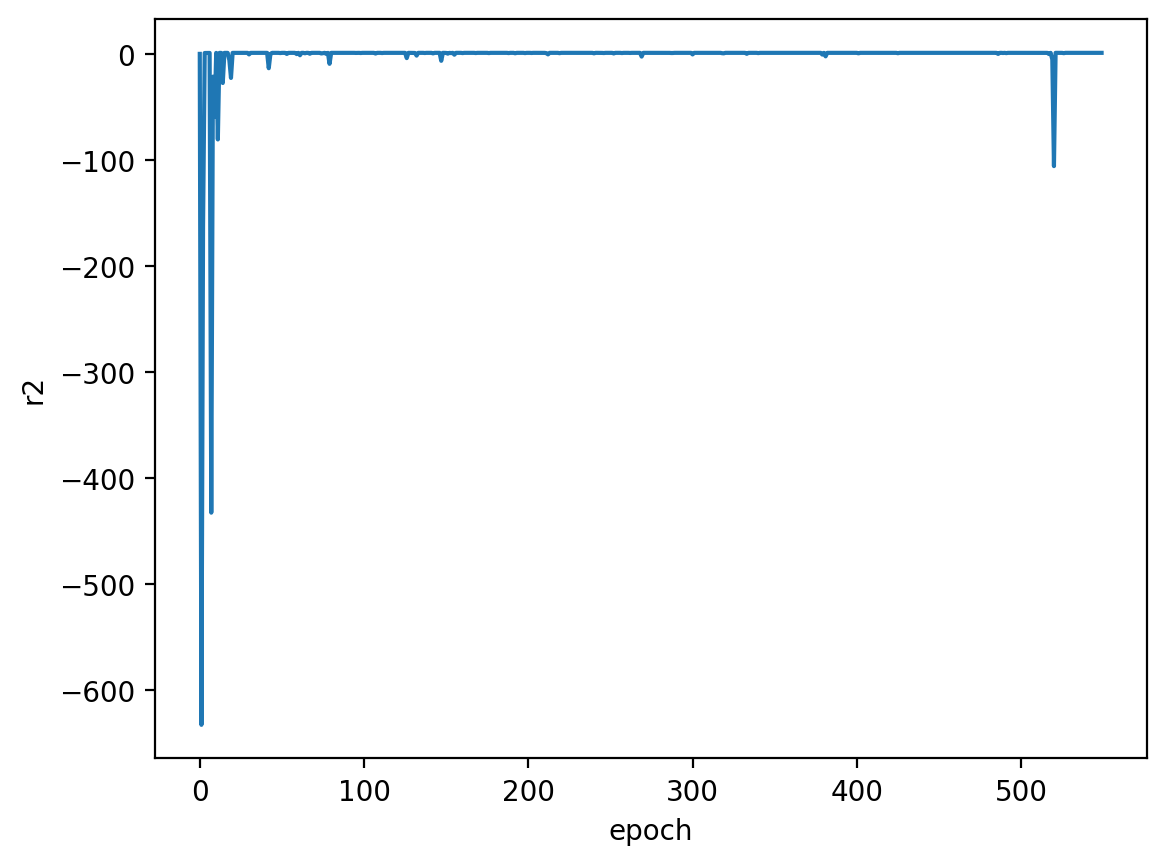

In [27]:
sns.lineplot(data=hist,x='epoch',y='r2')